✅ Loaded data with shape: (500, 450)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 450 entries, hsi_id to vomitoxin_ppb
dtypes: float64(449), object(1)
memory usage: 1.7+ MB
None

📊 Summary Statistics for Reflectance Bands:
   count      mean       std       min       25%       50%       75%       max
0  500.0  0.443118  0.044719  0.311182  0.410456  0.449105  0.480245  0.556287
1  500.0  0.440761  0.045520  0.295321  0.404310  0.442651  0.478822  0.530168
2  500.0  0.433814  0.045764  0.284064  0.397038  0.434215  0.473158  0.528774
3  500.0  0.426122  0.046070  0.282054  0.389029  0.425074  0.464947  0.533202
4  500.0  0.418990  0.045405  0.296702  0.382102  0.417075  0.459232  0.511909

📊 Summary Statistics for Target (vomitoxin_ppb):
count       500.000000
mean       3410.006000
std       13095.803483
min           0.000000
25%         137.500000
50%         500.000000
75%        1700.000000
max      131000.000000
Name: vomitoxin_ppb, dtype: float

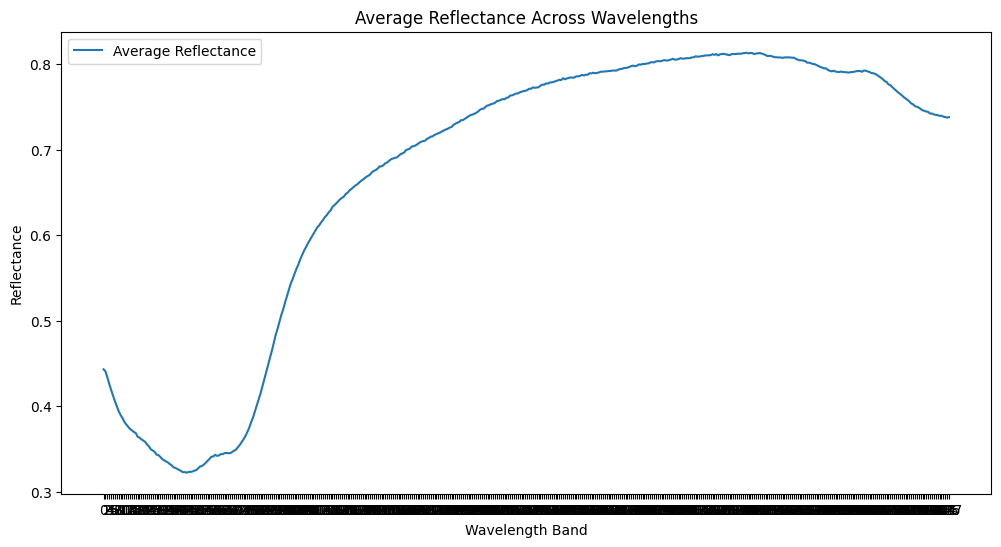

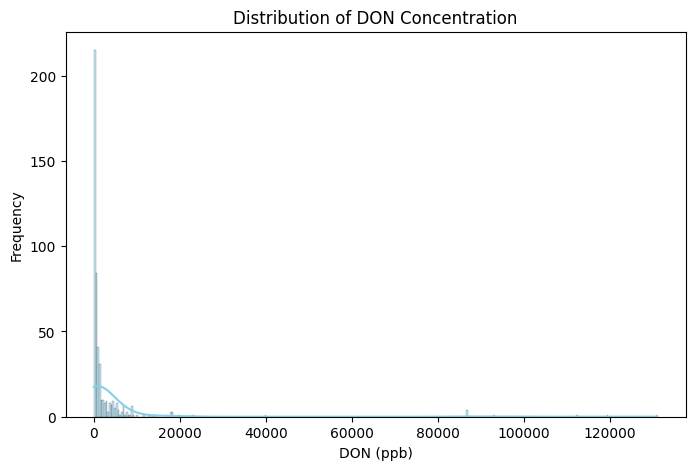

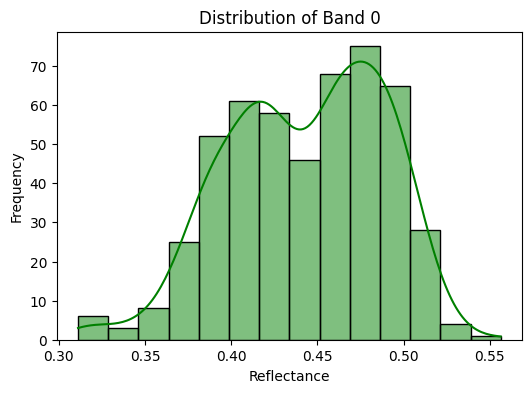

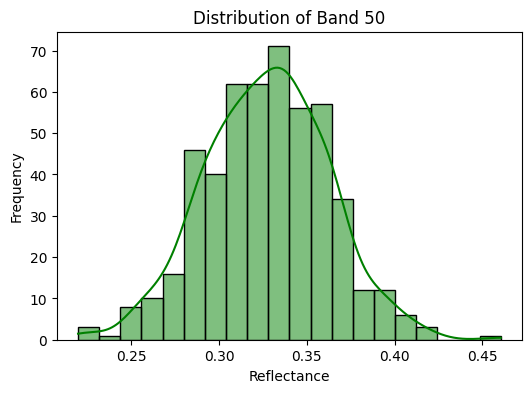

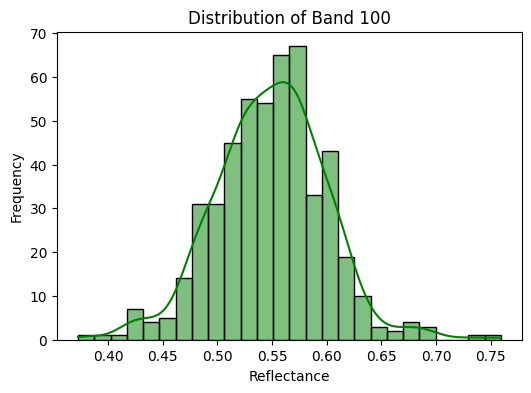

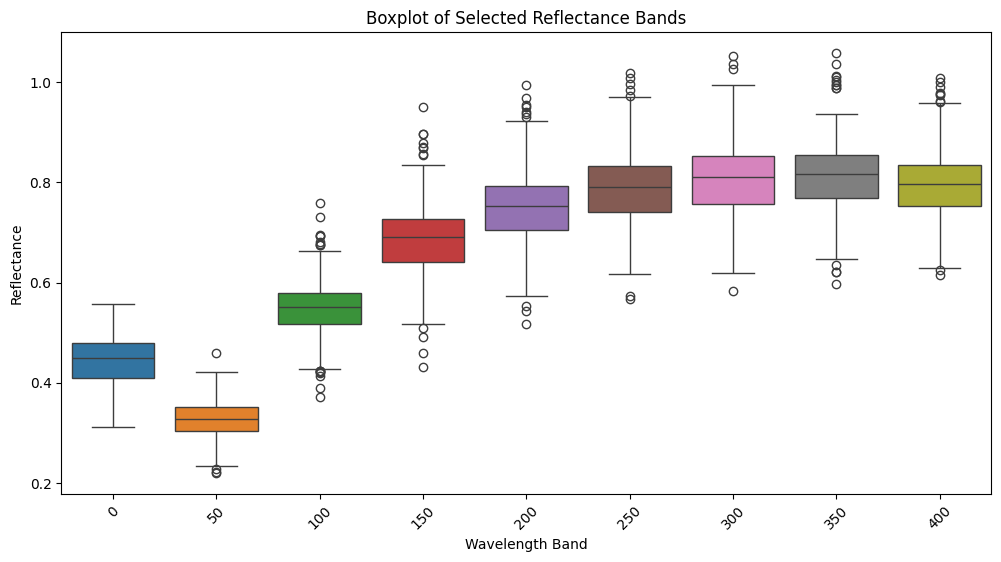

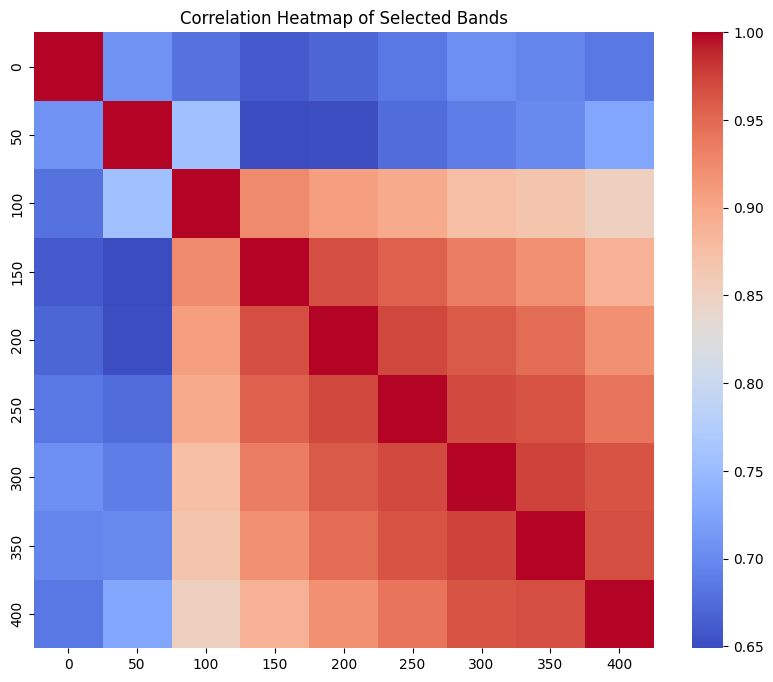

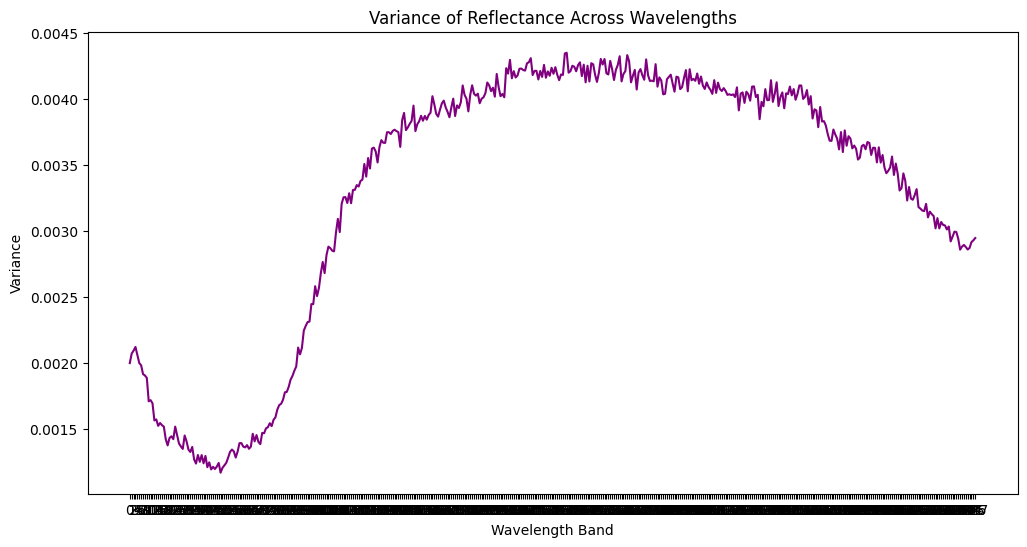

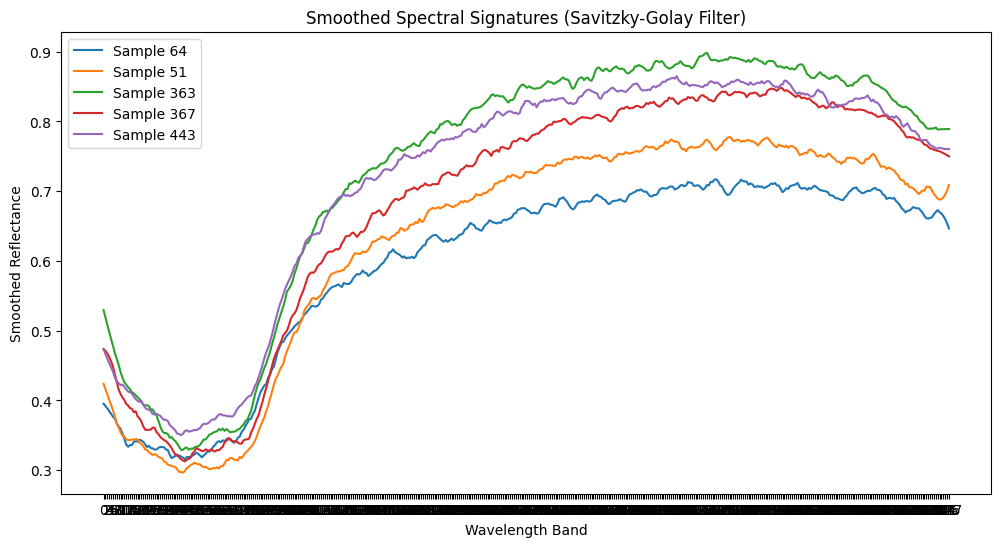

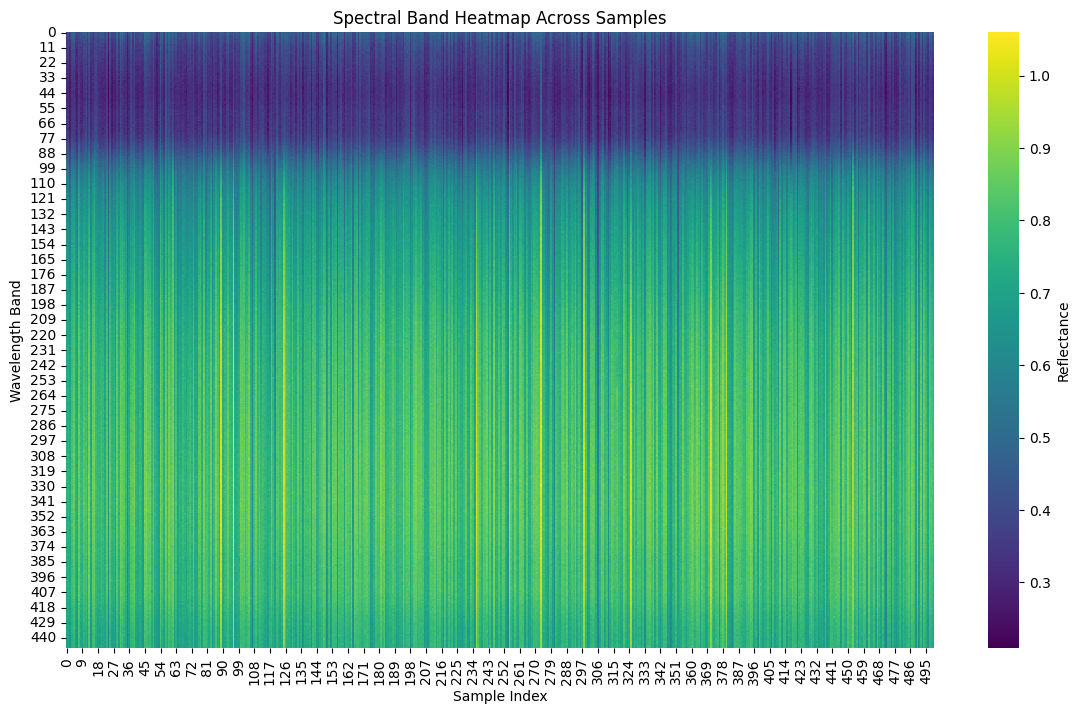

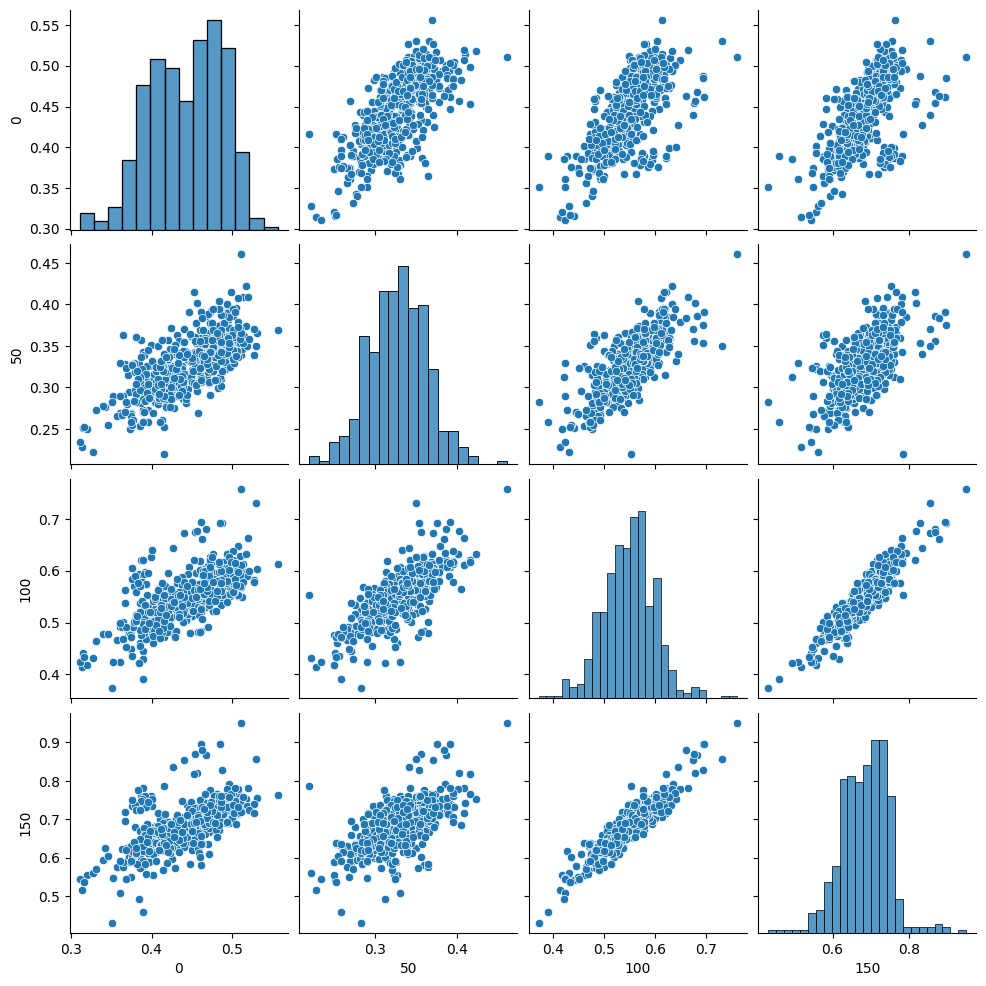

✅ Split data: X_train (400, 449), X_test (100, 449), y_train (400,), y_test (100,)
✅ NDVI-like index added post-split.
After NDVI: X_train (400, 450), X_test (100, 450)
✅ Missing values imputed with mean.
✅ Reflectance bands standardized.
✅ PCA applied: 70 components retained, explaining 98.02% variance.


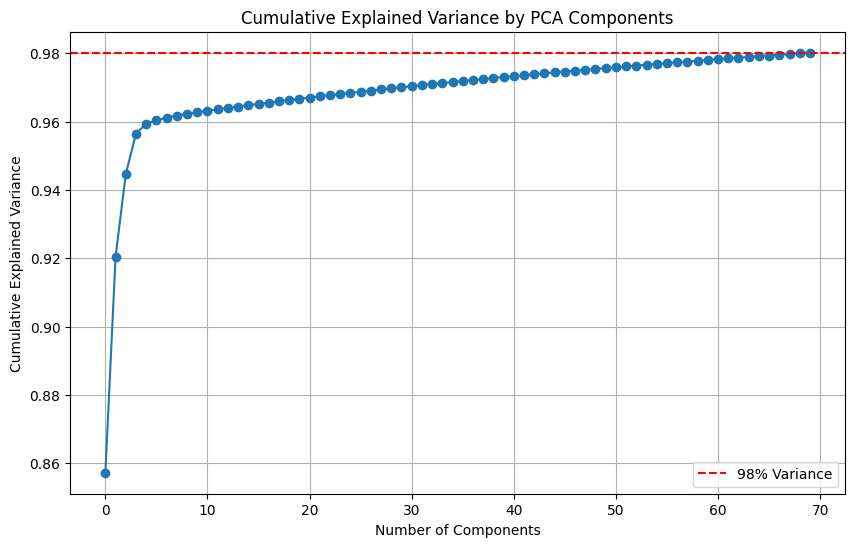

Final shapes before return: X_train (395, 71), X_test (100, 71), y_train (395, 2), y_test (100, 2)
✅ Saved X_train to ../data/processed/x_train.csv
✅ Saved X_test to ../data/processed/x_test.csv
✅ Saved y_train to ../data/processed/y_train.csv
✅ Saved y_test to ../data/processed/y_test.csv
X_train shape: (395, 71)
X_test shape: (100, 71)
y_train shape: (395, 2)
y_test shape: (100, 2)


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import zscore
from scipy.signal import savgol_filter

# Define file paths and constants directly
raw_data_path = "/home/m23csa017/hsi_don_pipeline/data/raw/MLE-Assignment.csv"
x_train_path = "../data/processed/x_train.csv"
x_test_path = "../data/processed/x_test.csv"
y_train_path = "../data/processed/y_train.csv"
y_test_path = "../data/processed/y_test.csv"
NIR_BAND = "100"  # Band for NDVI-like index (NIR)
RED_BAND = "50"   # Band for NDVI-like index (Red)
reflectance_cols = None  # Will be set after loading data

# --- Core Functions ---
def load_data(path):
    """Load raw data and check for inconsistencies"""
    df = pd.read_csv(path)
    global reflectance_cols
    reflectance_cols = [col for col in df.columns if col not in ["hsi_id", "vomitoxin_ppb"]]
    
    negative_values = (df[reflectance_cols] < 0).sum().sum()
    if negative_values > 0:
        print(f"⚠️ Warning: {negative_values} negative reflectance values found.")
    
    print(f"✅ Loaded data with shape: {df.shape}")
    print(df.info())
    return df

def perform_eda(df):
    """EDA with visualizations and additional checks"""
    print("\n📊 Summary Statistics for Reflectance Bands:")
    print(df[reflectance_cols].describe().T.head())
    
    print("\n📊 Summary Statistics for Target (vomitoxin_ppb):")
    print(df["vomitoxin_ppb"].describe())

    missing_values = df.isnull().sum()
    print("\n❗ Missing Values:")
    print(missing_values[missing_values > 0])
    print(f"❗ Duplicate Rows: {df.duplicated().sum()}")

    plt.figure(figsize=(12, 6))
    plt.plot(df[reflectance_cols].mean(), label="Average Reflectance")
    plt.title("Average Reflectance Across Wavelengths")
    plt.xlabel("Wavelength Band")
    plt.ylabel("Reflectance")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.histplot(df["vomitoxin_ppb"], kde=True, color="skyblue")
    plt.title("Distribution of DON Concentration")
    plt.xlabel("DON (ppb)")
    plt.ylabel("Frequency")
    plt.show()

    selected_bands = reflectance_cols[::50]
    for band in selected_bands[:3]:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[band], kde=True, color="green")
        plt.title(f"Distribution of Band {band}")
        plt.xlabel("Reflectance")
        plt.ylabel("Frequency")
        plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df[selected_bands])
    plt.title("Boxplot of Selected Reflectance Bands")
    plt.xlabel("Wavelength Band")
    plt.ylabel("Reflectance")
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(10, 8))
    sns.heatmap(df[selected_bands].corr(), cmap="coolwarm", annot=False)
    plt.title("Correlation Heatmap of Selected Bands")
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(df[reflectance_cols].var(), color='purple')
    plt.title("Variance of Reflectance Across Wavelengths")
    plt.xlabel("Wavelength Band")
    plt.ylabel("Variance")
    plt.show()

    plt.figure(figsize=(12, 6))
    sample_indices = np.random.choice(df.index, size=5, replace=False)
    for idx in sample_indices:
        smoothed = savgol_filter(df.loc[idx, reflectance_cols], window_length=11, polyorder=2)
        plt.plot(reflectance_cols, smoothed, label=f"Sample {idx}")
    plt.title("Smoothed Spectral Signatures (Savitzky-Golay Filter)")
    plt.xlabel("Wavelength Band")
    plt.ylabel("Smoothed Reflectance")
    plt.legend()
    plt.show()

    plt.figure(figsize=(14, 8))
    sns.heatmap(df[reflectance_cols].T, cmap="viridis", cbar_kws={'label': 'Reflectance'})
    plt.title("Spectral Band Heatmap Across Samples")
    plt.xlabel("Sample Index")
    plt.ylabel("Wavelength Band")
    plt.show()

    subset_bands = selected_bands[:4]
    sns.pairplot(df[subset_bands])
    plt.show()

def preprocess_data(df):
    """Preprocessing with reduced leakage risk, returning separate X and y"""
    # Split data first
    X = df.drop(columns=["vomitoxin_ppb"])
    y = df["vomitoxin_ppb"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )
    print(f"✅ Split data: X_train {X_train.shape}, X_test {X_test.shape}, y_train {y_train.shape}, y_test {y_test.shape}")

    # Add NDVI-like index post-split
    X_train["ndvi_like"] = (X_train[NIR_BAND] - X_train[RED_BAND]) / \
                           (X_train[NIR_BAND] + X_train[RED_BAND] + 1e-9)
    X_test["ndvi_like"] = (X_test[NIR_BAND] - X_test[RED_BAND]) / \
                          (X_test[NIR_BAND] + X_test[RED_BAND] + 1e-9)
    print("✅ NDVI-like index added post-split.")
    print(f"After NDVI: X_train {X_train.shape}, X_test {X_test.shape}")

    # Define feature columns (exclude 'hsi_id')
    feature_cols = reflectance_cols + ["ndvi_like"]

    # Preprocessing steps
    imputer = SimpleImputer(strategy="mean")
    X_train[feature_cols] = imputer.fit_transform(X_train[feature_cols])
    X_test[feature_cols] = imputer.transform(X_test[feature_cols])
    print("✅ Missing values imputed with mean.")

    scaler = StandardScaler()
    X_train[feature_cols] = scaler.fit_transform(X_train[feature_cols])
    X_test[feature_cols] = scaler.transform(X_test[feature_cols])
    print("✅ Reflectance bands standardized.")


    # Anomaly detection with Z-score on training data
    z_scores = np.abs(zscore(X_train[reflectance_cols]))
    anomaly_mask = (z_scores > 3).sum(axis=1) < 0.5 * len(reflectance_cols)

    # Apply mask to both X_train and y_train
    X_train = X_train[anomaly_mask].reset_index(drop=True)
    y_train = y_train[anomaly_mask].reset_index(drop=True)  # ← Corrected

    # Prepare final y DataFrames with aligned indices
    y_train_final = pd.DataFrame({
        "hsi_id": X_train["hsi_id"].reset_index(drop=True),
        "vomitoxin_ppb": y_train.reset_index(drop=True)
    })

    y_test_final = pd.DataFrame({
        "hsi_id": X_test["hsi_id"].reset_index(drop=True),
        "vomitoxin_ppb": y_test.reset_index(drop=True)  # ← Corrected
    })


    # PCA with 70 components (based on your 98% variance insight)
    pca = PCA(n_components=70)  # Fixed to 70 per your analysis
    X_train_processed = pca.fit_transform(X_train[feature_cols])
    X_test_processed = pca.transform(X_test[feature_cols])
    print(f"✅ PCA applied: 70 components retained, explaining {sum(pca.explained_variance_ratio_):.2%} variance.")

    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.axhline(y=0.98, color='r', linestyle='--', label='98% Variance')
    plt.title("Cumulative Explained Variance by PCA Components")
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Prepare final X_train and X_test with PCA components and hsi_id
    X_train_final = pd.DataFrame(X_train_processed, columns=[f"PC{i+1}" for i in range(70)])
    X_train_final["hsi_id"] = X_train["hsi_id"].reset_index(drop=True)
    X_test_final = pd.DataFrame(X_test_processed, columns=[f"PC{i+1}" for i in range(70)])
    X_test_final["hsi_id"] = X_test["hsi_id"].reset_index(drop=True)

    # Prepare y_train and y_test with hsi_id for alignment
    y_train_final = pd.DataFrame({"hsi_id": X_train["hsi_id"].reset_index(drop=True), "vomitoxin_ppb": y_train})
    y_test_final = pd.DataFrame({
        "hsi_id": X_test["hsi_id"].reset_index(drop=True),
        "vomitoxin_ppb": y_test.reset_index(drop=True)
    })


    print(f"Final shapes before return: X_train {X_train_final.shape}, X_test {X_test_final.shape}, "
          f"y_train {y_train_final.shape}, y_test {y_test_final.shape}")

    return X_train_final, X_test_final, y_train_final, y_test_final

# --- Execution Flow ---
if __name__ == "__main__":
    # Load data
    raw_data = load_data(raw_data_path)

    # Perform EDA
    perform_eda(raw_data)

    # Preprocess and get X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = preprocess_data(raw_data)

    # Save X and y separately
    X_train.to_csv(x_train_path, index=False)
    X_test.to_csv(x_test_path, index=False)
    y_train.to_csv(y_train_path, index=False)
    y_test.to_csv(y_test_path, index=False)
    print(f"✅ Saved X_train to {x_train_path}")
    print(f"✅ Saved X_test to {x_test_path}")
    print(f"✅ Saved y_train to {y_train_path}")
    print(f"✅ Saved y_test to {y_test_path}")

    # Verify shapes
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")

### XGBOOST


In [2]:
! pip install xgboost --quiet


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
! pip install lightgbm


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip




# Mycotoxin Prediction Pipeline - Model Development
**Next Steps:**
1. Model Training & Evaluation
2. Hyperparameter Tuning
3. Interpretability Analysis
4. Production Pipeline Preparation



X_train shape: (395, 71)
X_test shape: (100, 71)
y_train shape: (395, 2)
y_test shape: (100, 2)


/home/m23csa017/hsi_don_pipeline/hsi_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


XGBoost Baseline Performance:


,CV_RMSE_mean,CV_RMSE_std,Test_MAE,Test_RMSE,Test_R2
0,7434.831881,4737.321108,2974.342623,9598.383941,0.670418


[I 2025-03-31 04:20:40,483] A new study created in memory with name: no-name-f0541d21-df80-4a58-9b07-d256797e63c0
Best trial: 0. Best value: 8638.2:   2%|▏         | 1/50 [00:01<01:06,  1.36s/it]

[I 2025-03-31 04:20:41,842] Trial 0 finished with value: 8638.195021106209 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.02904180608409973, 'reg_alpha': 0.8661761457749352, 'reg_lambda': 0.6011150117432088}. Best is trial 0 with value: 8638.195021106209.


Best trial: 1. Best value: 8472.02:   4%|▍         | 2/50 [00:01<00:37,  1.26it/s]

[I 2025-03-31 04:20:42,235] Trial 1 finished with value: 8472.01510346909 and parameters: {'n_estimators': 383, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'min_child_weight': 2, 'gamma': 0.09170225492671691, 'reg_alpha': 0.3042422429595377, 'reg_lambda': 0.5247564316322378}. Best is trial 1 with value: 8472.01510346909.


Best trial: 2. Best value: 8366.58:   6%|▌         | 3/50 [00:02<00:29,  1.62it/s]

[I 2025-03-31 04:20:42,646] Trial 2 finished with value: 8366.580089959643 and parameters: {'n_estimators': 273, 'max_depth': 5, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_bytree': 0.7168578594140873, 'min_child_weight': 4, 'gamma': 0.22803499210851796, 'reg_alpha': 0.7851759613930136, 'reg_lambda': 0.19967378215835974}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:   8%|▊         | 4/50 [00:03<00:36,  1.28it/s]

[I 2025-03-31 04:20:43,685] Trial 3 finished with value: 8562.056737865132 and parameters: {'n_estimators': 306, 'max_depth': 7, 'learning_rate': 0.011711509955524094, 'subsample': 0.8430179407605753, 'colsample_bytree': 0.6682096494749166, 'min_child_weight': 1, 'gamma': 0.4744427686266666, 'reg_alpha': 0.9656320330745594, 'reg_lambda': 0.8083973481164611}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  10%|█         | 5/50 [00:03<00:26,  1.72it/s]

[I 2025-03-31 04:20:43,909] Trial 4 finished with value: 8623.008711826451 and parameters: {'n_estimators': 222, 'max_depth': 3, 'learning_rate': 0.1024932221692416, 'subsample': 0.7760609974958406, 'colsample_bytree': 0.6488152939379115, 'min_child_weight': 5, 'gamma': 0.017194260557609198, 'reg_alpha': 0.9093204020787821, 'reg_lambda': 0.2587799816000169}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  12%|█▏        | 6/50 [00:03<00:24,  1.80it/s]

[I 2025-03-31 04:20:44,412] Trial 5 finished with value: 9054.103192813573 and parameters: {'n_estimators': 365, 'max_depth': 5, 'learning_rate': 0.05864129169696527, 'subsample': 0.8186841117373118, 'colsample_bytree': 0.6739417822102108, 'min_child_weight': 10, 'gamma': 0.3875664116805573, 'reg_alpha': 0.9394989415641891, 'reg_lambda': 0.8948273504276488}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  14%|█▍        | 7/50 [00:04<00:30,  1.41it/s]

[I 2025-03-31 04:20:45,433] Trial 6 finished with value: 8834.445348039533 and parameters: {'n_estimators': 339, 'max_depth': 10, 'learning_rate': 0.01351182947645082, 'subsample': 0.6783931449676581, 'colsample_bytree': 0.6180909155642152, 'min_child_weight': 4, 'gamma': 0.194338644844741, 'reg_alpha': 0.2713490317738959, 'reg_lambda': 0.8287375091519293}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  16%|█▌        | 8/50 [00:05<00:27,  1.51it/s]

[I 2025-03-31 04:20:45,995] Trial 7 finished with value: 9252.97775763449 and parameters: {'n_estimators': 243, 'max_depth': 5, 'learning_rate': 0.06333268775321842, 'subsample': 0.6563696899899051, 'colsample_bytree': 0.9208787923016158, 'min_child_weight': 1, 'gamma': 0.49344346830025865, 'reg_alpha': 0.7722447692966574, 'reg_lambda': 0.1987156815341724}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  18%|█▊        | 9/50 [00:06<00:25,  1.59it/s]

[I 2025-03-31 04:20:46,558] Trial 8 finished with value: 9066.121488886556 and parameters: {'n_estimators': 102, 'max_depth': 9, 'learning_rate': 0.11069143219393454, 'subsample': 0.8916028672163949, 'colsample_bytree': 0.9085081386743783, 'min_child_weight': 1, 'gamma': 0.1792328642721363, 'reg_alpha': 0.11586905952512971, 'reg_lambda': 0.8631034258755935}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  20%|██        | 10/50 [00:06<00:23,  1.70it/s]

[I 2025-03-31 04:20:47,052] Trial 9 finished with value: 9161.886163244382 and parameters: {'n_estimators': 349, 'max_depth': 5, 'learning_rate': 0.012413189635294229, 'subsample': 0.7243929286862649, 'colsample_bytree': 0.7300733288106989, 'min_child_weight': 8, 'gamma': 0.31877873567760656, 'reg_alpha': 0.8872127425763265, 'reg_lambda': 0.4722149251619493}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  22%|██▏       | 11/50 [00:07<00:26,  1.49it/s]

[I 2025-03-31 04:20:47,910] Trial 10 finished with value: 8579.73625542719 and parameters: {'n_estimators': 478, 'max_depth': 7, 'learning_rate': 0.028477486830279865, 'subsample': 0.6071847502459278, 'colsample_bytree': 0.8010124870699185, 'min_child_weight': 7, 'gamma': 0.2760977256675942, 'reg_alpha': 0.6240835271723653, 'reg_lambda': 0.039907535719484855}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  24%|██▍       | 12/50 [00:07<00:23,  1.63it/s]

[I 2025-03-31 04:20:48,393] Trial 11 finished with value: 8583.825992346703 and parameters: {'n_estimators': 462, 'max_depth': 3, 'learning_rate': 0.24950292438859506, 'subsample': 0.9687557027925864, 'colsample_bytree': 0.7737425087025644, 'min_child_weight': 3, 'gamma': 0.12003329156932674, 'reg_alpha': 0.4182682716196848, 'reg_lambda': 0.46994321499695574}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  26%|██▌       | 13/50 [00:08<00:20,  1.77it/s]

[I 2025-03-31 04:20:48,849] Trial 12 finished with value: 8546.500314147888 and parameters: {'n_estimators': 418, 'max_depth': 4, 'learning_rate': 0.27675589864710687, 'subsample': 0.9994636029283407, 'colsample_bytree': 0.8404427663008558, 'min_child_weight': 4, 'gamma': 0.09695084439740809, 'reg_alpha': 0.5245057886624165, 'reg_lambda': 0.2944068495666103}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  28%|██▊       | 14/50 [00:08<00:16,  2.18it/s]

[I 2025-03-31 04:20:49,059] Trial 13 finished with value: 8847.163199715804 and parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.02984224442314634, 'subsample': 0.9199690201206847, 'colsample_bytree': 0.7286923691999561, 'min_child_weight': 6, 'gamma': 0.21454949780832402, 'reg_alpha': 0.3091339583045281, 'reg_lambda': 0.64208794318194}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  30%|███       | 15/50 [00:09<00:19,  1.82it/s]

[I 2025-03-31 04:20:49,822] Trial 14 finished with value: 8488.006240212499 and parameters: {'n_estimators': 392, 'max_depth': 6, 'learning_rate': 0.17080659935001277, 'subsample': 0.7507711462516721, 'colsample_bytree': 0.9840998651516013, 'min_child_weight': 3, 'gamma': 0.12417011982640969, 'reg_alpha': 0.689155822984862, 'reg_lambda': 0.09086840375111387}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  32%|███▏      | 16/50 [00:09<00:16,  2.11it/s]

[I 2025-03-31 04:20:50,124] Trial 15 finished with value: 8590.865789113861 and parameters: {'n_estimators': 270, 'max_depth': 3, 'learning_rate': 0.03545757434511042, 'subsample': 0.9063978236539806, 'colsample_bytree': 0.716507181535291, 'min_child_weight': 3, 'gamma': 0.3343228607836479, 'reg_alpha': 0.010065752312506171, 'reg_lambda': 0.43451435782595793}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  34%|███▍      | 17/50 [00:10<00:18,  1.83it/s]

[I 2025-03-31 04:20:50,836] Trial 16 finished with value: 9244.905607449959 and parameters: {'n_estimators': 434, 'max_depth': 6, 'learning_rate': 0.17382062178166294, 'subsample': 0.60195639766132, 'colsample_bytree': 0.6034370752877032, 'min_child_weight': 5, 'gamma': 0.06408681310221985, 'reg_alpha': 0.47866936071859034, 'reg_lambda': 0.3583902847905417}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  36%|███▌      | 18/50 [00:10<00:14,  2.14it/s]

[I 2025-03-31 04:20:51,117] Trial 17 finished with value: 8786.508527842629 and parameters: {'n_estimators': 185, 'max_depth': 4, 'learning_rate': 0.07501028782219026, 'subsample': 0.7041942338938955, 'colsample_bytree': 0.7801614469884962, 'min_child_weight': 2, 'gamma': 0.15682482142699825, 'reg_alpha': 0.2567069389694278, 'reg_lambda': 0.6556498190600932}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  38%|███▊      | 19/50 [00:11<00:17,  1.73it/s]

[I 2025-03-31 04:20:51,954] Trial 18 finished with value: 8383.238446494535 and parameters: {'n_estimators': 328, 'max_depth': 8, 'learning_rate': 0.020038260312712813, 'subsample': 0.8731407435344102, 'colsample_bytree': 0.8416634198004798, 'min_child_weight': 6, 'gamma': 0.2470634592056546, 'reg_alpha': 0.6134917963094769, 'reg_lambda': 0.1643967376099853}. Best is trial 2 with value: 8366.580089959643.


Best trial: 19. Best value: 8291.2:  40%|████      | 20/50 [00:12<00:19,  1.58it/s]

[I 2025-03-31 04:20:52,718] Trial 19 finished with value: 8291.200100427684 and parameters: {'n_estimators': 299, 'max_depth': 8, 'learning_rate': 0.019835286801746912, 'subsample': 0.870443990178826, 'colsample_bytree': 0.8511027556947152, 'min_child_weight': 8, 'gamma': 0.24910251226588562, 'reg_alpha': 0.726775165034454, 'reg_lambda': 0.11163809391005666}. Best is trial 19 with value: 8291.200100427684.


Best trial: 19. Best value: 8291.2:  42%|████▏     | 21/50 [00:12<00:18,  1.53it/s]

[I 2025-03-31 04:20:53,421] Trial 20 finished with value: 8631.789484232464 and parameters: {'n_estimators': 287, 'max_depth': 8, 'learning_rate': 0.04151929443699016, 'subsample': 0.7749267580172707, 'colsample_bytree': 0.8782980385513112, 'min_child_weight': 9, 'gamma': 0.3972276294870267, 'reg_alpha': 0.7358065279607223, 'reg_lambda': 0.016335300753528487}. Best is trial 19 with value: 8291.200100427684.


Best trial: 21. Best value: 8132.81:  44%|████▍     | 22/50 [00:13<00:19,  1.42it/s]

[I 2025-03-31 04:20:54,248] Trial 21 finished with value: 8132.806286610395 and parameters: {'n_estimators': 310, 'max_depth': 8, 'learning_rate': 0.019165284053326084, 'subsample': 0.8795510218705594, 'colsample_bytree': 0.8431986333388165, 'min_child_weight': 7, 'gamma': 0.2523571380476008, 'reg_alpha': 0.6359949606640374, 'reg_lambda': 0.15774579155681345}. Best is trial 21 with value: 8132.806286610395.


Best trial: 21. Best value: 8132.81:  46%|████▌     | 23/50 [00:14<00:17,  1.51it/s]

[I 2025-03-31 04:20:54,803] Trial 22 finished with value: 8642.802389394203 and parameters: {'n_estimators': 216, 'max_depth': 8, 'learning_rate': 0.017953064228077485, 'subsample': 0.8699627806602964, 'colsample_bytree': 0.8182044081145493, 'min_child_weight': 8, 'gamma': 0.25378466661013505, 'reg_alpha': 0.8089296207624268, 'reg_lambda': 0.13216827715702517}. Best is trial 21 with value: 8132.806286610395.


Best trial: 23. Best value: 8103.63:  48%|████▊     | 24/50 [00:15<00:17,  1.49it/s]

[I 2025-03-31 04:20:55,499] Trial 23 finished with value: 8103.634226976151 and parameters: {'n_estimators': 310, 'max_depth': 7, 'learning_rate': 0.02027693372057436, 'subsample': 0.811546408077755, 'colsample_bytree': 0.8893393991411527, 'min_child_weight': 7, 'gamma': 0.2996907034831955, 'reg_alpha': 0.6643192667362228, 'reg_lambda': 0.24351001160119423}. Best is trial 23 with value: 8103.634226976151.


Best trial: 23. Best value: 8103.63:  50%|█████     | 25/50 [00:15<00:18,  1.32it/s]

[I 2025-03-31 04:20:56,454] Trial 24 finished with value: 8143.488519181019 and parameters: {'n_estimators': 312, 'max_depth': 9, 'learning_rate': 0.01746390206593181, 'subsample': 0.7974115816012433, 'colsample_bytree': 0.9693997538611993, 'min_child_weight': 7, 'gamma': 0.2940290169007296, 'reg_alpha': 0.621885196948374, 'reg_lambda': 0.31940266864774947}. Best is trial 23 with value: 8103.634226976151.


Best trial: 23. Best value: 8103.63:  52%|█████▏    | 26/50 [00:16<00:19,  1.24it/s]

[I 2025-03-31 04:20:57,380] Trial 25 finished with value: 8322.26095996502 and parameters: {'n_estimators': 313, 'max_depth': 9, 'learning_rate': 0.015438060453532288, 'subsample': 0.7859717994686578, 'colsample_bytree': 0.9700505870963767, 'min_child_weight': 7, 'gamma': 0.30359325414134236, 'reg_alpha': 0.5403587563277911, 'reg_lambda': 0.33881764048915847}. Best is trial 23 with value: 8103.634226976151.


Best trial: 26. Best value: 7894.97:  54%|█████▍    | 27/50 [00:17<00:20,  1.14it/s]

[I 2025-03-31 04:20:58,416] Trial 26 finished with value: 7894.9704052679745 and parameters: {'n_estimators': 367, 'max_depth': 9, 'learning_rate': 0.02455539659095544, 'subsample': 0.8202905329770378, 'colsample_bytree': 0.9551693140210797, 'min_child_weight': 7, 'gamma': 0.379473387715081, 'reg_alpha': 0.6295300380602712, 'reg_lambda': 0.3648675951229743}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  56%|█████▌    | 28/50 [00:18<00:19,  1.14it/s]

[I 2025-03-31 04:20:59,302] Trial 27 finished with value: 8328.701093087313 and parameters: {'n_estimators': 410, 'max_depth': 7, 'learning_rate': 0.02344313028752466, 'subsample': 0.8433487490568512, 'colsample_bytree': 0.9340226024611946, 'min_child_weight': 9, 'gamma': 0.3630964637798527, 'reg_alpha': 0.4288084220895492, 'reg_lambda': 0.2439066039400356}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  58%|█████▊    | 29/50 [00:19<00:19,  1.06it/s]

[I 2025-03-31 04:21:00,390] Trial 28 finished with value: 8434.185291826305 and parameters: {'n_estimators': 357, 'max_depth': 9, 'learning_rate': 0.01005245985163312, 'subsample': 0.81144645662038, 'colsample_bytree': 0.8862837162443185, 'min_child_weight': 6, 'gamma': 0.4386959993167423, 'reg_alpha': 0.6713654870569534, 'reg_lambda': 0.3824329530215289}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  60%|██████    | 30/50 [00:20<00:17,  1.11it/s]

[I 2025-03-31 04:21:01,186] Trial 29 finished with value: 7937.853768698042 and parameters: {'n_estimators': 247, 'max_depth': 10, 'learning_rate': 0.043704424980366925, 'subsample': 0.9458109099507797, 'colsample_bytree': 0.9540253388646004, 'min_child_weight': 7, 'gamma': 0.3478809264812017, 'reg_alpha': 0.8398384561816131, 'reg_lambda': 0.5746972042991608}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  62%|██████▏   | 31/50 [00:21<00:16,  1.16it/s]

[I 2025-03-31 04:21:01,962] Trial 30 finished with value: 8039.75143070421 and parameters: {'n_estimators': 247, 'max_depth': 10, 'learning_rate': 0.04476063340840976, 'subsample': 0.9486874886875832, 'colsample_bytree': 0.9508318266871417, 'min_child_weight': 9, 'gamma': 0.43095381424413115, 'reg_alpha': 0.8496186588837124, 'reg_lambda': 0.7471803788285408}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  64%|██████▍   | 32/50 [00:22<00:14,  1.22it/s]

[I 2025-03-31 04:21:02,687] Trial 31 finished with value: 8451.840705469795 and parameters: {'n_estimators': 242, 'max_depth': 10, 'learning_rate': 0.04429505667620125, 'subsample': 0.9504766617230207, 'colsample_bytree': 0.942296042843562, 'min_child_weight': 10, 'gamma': 0.43486586390343845, 'reg_alpha': 0.8521482557007041, 'reg_lambda': 0.728514692891076}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  66%|██████▌   | 33/50 [00:22<00:13,  1.31it/s]

[I 2025-03-31 04:21:03,323] Trial 32 finished with value: 8078.784705294576 and parameters: {'n_estimators': 190, 'max_depth': 10, 'learning_rate': 0.04687612213972545, 'subsample': 0.9761269960169491, 'colsample_bytree': 0.9948223631776224, 'min_child_weight': 9, 'gamma': 0.359337732370985, 'reg_alpha': 0.845103444545872, 'reg_lambda': 0.995694986576965}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  68%|██████▊   | 34/50 [00:23<00:11,  1.41it/s]

[I 2025-03-31 04:21:03,896] Trial 33 finished with value: 8205.149847935309 and parameters: {'n_estimators': 177, 'max_depth': 10, 'learning_rate': 0.0472039619572555, 'subsample': 0.9803759258013781, 'colsample_bytree': 0.9528523377437574, 'min_child_weight': 9, 'gamma': 0.34865288356978535, 'reg_alpha': 0.9989345502575097, 'reg_lambda': 0.5451010570036033}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  70%|███████   | 35/50 [00:24<00:10,  1.46it/s]

[I 2025-03-31 04:21:04,531] Trial 34 finished with value: 8269.906729784172 and parameters: {'n_estimators': 198, 'max_depth': 10, 'learning_rate': 0.03365950523517799, 'subsample': 0.944889902362251, 'colsample_bytree': 0.9875345063356818, 'min_child_weight': 9, 'gamma': 0.41729127693192486, 'reg_alpha': 0.8475239927087462, 'reg_lambda': 0.761320208044043}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 35. Best value: 7847.44:  72%|███████▏  | 36/50 [00:24<00:10,  1.40it/s]

[I 2025-03-31 04:21:05,313] Trial 35 finished with value: 7847.442398954651 and parameters: {'n_estimators': 222, 'max_depth': 10, 'learning_rate': 0.052417734528796237, 'subsample': 0.9267245786655629, 'colsample_bytree': 0.9951316684720198, 'min_child_weight': 8, 'gamma': 0.36923488203789073, 'reg_alpha': 0.8220440117361256, 'reg_lambda': 0.9819228559103086}. Best is trial 35 with value: 7847.442398954651.


Best trial: 35. Best value: 7847.44:  74%|███████▍  | 37/50 [00:25<00:09,  1.38it/s]

[I 2025-03-31 04:21:06,067] Trial 36 finished with value: 7880.222289762415 and parameters: {'n_estimators': 267, 'max_depth': 9, 'learning_rate': 0.06692416219804206, 'subsample': 0.929034957333791, 'colsample_bytree': 0.9596705099258309, 'min_child_weight': 8, 'gamma': 0.46234598188704285, 'reg_alpha': 0.9399244877698414, 'reg_lambda': 0.9995651517192231}. Best is trial 35 with value: 7847.442398954651.


Best trial: 35. Best value: 7847.44:  76%|███████▌  | 38/50 [00:26<00:08,  1.37it/s]

[I 2025-03-31 04:21:06,805] Trial 37 finished with value: 7877.18808995718 and parameters: {'n_estimators': 271, 'max_depth': 9, 'learning_rate': 0.08507333186533964, 'subsample': 0.9273783023579116, 'colsample_bytree': 0.9198658228968843, 'min_child_weight': 8, 'gamma': 0.47215426393219306, 'reg_alpha': 0.9818540631463812, 'reg_lambda': 0.9042423150777893}. Best is trial 35 with value: 7847.442398954651.


Best trial: 38. Best value: 7567.79:  78%|███████▊  | 39/50 [00:27<00:08,  1.32it/s]

[I 2025-03-31 04:21:07,635] Trial 38 finished with value: 7567.7866484916085 and parameters: {'n_estimators': 272, 'max_depth': 9, 'learning_rate': 0.08721830998229096, 'subsample': 0.8445776396190179, 'colsample_bytree': 0.9129328155280088, 'min_child_weight': 8, 'gamma': 0.4751758762823277, 'reg_alpha': 0.9198429847259147, 'reg_lambda': 0.9810362483082278}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  80%|████████  | 40/50 [00:27<00:07,  1.32it/s]

[I 2025-03-31 04:21:08,381] Trial 39 finished with value: 7794.131898461793 and parameters: {'n_estimators': 278, 'max_depth': 9, 'learning_rate': 0.08874461090684191, 'subsample': 0.9152599077825478, 'colsample_bytree': 0.9170446120935413, 'min_child_weight': 8, 'gamma': 0.4683824685263483, 'reg_alpha': 0.935139443129884, 'reg_lambda': 0.9995868531183777}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  82%|████████▏ | 41/50 [00:28<00:06,  1.42it/s]

[I 2025-03-31 04:21:08,964] Trial 40 finished with value: 8600.865075516826 and parameters: {'n_estimators': 219, 'max_depth': 9, 'learning_rate': 0.08316299933963785, 'subsample': 0.8503275295705586, 'colsample_bytree': 0.9184037171978066, 'min_child_weight': 10, 'gamma': 0.49405882847356813, 'reg_alpha': 0.9886694766383121, 'reg_lambda': 0.9152777468148677}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  84%|████████▍ | 42/50 [00:29<00:05,  1.39it/s]

[I 2025-03-31 04:21:09,726] Trial 41 finished with value: 7872.381218552118 and parameters: {'n_estimators': 267, 'max_depth': 9, 'learning_rate': 0.09243048975830637, 'subsample': 0.9189966603111114, 'colsample_bytree': 0.9059453379839171, 'min_child_weight': 8, 'gamma': 0.46608004422355087, 'reg_alpha': 0.9244250194795443, 'reg_lambda': 0.9938794998450424}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  86%|████████▌ | 43/50 [00:30<00:05,  1.34it/s]

[I 2025-03-31 04:21:10,532] Trial 42 finished with value: 7870.625900581136 and parameters: {'n_estimators': 283, 'max_depth': 9, 'learning_rate': 0.09195561498299554, 'subsample': 0.9051744119181657, 'colsample_bytree': 0.8990258147943231, 'min_child_weight': 8, 'gamma': 0.462742033507158, 'reg_alpha': 0.9282865519830986, 'reg_lambda': 0.9548325487893339}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  88%|████████▊ | 44/50 [00:30<00:04,  1.43it/s]

[I 2025-03-31 04:21:11,117] Trial 43 finished with value: 7821.466740387789 and parameters: {'n_estimators': 233, 'max_depth': 8, 'learning_rate': 0.13512620686940155, 'subsample': 0.9016480815876093, 'colsample_bytree': 0.8717722813971821, 'min_child_weight': 8, 'gamma': 0.46516801790266293, 'reg_alpha': 0.9117864760777536, 'reg_lambda': 0.9434374340022391}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  90%|█████████ | 45/50 [00:31<00:03,  1.42it/s]

[I 2025-03-31 04:21:11,831] Trial 44 finished with value: 7677.667630618341 and parameters: {'n_estimators': 286, 'max_depth': 8, 'learning_rate': 0.1339718885947025, 'subsample': 0.8991493176628343, 'colsample_bytree': 0.8568744028318359, 'min_child_weight': 8, 'gamma': 0.40792217479506815, 'reg_alpha': 0.9022088127954687, 'reg_lambda': 0.9391254156410259}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  92%|█████████▏| 46/50 [00:31<00:02,  1.65it/s]

[I 2025-03-31 04:21:12,213] Trial 45 finished with value: 8592.112164293065 and parameters: {'n_estimators': 166, 'max_depth': 8, 'learning_rate': 0.1395890384378099, 'subsample': 0.8955476349130974, 'colsample_bytree': 0.8674756823068144, 'min_child_weight': 10, 'gamma': 0.4162252440092521, 'reg_alpha': 0.8887616560967914, 'reg_lambda': 0.8302952539048541}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  94%|█████████▍| 47/50 [00:32<00:01,  1.86it/s]

[I 2025-03-31 04:21:12,586] Trial 46 finished with value: 8093.370213981029 and parameters: {'n_estimators': 148, 'max_depth': 8, 'learning_rate': 0.12412693607355021, 'subsample': 0.8303731805695322, 'colsample_bytree': 0.8650037239808243, 'min_child_weight': 6, 'gamma': 0.3986627191181256, 'reg_alpha': 0.7447412632984255, 'reg_lambda': 0.9385298345333704}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  96%|█████████▌| 48/50 [00:32<00:01,  1.89it/s]

[I 2025-03-31 04:21:13,101] Trial 47 finished with value: 7948.394798382668 and parameters: {'n_estimators': 232, 'max_depth': 7, 'learning_rate': 0.14723290295091088, 'subsample': 0.8638600927521128, 'colsample_bytree': 0.8283143404468539, 'min_child_weight': 8, 'gamma': 0.4885642516506967, 'reg_alpha': 0.8020990442443177, 'reg_lambda': 0.8607865434732835}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  98%|█████████▊| 49/50 [00:33<00:00,  1.87it/s]

[I 2025-03-31 04:21:13,644] Trial 48 finished with value: 8535.424186917573 and parameters: {'n_estimators': 210, 'max_depth': 8, 'learning_rate': 0.1943505342856819, 'subsample': 0.8861079170146087, 'colsample_bytree': 0.7974251183637835, 'min_child_weight': 5, 'gamma': 0.4477596743740228, 'reg_alpha': 0.8932992029485292, 'reg_lambda': 0.8822269978191468}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79: 100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


[I 2025-03-31 04:21:14,238] Trial 49 finished with value: 7952.656484450488 and parameters: {'n_estimators': 338, 'max_depth': 6, 'learning_rate': 0.10732149127397309, 'subsample': 0.9028617359685179, 'colsample_bytree': 0.9284959909506965, 'min_child_weight': 9, 'gamma': 0.41237401844317295, 'reg_alpha': 0.9510589400102264, 'reg_lambda': 0.9523201787651652}. Best is trial 38 with value: 7567.7866484916085.
Best trial:
RMSE: 7567.7866
Best parameters:
{'n_estimators': 272, 'max_depth': 9, 'learning_rate': 0.08721830998229096, 'subsample': 0.8445776396190179, 'colsample_bytree': 0.9129328155280088, 'min_child_weight': 8, 'gamma': 0.4751758762823277, 'reg_alpha': 0.9198429847259147, 'reg_lambda': 0.9810362483082278}
Final Model Performance:


,CV_RMSE_mean,CV_RMSE_std,Test_MAE,Test_RMSE,Test_R2
0,6685.931601,3545.37916,2540.090928,5602.773071,0.887702


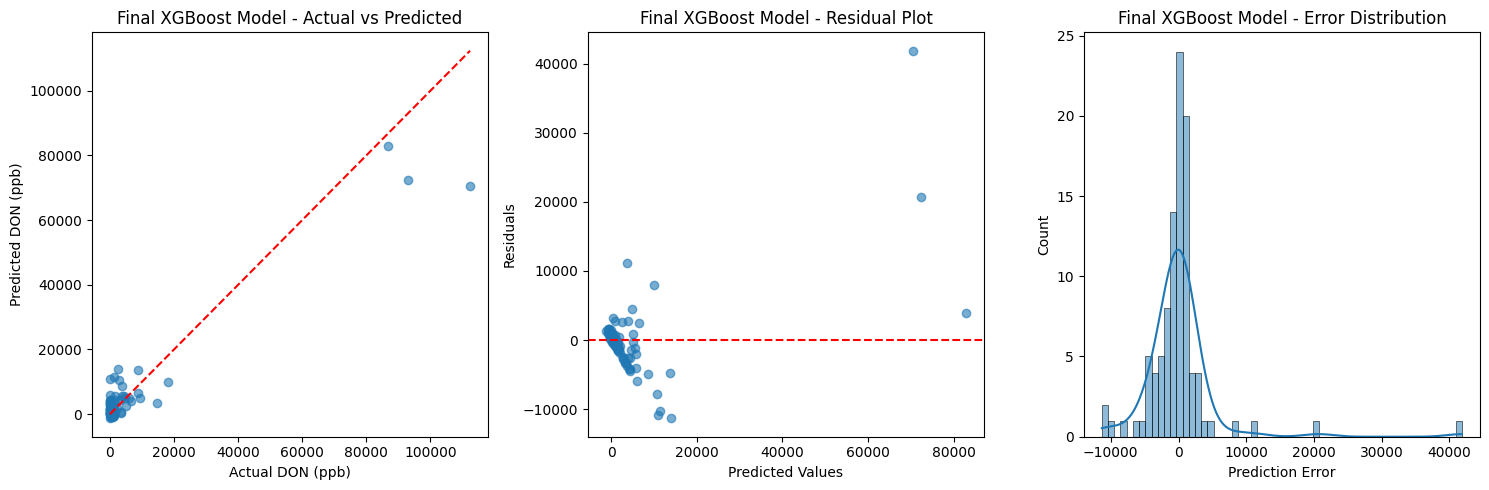

<Figure size 1000x800 with 0 Axes>

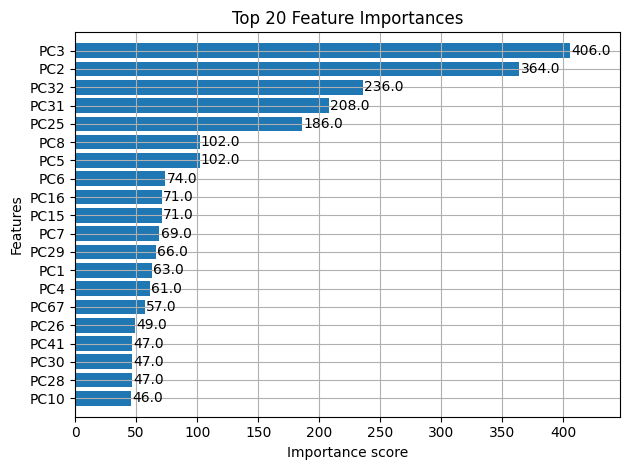

/tmp/ipykernel_2213027/2093575210.py:223: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=20)


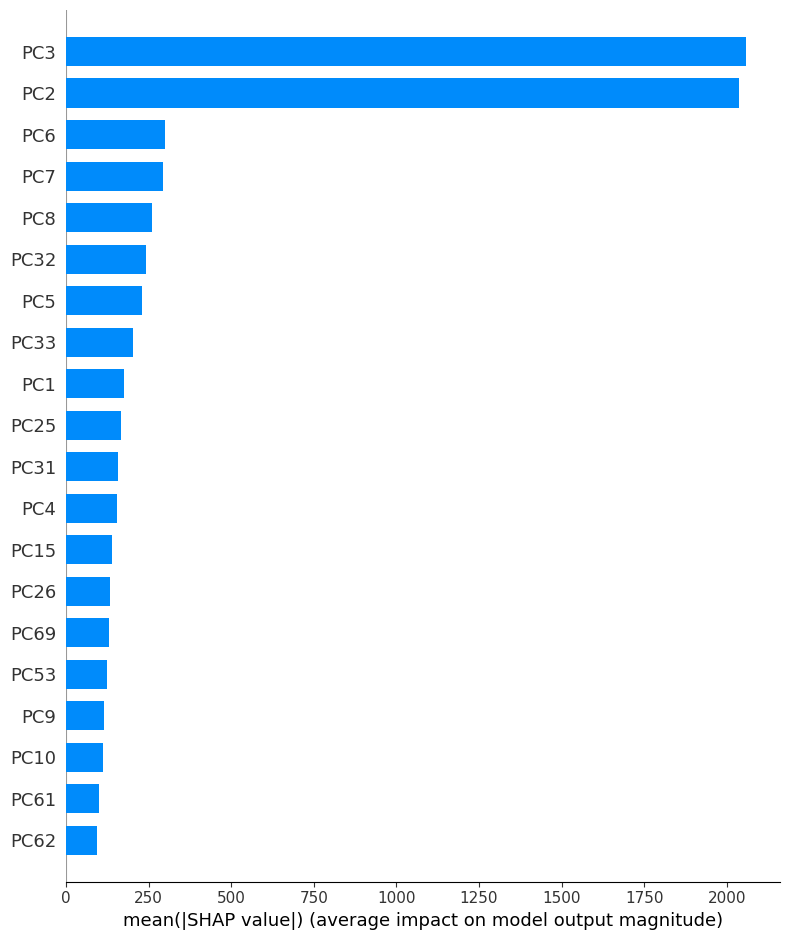

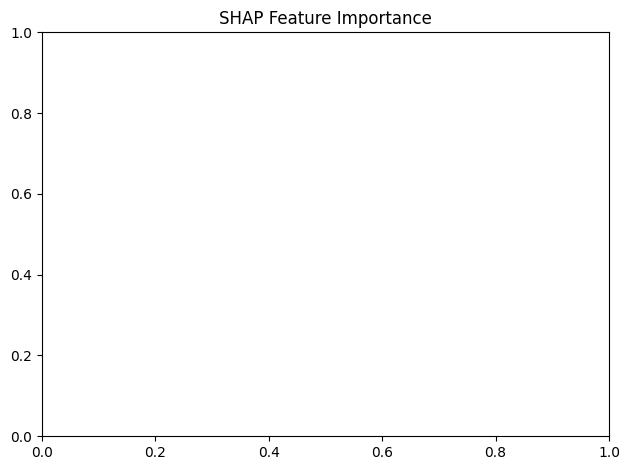

/tmp/ipykernel_2213027/2093575210.py:230: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train, max_display=10)


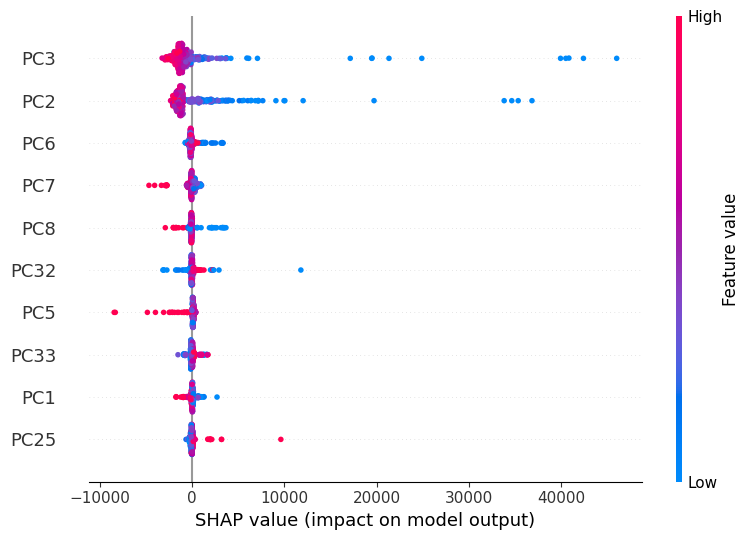

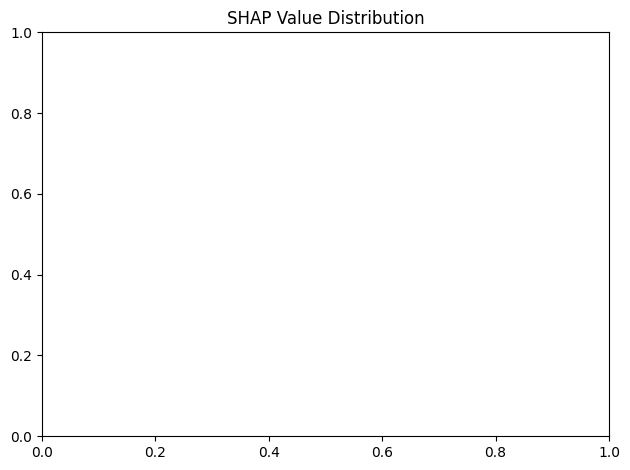

Sample prediction: 736.32 ppb
Final Model Performance Summary:


,Metric,Value
0,Cross-Validated RMSE,6685.931601
1,Test MAE,2540.090928
2,Test RMSE,5602.773071
3,Test R²,0.887702



Top 10 Features:


,Feature,Importance
2,PC3,0.189691
32,PC33,0.109957
1,PC2,0.060464
52,PC53,0.056767
5,PC6,0.055127
59,PC60,0.044180
21,PC22,0.041453
0,PC1,0.031331
58,PC59,0.030193
9,PC10,0.026973


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import shap
import joblib
import optuna
from optuna.samplers import TPESampler

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# %% [markdown]
"""
## 1. Load Preprocessed Data
"""
# %%
# Load the preprocessed data
X_train = pd.read_csv("../data/processed/x_train.csv")
X_test = pd.read_csv("../data/processed/x_test.csv")
y_train = pd.read_csv("../data/processed/y_train.csv")
y_test = pd.read_csv("../data/processed/y_test.csv")

# Verify shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Prepare data (remove hsi_id)
X_train = X_train.drop(columns=['hsi_id'])
X_test = X_test.drop(columns=['hsi_id'])
y_train = y_train['vomitoxin_ppb']
y_test = y_test['vomitoxin_ppb']

# %% [markdown]
"""
## 2. Baseline Model (XGBoost)
"""
# %%
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Evaluate model using cross-validation and test set"""
    # Cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = cross_val_score(
        model, X_train, y_train, 
        cv=cv, 
        scoring='neg_mean_squared_error',
        n_jobs=8
    )
    rmse_scores = np.sqrt(-cv_scores)
    
    # Test set evaluation
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'CV_RMSE_mean': rmse_scores.mean(),
        'CV_RMSE_std': rmse_scores.std(),
        'Test_MAE': mean_absolute_error(y_test, y_pred),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'Test_R2': r2_score(y_test, y_pred)
    }
    
    return metrics, y_pred

# %%
# Initialize baseline XGBoost model
xgb_baseline = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    max_depth=5,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=8
)

# Evaluate baseline model
xgb_metrics, xgb_pred = evaluate_model(xgb_baseline, X_train, y_train, X_test, y_test)

# Display results
print("XGBoost Baseline Performance:")
display(pd.DataFrame([xgb_metrics]))

# %% [markdown]
"""
## 3. Hyperparameter Tuning with Optuna
"""
# %%
def objective(trial):
    """Objective function for Optuna optimization"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    
    model = xgb.XGBRegressor(
        **params,
        objective='reg:squarederror',
        random_state=RANDOM_STATE,
        n_jobs=8
    )
    
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    score = cross_val_score(
        model, X_train, y_train,
        cv=cv,
        scoring='neg_mean_squared_error',
        n_jobs=8
    ).mean()
    
    return np.sqrt(-score)

# %%
# Run optimization
study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=RANDOM_STATE)
)
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Display best parameters
print("Best trial:")
trial = study.best_trial
print(f"RMSE: {trial.value:.4f}")
print("Best parameters:")
print(trial.params)

# %% [markdown]
"""
## 4. Train Final Model with Best Parameters
"""
# %%
# Train final model with best parameters
best_params = trial.params
final_model = xgb.XGBRegressor(
    **best_params,
    objective='reg:squarederror',
    random_state=RANDOM_STATE,
    n_jobs=8
)

final_metrics, final_pred = evaluate_model(final_model, X_train, y_train, X_test, y_test)

# Display final performance
print("Final Model Performance:")
display(pd.DataFrame([final_metrics]))

# Save the final model
joblib.dump(final_model, '../data/models/best_xgboost_model.pkl')

# %% [markdown]
"""
## 5. Model Evaluation Visualizations
"""
# %%
def plot_results(y_true, y_pred, model_name):
    """Create evaluation plots"""
    plt.figure(figsize=(15, 5))
    
    # Actual vs Predicted
    plt.subplot(1, 3, 1)
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Actual DON (ppb)')
    plt.ylabel('Predicted DON (ppb)')
    plt.title(f'{model_name} - Actual vs Predicted')
    
    # Residuals
    residuals = y_true - y_pred
    plt.subplot(1, 3, 2)
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Residual Plot')
    
    # Error Distribution
    plt.subplot(1, 3, 3)
    sns.histplot(residuals, kde=True)
    plt.xlabel('Prediction Error')
    plt.title(f'{model_name} - Error Distribution')
    
    plt.tight_layout()
    plt.show()

# Generate plots
plot_results(y_test, final_pred, "Final XGBoost Model")

# %% [markdown]
"""
## 6. Feature Importance & Interpretability
"""
# %%
# Feature Importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(final_model, max_num_features=20, height=0.8)
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

# SHAP Analysis
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train)

# Summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=20)
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()

# Detailed SHAP plot for top features
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train, max_display=10)
plt.title('SHAP Value Distribution')
plt.tight_layout()
plt.show()

# %% [markdown]
"""
## 7. Prepare Production Pipeline
"""
# %%
# Create prediction function
def predict_don(features):
    """Predict DON concentration from spectral features"""
    # Load model if not already loaded
    if 'final_model' not in globals():
        global final_model  # Add global declaration
        final_model = joblib.load('../data/models/best_xgboost_model.pkl')
    
    # Convert to numpy array and reshape
    features = np.array(features).reshape(1, -1)
    
    # Make prediction
    return float(final_model.predict(features)[0])

# Test the function
sample_features = X_train.iloc[0].values
print(f"Sample prediction: {predict_don(sample_features):.2f} ppb")

# Save SHAP explainer
joblib.dump(explainer, '../data/models/shap_explainer.pkl')

# %% [markdown]
"""
## 8. Final Performance Report
"""
# %%
# Create performance dataframe
performance_df = pd.DataFrame({
    'Metric': ['Cross-Validated RMSE', 'Test MAE', 'Test RMSE', 'Test R²'],
    'Value': [
        final_metrics['CV_RMSE_mean'],
        final_metrics['Test_MAE'],
        final_metrics['Test_RMSE'],
        final_metrics['Test_R2']
    ]
})

print("Final Model Performance Summary:")
display(performance_df)

# %%
# Feature importance dataframe
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features:")
display(feature_importance.head(10))

X_train shape: (395, 71)
X_test shape: (100, 71)
y_train shape: (395, 2)
y_test shape: (100, 2)
XGBoost Baseline Performance:


,CV_RMSE_mean,CV_RMSE_std,Test_MAE,Test_RMSE,Test_R2
0,7346.202733,4569.841452,2435.782413,7679.777382,0.789009


[I 2025-03-31 04:21:19,526] A new study created in memory with name: no-name-fd19eaff-aee1-4c5c-ac0d-e186f097b53b
Best trial: 0. Best value: 8638.2:   2%|▏         | 1/50 [00:01<01:34,  1.93s/it]

[I 2025-03-31 04:21:21,450] Trial 0 finished with value: 8638.195021106209 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.02904180608409973, 'reg_alpha': 0.8661761457749352, 'reg_lambda': 0.6011150117432088}. Best is trial 0 with value: 8638.195021106209.


Best trial: 1. Best value: 8472.02:   4%|▍         | 2/50 [00:02<01:04,  1.34s/it]

[I 2025-03-31 04:21:22,376] Trial 1 finished with value: 8472.01510346909 and parameters: {'n_estimators': 383, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'min_child_weight': 2, 'gamma': 0.09170225492671691, 'reg_alpha': 0.3042422429595377, 'reg_lambda': 0.5247564316322378}. Best is trial 1 with value: 8472.01510346909.


Best trial: 2. Best value: 8366.58:   6%|▌         | 3/50 [00:03<00:42,  1.09it/s]

[I 2025-03-31 04:21:22,788] Trial 2 finished with value: 8366.580089959643 and parameters: {'n_estimators': 273, 'max_depth': 5, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_bytree': 0.7168578594140873, 'min_child_weight': 4, 'gamma': 0.22803499210851796, 'reg_alpha': 0.7851759613930136, 'reg_lambda': 0.19967378215835974}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:   8%|▊         | 4/50 [00:04<00:43,  1.06it/s]

[I 2025-03-31 04:21:23,774] Trial 3 finished with value: 8562.056737865132 and parameters: {'n_estimators': 306, 'max_depth': 7, 'learning_rate': 0.011711509955524094, 'subsample': 0.8430179407605753, 'colsample_bytree': 0.6682096494749166, 'min_child_weight': 1, 'gamma': 0.4744427686266666, 'reg_alpha': 0.9656320330745594, 'reg_lambda': 0.8083973481164611}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  10%|█         | 5/50 [00:04<00:30,  1.47it/s]

[I 2025-03-31 04:21:23,993] Trial 4 finished with value: 8623.008711826451 and parameters: {'n_estimators': 222, 'max_depth': 3, 'learning_rate': 0.1024932221692416, 'subsample': 0.7760609974958406, 'colsample_bytree': 0.6488152939379115, 'min_child_weight': 5, 'gamma': 0.017194260557609198, 'reg_alpha': 0.9093204020787821, 'reg_lambda': 0.2587799816000169}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  12%|█▏        | 6/50 [00:04<00:26,  1.63it/s]

[I 2025-03-31 04:21:24,474] Trial 5 finished with value: 9054.103192813573 and parameters: {'n_estimators': 365, 'max_depth': 5, 'learning_rate': 0.05864129169696527, 'subsample': 0.8186841117373118, 'colsample_bytree': 0.6739417822102108, 'min_child_weight': 10, 'gamma': 0.3875664116805573, 'reg_alpha': 0.9394989415641891, 'reg_lambda': 0.8948273504276488}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  14%|█▍        | 7/50 [00:05<00:31,  1.35it/s]

[I 2025-03-31 04:21:25,480] Trial 6 finished with value: 8834.445348039533 and parameters: {'n_estimators': 339, 'max_depth': 10, 'learning_rate': 0.01351182947645082, 'subsample': 0.6783931449676581, 'colsample_bytree': 0.6180909155642152, 'min_child_weight': 4, 'gamma': 0.194338644844741, 'reg_alpha': 0.2713490317738959, 'reg_lambda': 0.8287375091519293}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  16%|█▌        | 8/50 [00:06<00:28,  1.49it/s]

[I 2025-03-31 04:21:26,001] Trial 7 finished with value: 9252.97775763449 and parameters: {'n_estimators': 243, 'max_depth': 5, 'learning_rate': 0.06333268775321842, 'subsample': 0.6563696899899051, 'colsample_bytree': 0.9208787923016158, 'min_child_weight': 1, 'gamma': 0.49344346830025865, 'reg_alpha': 0.7722447692966574, 'reg_lambda': 0.1987156815341724}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  18%|█▊        | 9/50 [00:07<00:26,  1.58it/s]

[I 2025-03-31 04:21:26,554] Trial 8 finished with value: 9066.121488886556 and parameters: {'n_estimators': 102, 'max_depth': 9, 'learning_rate': 0.11069143219393454, 'subsample': 0.8916028672163949, 'colsample_bytree': 0.9085081386743783, 'min_child_weight': 1, 'gamma': 0.1792328642721363, 'reg_alpha': 0.11586905952512971, 'reg_lambda': 0.8631034258755935}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  20%|██        | 10/50 [00:07<00:23,  1.67it/s]

[I 2025-03-31 04:21:27,075] Trial 9 finished with value: 9161.886163244382 and parameters: {'n_estimators': 349, 'max_depth': 5, 'learning_rate': 0.012413189635294229, 'subsample': 0.7243929286862649, 'colsample_bytree': 0.7300733288106989, 'min_child_weight': 8, 'gamma': 0.31877873567760656, 'reg_alpha': 0.8872127425763265, 'reg_lambda': 0.4722149251619493}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  22%|██▏       | 11/50 [00:08<00:26,  1.48it/s]

[I 2025-03-31 04:21:27,928] Trial 10 finished with value: 8579.73625542719 and parameters: {'n_estimators': 478, 'max_depth': 7, 'learning_rate': 0.028477486830279865, 'subsample': 0.6071847502459278, 'colsample_bytree': 0.8010124870699185, 'min_child_weight': 7, 'gamma': 0.2760977256675942, 'reg_alpha': 0.6240835271723653, 'reg_lambda': 0.039907535719484855}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  24%|██▍       | 12/50 [00:08<00:23,  1.63it/s]

[I 2025-03-31 04:21:28,399] Trial 11 finished with value: 8583.825992346703 and parameters: {'n_estimators': 462, 'max_depth': 3, 'learning_rate': 0.24950292438859506, 'subsample': 0.9687557027925864, 'colsample_bytree': 0.7737425087025644, 'min_child_weight': 3, 'gamma': 0.12003329156932674, 'reg_alpha': 0.4182682716196848, 'reg_lambda': 0.46994321499695574}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  26%|██▌       | 13/50 [00:09<00:20,  1.79it/s]

[I 2025-03-31 04:21:28,831] Trial 12 finished with value: 8546.500314147888 and parameters: {'n_estimators': 418, 'max_depth': 4, 'learning_rate': 0.27675589864710687, 'subsample': 0.9994636029283407, 'colsample_bytree': 0.8404427663008558, 'min_child_weight': 4, 'gamma': 0.09695084439740809, 'reg_alpha': 0.5245057886624165, 'reg_lambda': 0.2944068495666103}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  28%|██▊       | 14/50 [00:09<00:16,  2.19it/s]

[I 2025-03-31 04:21:29,049] Trial 13 finished with value: 8847.163199715804 and parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.02984224442314634, 'subsample': 0.9199690201206847, 'colsample_bytree': 0.7286923691999561, 'min_child_weight': 6, 'gamma': 0.21454949780832402, 'reg_alpha': 0.3091339583045281, 'reg_lambda': 0.64208794318194}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  30%|███       | 15/50 [00:10<00:19,  1.79it/s]

[I 2025-03-31 04:21:29,840] Trial 14 finished with value: 8488.006240212499 and parameters: {'n_estimators': 392, 'max_depth': 6, 'learning_rate': 0.17080659935001277, 'subsample': 0.7507711462516721, 'colsample_bytree': 0.9840998651516013, 'min_child_weight': 3, 'gamma': 0.12417011982640969, 'reg_alpha': 0.689155822984862, 'reg_lambda': 0.09086840375111387}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  32%|███▏      | 16/50 [00:10<00:16,  2.03it/s]

[I 2025-03-31 04:21:30,182] Trial 15 finished with value: 8590.865789113861 and parameters: {'n_estimators': 270, 'max_depth': 3, 'learning_rate': 0.03545757434511042, 'subsample': 0.9063978236539806, 'colsample_bytree': 0.716507181535291, 'min_child_weight': 3, 'gamma': 0.3343228607836479, 'reg_alpha': 0.010065752312506171, 'reg_lambda': 0.43451435782595793}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  34%|███▍      | 17/50 [00:11<00:18,  1.81it/s]

[I 2025-03-31 04:21:30,873] Trial 16 finished with value: 9244.905607449959 and parameters: {'n_estimators': 434, 'max_depth': 6, 'learning_rate': 0.17382062178166294, 'subsample': 0.60195639766132, 'colsample_bytree': 0.6034370752877032, 'min_child_weight': 5, 'gamma': 0.06408681310221985, 'reg_alpha': 0.47866936071859034, 'reg_lambda': 0.3583902847905417}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  36%|███▌      | 18/50 [00:11<00:15,  2.11it/s]

[I 2025-03-31 04:21:31,168] Trial 17 finished with value: 8786.508527842629 and parameters: {'n_estimators': 185, 'max_depth': 4, 'learning_rate': 0.07501028782219026, 'subsample': 0.7041942338938955, 'colsample_bytree': 0.7801614469884962, 'min_child_weight': 2, 'gamma': 0.15682482142699825, 'reg_alpha': 0.2567069389694278, 'reg_lambda': 0.6556498190600932}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  38%|███▊      | 19/50 [00:12<00:17,  1.73it/s]

[I 2025-03-31 04:21:31,990] Trial 18 finished with value: 8383.238446494535 and parameters: {'n_estimators': 328, 'max_depth': 8, 'learning_rate': 0.020038260312712813, 'subsample': 0.8731407435344102, 'colsample_bytree': 0.8416634198004798, 'min_child_weight': 6, 'gamma': 0.2470634592056546, 'reg_alpha': 0.6134917963094769, 'reg_lambda': 0.1643967376099853}. Best is trial 2 with value: 8366.580089959643.


Best trial: 19. Best value: 8291.2:  40%|████      | 20/50 [00:13<00:18,  1.60it/s]

[I 2025-03-31 04:21:32,729] Trial 19 finished with value: 8291.200100427684 and parameters: {'n_estimators': 299, 'max_depth': 8, 'learning_rate': 0.019835286801746912, 'subsample': 0.870443990178826, 'colsample_bytree': 0.8511027556947152, 'min_child_weight': 8, 'gamma': 0.24910251226588562, 'reg_alpha': 0.726775165034454, 'reg_lambda': 0.11163809391005666}. Best is trial 19 with value: 8291.200100427684.


Best trial: 19. Best value: 8291.2:  42%|████▏     | 21/50 [00:13<00:19,  1.52it/s]

[I 2025-03-31 04:21:33,452] Trial 20 finished with value: 8631.789484232464 and parameters: {'n_estimators': 287, 'max_depth': 8, 'learning_rate': 0.04151929443699016, 'subsample': 0.7749267580172707, 'colsample_bytree': 0.8782980385513112, 'min_child_weight': 9, 'gamma': 0.3972276294870267, 'reg_alpha': 0.7358065279607223, 'reg_lambda': 0.016335300753528487}. Best is trial 19 with value: 8291.200100427684.


Best trial: 21. Best value: 8132.81:  44%|████▍     | 22/50 [00:14<00:19,  1.45it/s]

[I 2025-03-31 04:21:34,228] Trial 21 finished with value: 8132.806286610395 and parameters: {'n_estimators': 310, 'max_depth': 8, 'learning_rate': 0.019165284053326084, 'subsample': 0.8795510218705594, 'colsample_bytree': 0.8431986333388165, 'min_child_weight': 7, 'gamma': 0.2523571380476008, 'reg_alpha': 0.6359949606640374, 'reg_lambda': 0.15774579155681345}. Best is trial 21 with value: 8132.806286610395.


Best trial: 21. Best value: 8132.81:  46%|████▌     | 23/50 [00:15<00:17,  1.52it/s]

[I 2025-03-31 04:21:34,810] Trial 22 finished with value: 8642.802389394203 and parameters: {'n_estimators': 216, 'max_depth': 8, 'learning_rate': 0.017953064228077485, 'subsample': 0.8699627806602964, 'colsample_bytree': 0.8182044081145493, 'min_child_weight': 8, 'gamma': 0.25378466661013505, 'reg_alpha': 0.8089296207624268, 'reg_lambda': 0.13216827715702517}. Best is trial 21 with value: 8132.806286610395.


Best trial: 23. Best value: 8103.63:  48%|████▊     | 24/50 [00:15<00:17,  1.51it/s]

[I 2025-03-31 04:21:35,483] Trial 23 finished with value: 8103.634226976151 and parameters: {'n_estimators': 310, 'max_depth': 7, 'learning_rate': 0.02027693372057436, 'subsample': 0.811546408077755, 'colsample_bytree': 0.8893393991411527, 'min_child_weight': 7, 'gamma': 0.2996907034831955, 'reg_alpha': 0.6643192667362228, 'reg_lambda': 0.24351001160119423}. Best is trial 23 with value: 8103.634226976151.


Best trial: 23. Best value: 8103.63:  50%|█████     | 25/50 [00:16<00:18,  1.35it/s]

[I 2025-03-31 04:21:36,397] Trial 24 finished with value: 8143.488519181019 and parameters: {'n_estimators': 312, 'max_depth': 9, 'learning_rate': 0.01746390206593181, 'subsample': 0.7974115816012433, 'colsample_bytree': 0.9693997538611993, 'min_child_weight': 7, 'gamma': 0.2940290169007296, 'reg_alpha': 0.621885196948374, 'reg_lambda': 0.31940266864774947}. Best is trial 23 with value: 8103.634226976151.


Best trial: 23. Best value: 8103.63:  52%|█████▏    | 26/50 [00:17<00:19,  1.23it/s]

[I 2025-03-31 04:21:37,379] Trial 25 finished with value: 8322.26095996502 and parameters: {'n_estimators': 313, 'max_depth': 9, 'learning_rate': 0.015438060453532288, 'subsample': 0.7859717994686578, 'colsample_bytree': 0.9700505870963767, 'min_child_weight': 7, 'gamma': 0.30359325414134236, 'reg_alpha': 0.5403587563277911, 'reg_lambda': 0.33881764048915847}. Best is trial 23 with value: 8103.634226976151.


Best trial: 26. Best value: 7894.97:  54%|█████▍    | 27/50 [00:18<00:20,  1.13it/s]

[I 2025-03-31 04:21:38,434] Trial 26 finished with value: 7894.9704052679745 and parameters: {'n_estimators': 367, 'max_depth': 9, 'learning_rate': 0.02455539659095544, 'subsample': 0.8202905329770378, 'colsample_bytree': 0.9551693140210797, 'min_child_weight': 7, 'gamma': 0.379473387715081, 'reg_alpha': 0.6295300380602712, 'reg_lambda': 0.3648675951229743}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  56%|█████▌    | 28/50 [00:19<00:19,  1.13it/s]

[I 2025-03-31 04:21:39,313] Trial 27 finished with value: 8328.701093087313 and parameters: {'n_estimators': 410, 'max_depth': 7, 'learning_rate': 0.02344313028752466, 'subsample': 0.8433487490568512, 'colsample_bytree': 0.9340226024611946, 'min_child_weight': 9, 'gamma': 0.3630964637798527, 'reg_alpha': 0.4288084220895492, 'reg_lambda': 0.2439066039400356}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  58%|█████▊    | 29/50 [00:20<00:19,  1.06it/s]

[I 2025-03-31 04:21:40,391] Trial 28 finished with value: 8434.185291826305 and parameters: {'n_estimators': 357, 'max_depth': 9, 'learning_rate': 0.01005245985163312, 'subsample': 0.81144645662038, 'colsample_bytree': 0.8862837162443185, 'min_child_weight': 6, 'gamma': 0.4386959993167423, 'reg_alpha': 0.6713654870569534, 'reg_lambda': 0.3824329530215289}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  60%|██████    | 30/50 [00:21<00:18,  1.08it/s]

[I 2025-03-31 04:21:41,267] Trial 29 finished with value: 7937.853768698042 and parameters: {'n_estimators': 247, 'max_depth': 10, 'learning_rate': 0.043704424980366925, 'subsample': 0.9458109099507797, 'colsample_bytree': 0.9540253388646004, 'min_child_weight': 7, 'gamma': 0.3478809264812017, 'reg_alpha': 0.8398384561816131, 'reg_lambda': 0.5746972042991608}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  62%|██████▏   | 31/50 [00:22<00:16,  1.14it/s]

[I 2025-03-31 04:21:42,046] Trial 30 finished with value: 8039.75143070421 and parameters: {'n_estimators': 247, 'max_depth': 10, 'learning_rate': 0.04476063340840976, 'subsample': 0.9486874886875832, 'colsample_bytree': 0.9508318266871417, 'min_child_weight': 9, 'gamma': 0.43095381424413115, 'reg_alpha': 0.8496186588837124, 'reg_lambda': 0.7471803788285408}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  64%|██████▍   | 32/50 [00:23<00:15,  1.17it/s]

[I 2025-03-31 04:21:42,831] Trial 31 finished with value: 8451.840705469795 and parameters: {'n_estimators': 242, 'max_depth': 10, 'learning_rate': 0.04429505667620125, 'subsample': 0.9504766617230207, 'colsample_bytree': 0.942296042843562, 'min_child_weight': 10, 'gamma': 0.43486586390343845, 'reg_alpha': 0.8521482557007041, 'reg_lambda': 0.728514692891076}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  66%|██████▌   | 33/50 [00:23<00:13,  1.28it/s]

[I 2025-03-31 04:21:43,447] Trial 32 finished with value: 8078.784705294576 and parameters: {'n_estimators': 190, 'max_depth': 10, 'learning_rate': 0.04687612213972545, 'subsample': 0.9761269960169491, 'colsample_bytree': 0.9948223631776224, 'min_child_weight': 9, 'gamma': 0.359337732370985, 'reg_alpha': 0.845103444545872, 'reg_lambda': 0.995694986576965}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  68%|██████▊   | 34/50 [00:24<00:11,  1.36it/s]

[I 2025-03-31 04:21:44,074] Trial 33 finished with value: 8205.149847935309 and parameters: {'n_estimators': 177, 'max_depth': 10, 'learning_rate': 0.0472039619572555, 'subsample': 0.9803759258013781, 'colsample_bytree': 0.9528523377437574, 'min_child_weight': 9, 'gamma': 0.34865288356978535, 'reg_alpha': 0.9989345502575097, 'reg_lambda': 0.5451010570036033}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  70%|███████   | 35/50 [00:25<00:10,  1.40it/s]

[I 2025-03-31 04:21:44,744] Trial 34 finished with value: 8269.906729784172 and parameters: {'n_estimators': 198, 'max_depth': 10, 'learning_rate': 0.03365950523517799, 'subsample': 0.944889902362251, 'colsample_bytree': 0.9875345063356818, 'min_child_weight': 9, 'gamma': 0.41729127693192486, 'reg_alpha': 0.8475239927087462, 'reg_lambda': 0.761320208044043}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 35. Best value: 7847.44:  72%|███████▏  | 36/50 [00:25<00:10,  1.38it/s]

[I 2025-03-31 04:21:45,499] Trial 35 finished with value: 7847.442398954651 and parameters: {'n_estimators': 222, 'max_depth': 10, 'learning_rate': 0.052417734528796237, 'subsample': 0.9267245786655629, 'colsample_bytree': 0.9951316684720198, 'min_child_weight': 8, 'gamma': 0.36923488203789073, 'reg_alpha': 0.8220440117361256, 'reg_lambda': 0.9819228559103086}. Best is trial 35 with value: 7847.442398954651.


Best trial: 35. Best value: 7847.44:  74%|███████▍  | 37/50 [00:26<00:09,  1.35it/s]

[I 2025-03-31 04:21:46,274] Trial 36 finished with value: 7880.222289762415 and parameters: {'n_estimators': 267, 'max_depth': 9, 'learning_rate': 0.06692416219804206, 'subsample': 0.929034957333791, 'colsample_bytree': 0.9596705099258309, 'min_child_weight': 8, 'gamma': 0.46234598188704285, 'reg_alpha': 0.9399244877698414, 'reg_lambda': 0.9995651517192231}. Best is trial 35 with value: 7847.442398954651.


Best trial: 35. Best value: 7847.44:  76%|███████▌  | 38/50 [00:27<00:08,  1.37it/s]

[I 2025-03-31 04:21:46,980] Trial 37 finished with value: 7877.18808995718 and parameters: {'n_estimators': 271, 'max_depth': 9, 'learning_rate': 0.08507333186533964, 'subsample': 0.9273783023579116, 'colsample_bytree': 0.9198658228968843, 'min_child_weight': 8, 'gamma': 0.47215426393219306, 'reg_alpha': 0.9818540631463812, 'reg_lambda': 0.9042423150777893}. Best is trial 35 with value: 7847.442398954651.


Best trial: 38. Best value: 7567.79:  78%|███████▊  | 39/50 [00:28<00:08,  1.36it/s]

[I 2025-03-31 04:21:47,725] Trial 38 finished with value: 7567.7866484916085 and parameters: {'n_estimators': 272, 'max_depth': 9, 'learning_rate': 0.08721830998229096, 'subsample': 0.8445776396190179, 'colsample_bytree': 0.9129328155280088, 'min_child_weight': 8, 'gamma': 0.4751758762823277, 'reg_alpha': 0.9198429847259147, 'reg_lambda': 0.9810362483082278}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  80%|████████  | 40/50 [00:28<00:07,  1.36it/s]

[I 2025-03-31 04:21:48,459] Trial 39 finished with value: 7794.131898461793 and parameters: {'n_estimators': 278, 'max_depth': 9, 'learning_rate': 0.08874461090684191, 'subsample': 0.9152599077825478, 'colsample_bytree': 0.9170446120935413, 'min_child_weight': 8, 'gamma': 0.4683824685263483, 'reg_alpha': 0.935139443129884, 'reg_lambda': 0.9995868531183777}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  82%|████████▏ | 41/50 [00:29<00:06,  1.44it/s]

[I 2025-03-31 04:21:49,063] Trial 40 finished with value: 8600.865075516826 and parameters: {'n_estimators': 219, 'max_depth': 9, 'learning_rate': 0.08316299933963785, 'subsample': 0.8503275295705586, 'colsample_bytree': 0.9184037171978066, 'min_child_weight': 10, 'gamma': 0.49405882847356813, 'reg_alpha': 0.9886694766383121, 'reg_lambda': 0.9152777468148677}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  84%|████████▍ | 42/50 [00:30<00:05,  1.38it/s]

[I 2025-03-31 04:21:49,848] Trial 41 finished with value: 7872.381218552118 and parameters: {'n_estimators': 267, 'max_depth': 9, 'learning_rate': 0.09243048975830637, 'subsample': 0.9189966603111114, 'colsample_bytree': 0.9059453379839171, 'min_child_weight': 8, 'gamma': 0.46608004422355087, 'reg_alpha': 0.9244250194795443, 'reg_lambda': 0.9938794998450424}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  86%|████████▌ | 43/50 [00:31<00:05,  1.33it/s]

[I 2025-03-31 04:21:50,665] Trial 42 finished with value: 7870.625900581136 and parameters: {'n_estimators': 283, 'max_depth': 9, 'learning_rate': 0.09195561498299554, 'subsample': 0.9051744119181657, 'colsample_bytree': 0.8990258147943231, 'min_child_weight': 8, 'gamma': 0.462742033507158, 'reg_alpha': 0.9282865519830986, 'reg_lambda': 0.9548325487893339}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  88%|████████▊ | 44/50 [00:31<00:04,  1.43it/s]

[I 2025-03-31 04:21:51,238] Trial 43 finished with value: 7821.466740387789 and parameters: {'n_estimators': 233, 'max_depth': 8, 'learning_rate': 0.13512620686940155, 'subsample': 0.9016480815876093, 'colsample_bytree': 0.8717722813971821, 'min_child_weight': 8, 'gamma': 0.46516801790266293, 'reg_alpha': 0.9117864760777536, 'reg_lambda': 0.9434374340022391}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  90%|█████████ | 45/50 [00:32<00:03,  1.41it/s]

[I 2025-03-31 04:21:51,975] Trial 44 finished with value: 7677.667630618341 and parameters: {'n_estimators': 286, 'max_depth': 8, 'learning_rate': 0.1339718885947025, 'subsample': 0.8991493176628343, 'colsample_bytree': 0.8568744028318359, 'min_child_weight': 8, 'gamma': 0.40792217479506815, 'reg_alpha': 0.9022088127954687, 'reg_lambda': 0.9391254156410259}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  92%|█████████▏| 46/50 [00:32<00:02,  1.59it/s]

[I 2025-03-31 04:21:52,419] Trial 45 finished with value: 8592.112164293065 and parameters: {'n_estimators': 166, 'max_depth': 8, 'learning_rate': 0.1395890384378099, 'subsample': 0.8955476349130974, 'colsample_bytree': 0.8674756823068144, 'min_child_weight': 10, 'gamma': 0.4162252440092521, 'reg_alpha': 0.8887616560967914, 'reg_lambda': 0.8302952539048541}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  94%|█████████▍| 47/50 [00:33<00:01,  1.79it/s]

[I 2025-03-31 04:21:52,816] Trial 46 finished with value: 8093.370213981029 and parameters: {'n_estimators': 148, 'max_depth': 8, 'learning_rate': 0.12412693607355021, 'subsample': 0.8303731805695322, 'colsample_bytree': 0.8650037239808243, 'min_child_weight': 6, 'gamma': 0.3986627191181256, 'reg_alpha': 0.7447412632984255, 'reg_lambda': 0.9385298345333704}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  96%|█████████▌| 48/50 [00:33<00:01,  1.80it/s]

[I 2025-03-31 04:21:53,359] Trial 47 finished with value: 7948.394798382668 and parameters: {'n_estimators': 232, 'max_depth': 7, 'learning_rate': 0.14723290295091088, 'subsample': 0.8638600927521128, 'colsample_bytree': 0.8283143404468539, 'min_child_weight': 8, 'gamma': 0.4885642516506967, 'reg_alpha': 0.8020990442443177, 'reg_lambda': 0.8607865434732835}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  98%|█████████▊| 49/50 [00:34<00:00,  1.80it/s]

[I 2025-03-31 04:21:53,914] Trial 48 finished with value: 8535.424186917573 and parameters: {'n_estimators': 210, 'max_depth': 8, 'learning_rate': 0.1943505342856819, 'subsample': 0.8861079170146087, 'colsample_bytree': 0.7974251183637835, 'min_child_weight': 5, 'gamma': 0.4477596743740228, 'reg_alpha': 0.8932992029485292, 'reg_lambda': 0.8822269978191468}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79: 100%|██████████| 50/50 [00:35<00:00,  1.43it/s]


[I 2025-03-31 04:21:54,526] Trial 49 finished with value: 7952.656484450488 and parameters: {'n_estimators': 338, 'max_depth': 6, 'learning_rate': 0.10732149127397309, 'subsample': 0.9028617359685179, 'colsample_bytree': 0.9284959909506965, 'min_child_weight': 9, 'gamma': 0.41237401844317295, 'reg_alpha': 0.9510589400102264, 'reg_lambda': 0.9523201787651652}. Best is trial 38 with value: 7567.7866484916085.
Best trial:
RMSE: 7567.7866
Best parameters:
{'n_estimators': 272, 'max_depth': 9, 'learning_rate': 0.08721830998229096, 'subsample': 0.8445776396190179, 'colsample_bytree': 0.9129328155280088, 'min_child_weight': 8, 'gamma': 0.4751758762823277, 'reg_alpha': 0.9198429847259147, 'reg_lambda': 0.9810362483082278}
Final Model Performance:


,CV_RMSE_mean,CV_RMSE_std,Test_MAE,Test_RMSE,Test_R2
0,6685.931601,3545.37916,2540.090928,5602.773071,0.887702


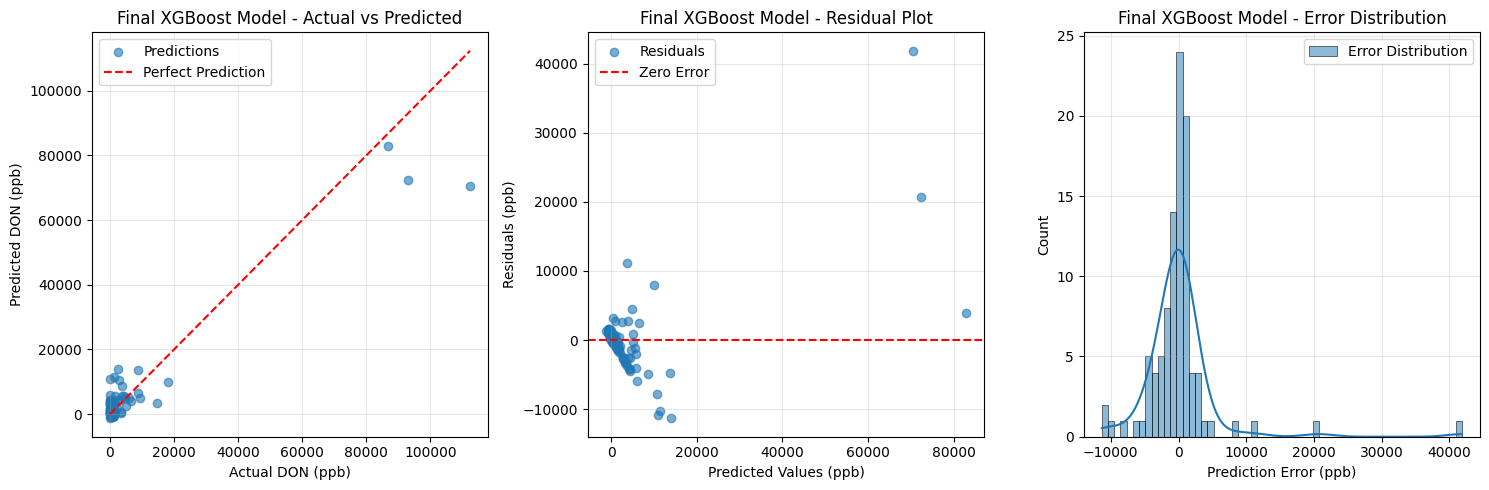

<Figure size 1000x800 with 0 Axes>

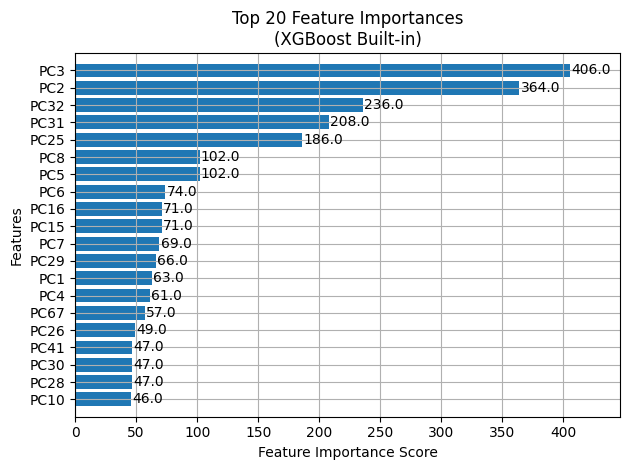

/tmp/ipykernel_2213027/4133508027.py:191: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=20, show=False)


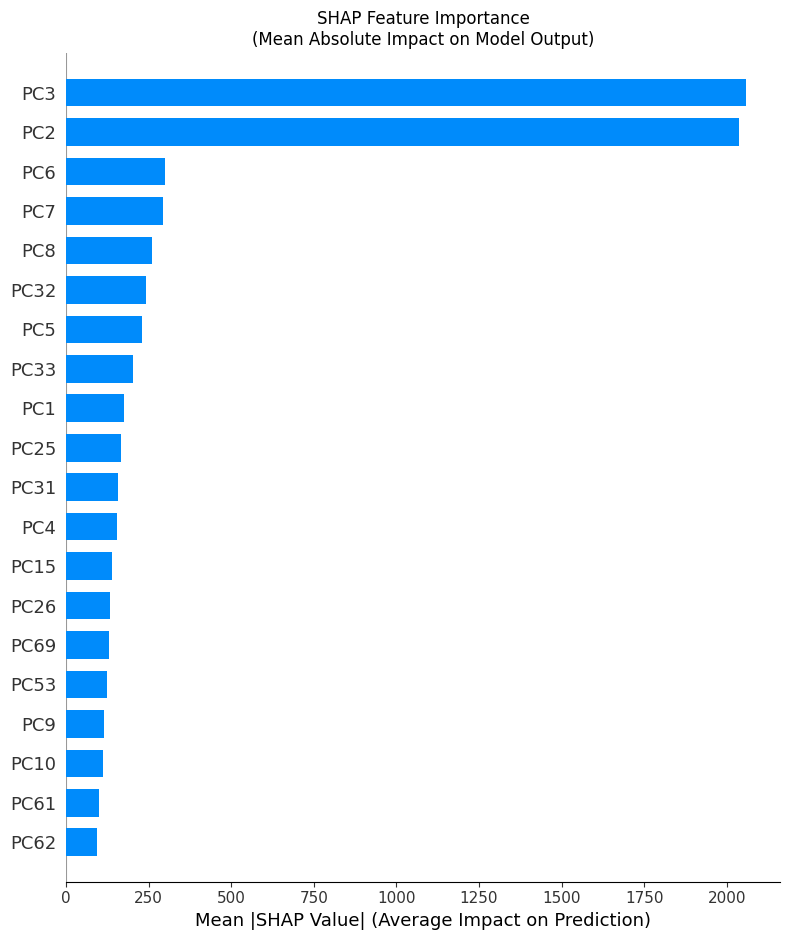

/tmp/ipykernel_2213027/4133508027.py:199: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train, max_display=10, show=False)


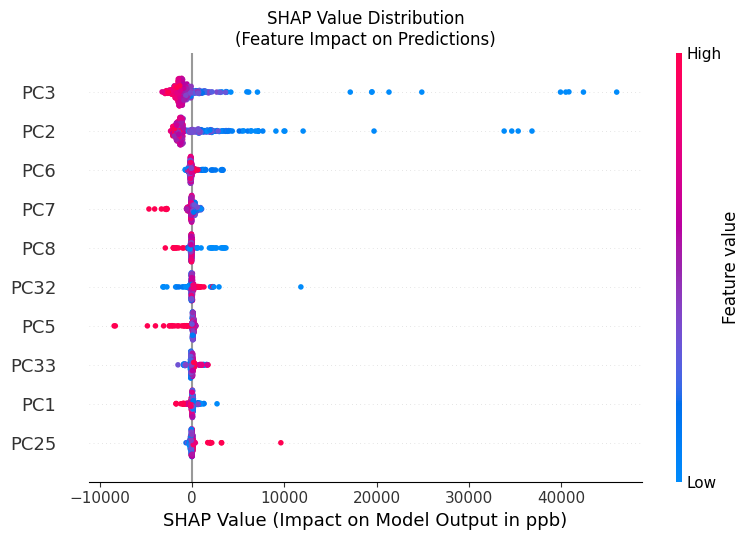

Sample prediction: 736.32 ppb
Final Model Performance Summary:


,Metric,Value
0,Cross-Validated RMSE,6685.931601
1,Test MAE,2540.090928
2,Test RMSE,5602.773071
3,Test R²,0.887702



Top 10 Features:


,Feature,Importance
2,PC3,0.189691
32,PC33,0.109957
1,PC2,0.060464
52,PC53,0.056767
5,PC6,0.055127
59,PC60,0.044180
21,PC22,0.041453
0,PC1,0.031331
58,PC59,0.030193
9,PC10,0.026973


In [5]:
# Import necessary libraries
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'  # Disable GPU if needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import shap
import joblib
import optuna
from optuna.samplers import TPESampler

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load the preprocessed data
X_train = pd.read_csv("../data/processed/x_train.csv")
X_test = pd.read_csv("../data/processed/x_test.csv")
y_train = pd.read_csv("../data/processed/y_train.csv")
y_test = pd.read_csv("../data/processed/y_test.csv")

# Verify shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Prepare data (remove hsi_id)
X_train = X_train.drop(columns=['hsi_id'])
X_test = X_test.drop(columns=['hsi_id'])
y_train = y_train['vomitoxin_ppb']
y_test = y_test['vomitoxin_ppb']

# Evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Evaluate model using cross-validation and test set"""
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = cross_val_score(
        model, X_train, y_train, 
        cv=cv, 
        scoring='neg_mean_squared_error',
        n_jobs=4
    )
    rmse_scores = np.sqrt(-cv_scores)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    metrics = {
        'CV_RMSE_mean': rmse_scores.mean(),
        'CV_RMSE_std': rmse_scores.std(),
        'Test_MAE': mean_absolute_error(y_test, y_pred),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'Test_R2': r2_score(y_test, y_pred)
    }
    
    return metrics, y_pred

# Baseline XGBoost model
xgb_baseline = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=8
)

xgb_metrics, xgb_pred = evaluate_model(xgb_baseline, X_train, y_train, X_test, y_test)
print("XGBoost Baseline Performance:")
display(pd.DataFrame([xgb_metrics]))

# Hyperparameter tuning with Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    
    model = xgb.XGBRegressor(
        **params,
        objective='reg:squarederror',
        random_state=RANDOM_STATE,
        n_jobs=4
    )
    
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    score = cross_val_score(
        model, X_train, y_train,
        cv=cv,
        scoring='neg_mean_squared_error',
        n_jobs=8
    ).mean()
    
    return np.sqrt(-score)

study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=RANDOM_STATE)
)
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Best trial:")
trial = study.best_trial
print(f"RMSE: {trial.value:.4f}")
print("Best parameters:")
print(trial.params)

# Train final model
best_params = trial.params
final_model = xgb.XGBRegressor(
    **best_params,
    objective='reg:squarederror',
    random_state=RANDOM_STATE,
    n_jobs=8
)

final_metrics, final_pred = evaluate_model(final_model, X_train, y_train, X_test, y_test)
print("Final Model Performance:")
display(pd.DataFrame([final_metrics]))

joblib.dump(final_model, '../data/models/best_xgboost_model.pkl')

# Enhanced visualization function
def plot_results(y_true, y_pred, model_name):
    """Create evaluation plots with detailed legends"""
    plt.figure(figsize=(15, 5))
    
    # Actual vs Predicted
    plt.subplot(1, 3, 1)
    plt.scatter(y_true, y_pred, alpha=0.6, label='Predictions')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
            'r--', label='Perfect Prediction')
    plt.xlabel('Actual DON (ppb)')
    plt.ylabel('Predicted DON (ppb)')
    plt.title(f'{model_name} - Actual vs Predicted')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Residuals
    residuals = y_true - y_pred
    plt.subplot(1, 3, 2)
    plt.scatter(y_pred, residuals, alpha=0.6, label='Residuals')
    plt.axhline(y=0, color='r', linestyle='--', label='Zero Error')
    plt.xlabel('Predicted Values (ppb)')
    plt.ylabel('Residuals (ppb)')
    plt.title(f'{model_name} - Residual Plot')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Error Distribution
    plt.subplot(1, 3, 3)
    sns.histplot(residuals, kde=True, label='Error Distribution')
    plt.xlabel('Prediction Error (ppb)')
    plt.title(f'{model_name} - Error Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_results(y_test, final_pred, "Final XGBoost Model")

# Feature Importance and SHAP Analysis
plt.figure(figsize=(10, 8))
xgb.plot_importance(final_model, max_num_features=20, height=0.8)
plt.title('Top 20 Feature Importances\n(XGBoost Built-in)')
plt.xlabel('Feature Importance Score')
plt.tight_layout()
plt.show()

# Improved SHAP Analysis
explainer = shap.TreeExplainer(final_model)
shap_values = explainer(X_train)  # Using shap_values directly instead of explainer.shap_values

# SHAP Summary Plot - Bar
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=20, show=False)
plt.title('SHAP Feature Importance\n(Mean Absolute Impact on Model Output)')
plt.xlabel('Mean |SHAP Value| (Average Impact on Prediction)')
plt.tight_layout()
plt.show()

# SHAP Summary Plot - Detailed
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train, max_display=10, show=False)
plt.title('SHAP Value Distribution\n(Feature Impact on Predictions)')
plt.xlabel('SHAP Value (Impact on Model Output in ppb)')
plt.tight_layout()
plt.show()

# Prediction function
def predict_don(features):
    """Predict DON concentration from spectral features"""
    if 'final_model' not in globals():
        global final_model
        final_model = joblib.load('../data/models/best_xgboost_model.pkl')
    
    features = np.array(features).reshape(1, -1)
    return float(final_model.predict(features)[0])

sample_features = X_train.iloc[0].values
print(f"Sample prediction: {predict_don(sample_features):.2f} ppb")

joblib.dump(explainer, '../data/models/shap_explainer.pkl')

# Final Performance Report
performance_df = pd.DataFrame({
    'Metric': ['Cross-Validated RMSE', 'Test MAE', 'Test RMSE', 'Test R²'],
    'Value': [
        final_metrics['CV_RMSE_mean'],
        final_metrics['Test_MAE'],
        final_metrics['Test_RMSE'],
        final_metrics['Test_R2']
    ]
})

print("Final Model Performance Summary:")
display(performance_df)

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features:")
display(feature_importance.head(10))

### ITER 3

# ITER 2

2025-03-31 04:24:41,120 - INFO - Configuration loaded successfully.
2025-03-31 04:24:41,129 - INFO - Data loaded: X_train (395, 71), X_test (100, 71), y_train (395, 2), y_test (100, 2)
2025-03-31 04:24:41,130 - INFO - Identifier columns removed and targets extracted.
2025-03-31 04:24:43,053 - INFO - Model evaluation completed.
2025-03-31 04:24:43,054 - INFO - XGBoost Baseline Performance:
2025-03-31 04:24:43,055 - INFO - {'CV_RMSE_mean': np.float64(7346.202733431108), 'CV_RMSE_std': np.float64(4569.841451961353), 'Test_MAE': 2435.782413339615, 'Test_RMSE': np.float64(7679.777381628371), 'Test_R2': 0.7890089657057169}
2025-03-31 04:24:43,055 - INFO - Starting hyperparameter tuning with Optuna...
[I 2025-03-31 04:24:43,056] A new study created in memory with name: no-name-4a8f083d-2c02-4f60-8ea8-4ba5123f9a6d
Best trial: 0. Best value: 8638.2:   2%|▏         | 1/50 [00:01<01:31,  1.87s/it]

[I 2025-03-31 04:24:44,926] Trial 0 finished with value: 8638.195021106209 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.02904180608409973, 'reg_alpha': 0.8661761457749352, 'reg_lambda': 0.6011150117432088}. Best is trial 0 with value: 8638.195021106209.


Best trial: 1. Best value: 8472.02:   4%|▍         | 2/50 [00:02<01:01,  1.28s/it]

[I 2025-03-31 04:24:45,801] Trial 1 finished with value: 8472.01510346909 and parameters: {'n_estimators': 383, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'min_child_weight': 2, 'gamma': 0.09170225492671691, 'reg_alpha': 0.3042422429595377, 'reg_lambda': 0.5247564316322378}. Best is trial 1 with value: 8472.01510346909.


Best trial: 2. Best value: 8366.58:   6%|▌         | 3/50 [00:03<00:41,  1.14it/s]

[I 2025-03-31 04:24:46,191] Trial 2 finished with value: 8366.580089959643 and parameters: {'n_estimators': 273, 'max_depth': 5, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_bytree': 0.7168578594140873, 'min_child_weight': 4, 'gamma': 0.22803499210851796, 'reg_alpha': 0.7851759613930136, 'reg_lambda': 0.19967378215835974}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:   8%|▊         | 4/50 [00:04<00:41,  1.10it/s]

[I 2025-03-31 04:24:47,152] Trial 3 finished with value: 8562.056737865132 and parameters: {'n_estimators': 306, 'max_depth': 7, 'learning_rate': 0.011711509955524094, 'subsample': 0.8430179407605753, 'colsample_bytree': 0.6682096494749166, 'min_child_weight': 1, 'gamma': 0.4744427686266666, 'reg_alpha': 0.9656320330745594, 'reg_lambda': 0.8083973481164611}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  10%|█         | 5/50 [00:04<00:29,  1.51it/s]

[I 2025-03-31 04:24:47,381] Trial 4 finished with value: 8623.008711826451 and parameters: {'n_estimators': 222, 'max_depth': 3, 'learning_rate': 0.1024932221692416, 'subsample': 0.7760609974958406, 'colsample_bytree': 0.6488152939379115, 'min_child_weight': 5, 'gamma': 0.017194260557609198, 'reg_alpha': 0.9093204020787821, 'reg_lambda': 0.2587799816000169}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  12%|█▏        | 6/50 [00:04<00:26,  1.64it/s]

[I 2025-03-31 04:24:47,884] Trial 5 finished with value: 9054.103192813573 and parameters: {'n_estimators': 365, 'max_depth': 5, 'learning_rate': 0.05864129169696527, 'subsample': 0.8186841117373118, 'colsample_bytree': 0.6739417822102108, 'min_child_weight': 10, 'gamma': 0.3875664116805573, 'reg_alpha': 0.9394989415641891, 'reg_lambda': 0.8948273504276488}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  14%|█▍        | 7/50 [00:05<00:31,  1.34it/s]

[I 2025-03-31 04:24:48,904] Trial 6 finished with value: 8834.445348039533 and parameters: {'n_estimators': 339, 'max_depth': 10, 'learning_rate': 0.01351182947645082, 'subsample': 0.6783931449676581, 'colsample_bytree': 0.6180909155642152, 'min_child_weight': 4, 'gamma': 0.194338644844741, 'reg_alpha': 0.2713490317738959, 'reg_lambda': 0.8287375091519293}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  16%|█▌        | 8/50 [00:06<00:28,  1.46it/s]

[I 2025-03-31 04:24:49,456] Trial 7 finished with value: 9252.97775763449 and parameters: {'n_estimators': 243, 'max_depth': 5, 'learning_rate': 0.06333268775321842, 'subsample': 0.6563696899899051, 'colsample_bytree': 0.9208787923016158, 'min_child_weight': 1, 'gamma': 0.49344346830025865, 'reg_alpha': 0.7722447692966574, 'reg_lambda': 0.1987156815341724}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  18%|█▊        | 9/50 [00:06<00:26,  1.55it/s]

[I 2025-03-31 04:24:50,022] Trial 8 finished with value: 9066.121488886556 and parameters: {'n_estimators': 102, 'max_depth': 9, 'learning_rate': 0.11069143219393454, 'subsample': 0.8916028672163949, 'colsample_bytree': 0.9085081386743783, 'min_child_weight': 1, 'gamma': 0.1792328642721363, 'reg_alpha': 0.11586905952512971, 'reg_lambda': 0.8631034258755935}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  20%|██        | 10/50 [00:07<00:24,  1.66it/s]

[I 2025-03-31 04:24:50,527] Trial 9 finished with value: 9161.886163244382 and parameters: {'n_estimators': 349, 'max_depth': 5, 'learning_rate': 0.012413189635294229, 'subsample': 0.7243929286862649, 'colsample_bytree': 0.7300733288106989, 'min_child_weight': 8, 'gamma': 0.31877873567760656, 'reg_alpha': 0.8872127425763265, 'reg_lambda': 0.4722149251619493}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  22%|██▏       | 11/50 [00:08<00:26,  1.48it/s]

[I 2025-03-31 04:24:51,372] Trial 10 finished with value: 8579.73625542719 and parameters: {'n_estimators': 478, 'max_depth': 7, 'learning_rate': 0.028477486830279865, 'subsample': 0.6071847502459278, 'colsample_bytree': 0.8010124870699185, 'min_child_weight': 7, 'gamma': 0.2760977256675942, 'reg_alpha': 0.6240835271723653, 'reg_lambda': 0.039907535719484855}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  24%|██▍       | 12/50 [00:08<00:23,  1.62it/s]

[I 2025-03-31 04:24:51,855] Trial 11 finished with value: 8583.825992346703 and parameters: {'n_estimators': 462, 'max_depth': 3, 'learning_rate': 0.24950292438859506, 'subsample': 0.9687557027925864, 'colsample_bytree': 0.7737425087025644, 'min_child_weight': 3, 'gamma': 0.12003329156932674, 'reg_alpha': 0.4182682716196848, 'reg_lambda': 0.46994321499695574}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  26%|██▌       | 13/50 [00:09<00:21,  1.75it/s]

[I 2025-03-31 04:24:52,315] Trial 12 finished with value: 8546.500314147888 and parameters: {'n_estimators': 418, 'max_depth': 4, 'learning_rate': 0.27675589864710687, 'subsample': 0.9994636029283407, 'colsample_bytree': 0.8404427663008558, 'min_child_weight': 4, 'gamma': 0.09695084439740809, 'reg_alpha': 0.5245057886624165, 'reg_lambda': 0.2944068495666103}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  28%|██▊       | 14/50 [00:09<00:16,  2.15it/s]

[I 2025-03-31 04:24:52,539] Trial 13 finished with value: 8847.163199715804 and parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.02984224442314634, 'subsample': 0.9199690201206847, 'colsample_bytree': 0.7286923691999561, 'min_child_weight': 6, 'gamma': 0.21454949780832402, 'reg_alpha': 0.3091339583045281, 'reg_lambda': 0.64208794318194}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  30%|███       | 15/50 [00:10<00:19,  1.77it/s]

[I 2025-03-31 04:24:53,331] Trial 14 finished with value: 8488.006240212499 and parameters: {'n_estimators': 392, 'max_depth': 6, 'learning_rate': 0.17080659935001277, 'subsample': 0.7507711462516721, 'colsample_bytree': 0.9840998651516013, 'min_child_weight': 3, 'gamma': 0.12417011982640969, 'reg_alpha': 0.689155822984862, 'reg_lambda': 0.09086840375111387}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  32%|███▏      | 16/50 [00:10<00:16,  2.07it/s]

[I 2025-03-31 04:24:53,630] Trial 15 finished with value: 8590.865789113861 and parameters: {'n_estimators': 270, 'max_depth': 3, 'learning_rate': 0.03545757434511042, 'subsample': 0.9063978236539806, 'colsample_bytree': 0.716507181535291, 'min_child_weight': 3, 'gamma': 0.3343228607836479, 'reg_alpha': 0.010065752312506171, 'reg_lambda': 0.43451435782595793}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  34%|███▍      | 17/50 [00:11<00:18,  1.83it/s]

[I 2025-03-31 04:24:54,323] Trial 16 finished with value: 9244.905607449959 and parameters: {'n_estimators': 434, 'max_depth': 6, 'learning_rate': 0.17382062178166294, 'subsample': 0.60195639766132, 'colsample_bytree': 0.6034370752877032, 'min_child_weight': 5, 'gamma': 0.06408681310221985, 'reg_alpha': 0.47866936071859034, 'reg_lambda': 0.3583902847905417}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  36%|███▌      | 18/50 [00:11<00:15,  2.12it/s]

[I 2025-03-31 04:24:54,623] Trial 17 finished with value: 8786.508527842629 and parameters: {'n_estimators': 185, 'max_depth': 4, 'learning_rate': 0.07501028782219026, 'subsample': 0.7041942338938955, 'colsample_bytree': 0.7801614469884962, 'min_child_weight': 2, 'gamma': 0.15682482142699825, 'reg_alpha': 0.2567069389694278, 'reg_lambda': 0.6556498190600932}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  38%|███▊      | 19/50 [00:12<00:18,  1.68it/s]

[I 2025-03-31 04:24:55,501] Trial 18 finished with value: 8383.238446494535 and parameters: {'n_estimators': 328, 'max_depth': 8, 'learning_rate': 0.020038260312712813, 'subsample': 0.8731407435344102, 'colsample_bytree': 0.8416634198004798, 'min_child_weight': 6, 'gamma': 0.2470634592056546, 'reg_alpha': 0.6134917963094769, 'reg_lambda': 0.1643967376099853}. Best is trial 2 with value: 8366.580089959643.


Best trial: 19. Best value: 8291.2:  40%|████      | 20/50 [00:13<00:20,  1.48it/s]

[I 2025-03-31 04:24:56,361] Trial 19 finished with value: 8291.200100427684 and parameters: {'n_estimators': 299, 'max_depth': 8, 'learning_rate': 0.019835286801746912, 'subsample': 0.870443990178826, 'colsample_bytree': 0.8511027556947152, 'min_child_weight': 8, 'gamma': 0.24910251226588562, 'reg_alpha': 0.726775165034454, 'reg_lambda': 0.11163809391005666}. Best is trial 19 with value: 8291.200100427684.


Best trial: 19. Best value: 8291.2:  42%|████▏     | 21/50 [00:14<00:19,  1.45it/s]

[I 2025-03-31 04:24:57,085] Trial 20 finished with value: 8631.789484232464 and parameters: {'n_estimators': 287, 'max_depth': 8, 'learning_rate': 0.04151929443699016, 'subsample': 0.7749267580172707, 'colsample_bytree': 0.8782980385513112, 'min_child_weight': 9, 'gamma': 0.3972276294870267, 'reg_alpha': 0.7358065279607223, 'reg_lambda': 0.016335300753528487}. Best is trial 19 with value: 8291.200100427684.


Best trial: 21. Best value: 8132.81:  44%|████▍     | 22/50 [00:14<00:20,  1.39it/s]

[I 2025-03-31 04:24:57,869] Trial 21 finished with value: 8132.806286610395 and parameters: {'n_estimators': 310, 'max_depth': 8, 'learning_rate': 0.019165284053326084, 'subsample': 0.8795510218705594, 'colsample_bytree': 0.8431986333388165, 'min_child_weight': 7, 'gamma': 0.2523571380476008, 'reg_alpha': 0.6359949606640374, 'reg_lambda': 0.15774579155681345}. Best is trial 21 with value: 8132.806286610395.


Best trial: 21. Best value: 8132.81:  46%|████▌     | 23/50 [00:15<00:18,  1.48it/s]

[I 2025-03-31 04:24:58,453] Trial 22 finished with value: 8642.802389394203 and parameters: {'n_estimators': 216, 'max_depth': 8, 'learning_rate': 0.017953064228077485, 'subsample': 0.8699627806602964, 'colsample_bytree': 0.8182044081145493, 'min_child_weight': 8, 'gamma': 0.25378466661013505, 'reg_alpha': 0.8089296207624268, 'reg_lambda': 0.13216827715702517}. Best is trial 21 with value: 8132.806286610395.


Best trial: 23. Best value: 8103.63:  48%|████▊     | 24/50 [00:16<00:17,  1.45it/s]

[I 2025-03-31 04:24:59,176] Trial 23 finished with value: 8103.634226976151 and parameters: {'n_estimators': 310, 'max_depth': 7, 'learning_rate': 0.02027693372057436, 'subsample': 0.811546408077755, 'colsample_bytree': 0.8893393991411527, 'min_child_weight': 7, 'gamma': 0.2996907034831955, 'reg_alpha': 0.6643192667362228, 'reg_lambda': 0.24351001160119423}. Best is trial 23 with value: 8103.634226976151.


Best trial: 23. Best value: 8103.63:  50%|█████     | 25/50 [00:17<00:19,  1.30it/s]

[I 2025-03-31 04:25:00,133] Trial 24 finished with value: 8143.488519181019 and parameters: {'n_estimators': 312, 'max_depth': 9, 'learning_rate': 0.01746390206593181, 'subsample': 0.7974115816012433, 'colsample_bytree': 0.9693997538611993, 'min_child_weight': 7, 'gamma': 0.2940290169007296, 'reg_alpha': 0.621885196948374, 'reg_lambda': 0.31940266864774947}. Best is trial 23 with value: 8103.634226976151.


Best trial: 23. Best value: 8103.63:  52%|█████▏    | 26/50 [00:18<00:19,  1.21it/s]

[I 2025-03-31 04:25:01,087] Trial 25 finished with value: 8322.26095996502 and parameters: {'n_estimators': 313, 'max_depth': 9, 'learning_rate': 0.015438060453532288, 'subsample': 0.7859717994686578, 'colsample_bytree': 0.9700505870963767, 'min_child_weight': 7, 'gamma': 0.30359325414134236, 'reg_alpha': 0.5403587563277911, 'reg_lambda': 0.33881764048915847}. Best is trial 23 with value: 8103.634226976151.


Best trial: 26. Best value: 7894.97:  54%|█████▍    | 27/50 [00:19<00:20,  1.14it/s]

[I 2025-03-31 04:25:02,092] Trial 26 finished with value: 7894.9704052679745 and parameters: {'n_estimators': 367, 'max_depth': 9, 'learning_rate': 0.02455539659095544, 'subsample': 0.8202905329770378, 'colsample_bytree': 0.9551693140210797, 'min_child_weight': 7, 'gamma': 0.379473387715081, 'reg_alpha': 0.6295300380602712, 'reg_lambda': 0.3648675951229743}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  56%|█████▌    | 28/50 [00:19<00:19,  1.11it/s]

[I 2025-03-31 04:25:03,037] Trial 27 finished with value: 8328.701093087313 and parameters: {'n_estimators': 410, 'max_depth': 7, 'learning_rate': 0.02344313028752466, 'subsample': 0.8433487490568512, 'colsample_bytree': 0.9340226024611946, 'min_child_weight': 9, 'gamma': 0.3630964637798527, 'reg_alpha': 0.4288084220895492, 'reg_lambda': 0.2439066039400356}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  58%|█████▊    | 29/50 [00:21<00:20,  1.04it/s]

[I 2025-03-31 04:25:04,138] Trial 28 finished with value: 8434.185291826305 and parameters: {'n_estimators': 357, 'max_depth': 9, 'learning_rate': 0.01005245985163312, 'subsample': 0.81144645662038, 'colsample_bytree': 0.8862837162443185, 'min_child_weight': 6, 'gamma': 0.4386959993167423, 'reg_alpha': 0.6713654870569534, 'reg_lambda': 0.3824329530215289}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  60%|██████    | 30/50 [00:21<00:18,  1.07it/s]

[I 2025-03-31 04:25:05,026] Trial 29 finished with value: 7937.853768698042 and parameters: {'n_estimators': 247, 'max_depth': 10, 'learning_rate': 0.043704424980366925, 'subsample': 0.9458109099507797, 'colsample_bytree': 0.9540253388646004, 'min_child_weight': 7, 'gamma': 0.3478809264812017, 'reg_alpha': 0.8398384561816131, 'reg_lambda': 0.5746972042991608}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  62%|██████▏   | 31/50 [00:22<00:17,  1.10it/s]

[I 2025-03-31 04:25:05,862] Trial 30 finished with value: 8039.75143070421 and parameters: {'n_estimators': 247, 'max_depth': 10, 'learning_rate': 0.04476063340840976, 'subsample': 0.9486874886875832, 'colsample_bytree': 0.9508318266871417, 'min_child_weight': 9, 'gamma': 0.43095381424413115, 'reg_alpha': 0.8496186588837124, 'reg_lambda': 0.7471803788285408}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  64%|██████▍   | 32/50 [00:23<00:15,  1.16it/s]

[I 2025-03-31 04:25:06,626] Trial 31 finished with value: 8451.840705469795 and parameters: {'n_estimators': 242, 'max_depth': 10, 'learning_rate': 0.04429505667620125, 'subsample': 0.9504766617230207, 'colsample_bytree': 0.942296042843562, 'min_child_weight': 10, 'gamma': 0.43486586390343845, 'reg_alpha': 0.8521482557007041, 'reg_lambda': 0.728514692891076}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  66%|██████▌   | 33/50 [00:24<00:13,  1.24it/s]

[I 2025-03-31 04:25:07,304] Trial 32 finished with value: 8078.784705294576 and parameters: {'n_estimators': 190, 'max_depth': 10, 'learning_rate': 0.04687612213972545, 'subsample': 0.9761269960169491, 'colsample_bytree': 0.9948223631776224, 'min_child_weight': 9, 'gamma': 0.359337732370985, 'reg_alpha': 0.845103444545872, 'reg_lambda': 0.995694986576965}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  68%|██████▊   | 34/50 [00:24<00:11,  1.35it/s]

[I 2025-03-31 04:25:07,891] Trial 33 finished with value: 8205.149847935309 and parameters: {'n_estimators': 177, 'max_depth': 10, 'learning_rate': 0.0472039619572555, 'subsample': 0.9803759258013781, 'colsample_bytree': 0.9528523377437574, 'min_child_weight': 9, 'gamma': 0.34865288356978535, 'reg_alpha': 0.9989345502575097, 'reg_lambda': 0.5451010570036033}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  70%|███████   | 35/50 [00:25<00:10,  1.37it/s]

[I 2025-03-31 04:25:08,593] Trial 34 finished with value: 8269.906729784172 and parameters: {'n_estimators': 198, 'max_depth': 10, 'learning_rate': 0.03365950523517799, 'subsample': 0.944889902362251, 'colsample_bytree': 0.9875345063356818, 'min_child_weight': 9, 'gamma': 0.41729127693192486, 'reg_alpha': 0.8475239927087462, 'reg_lambda': 0.761320208044043}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 35. Best value: 7847.44:  72%|███████▏  | 36/50 [00:26<00:10,  1.35it/s]

[I 2025-03-31 04:25:09,359] Trial 35 finished with value: 7847.442398954651 and parameters: {'n_estimators': 222, 'max_depth': 10, 'learning_rate': 0.052417734528796237, 'subsample': 0.9267245786655629, 'colsample_bytree': 0.9951316684720198, 'min_child_weight': 8, 'gamma': 0.36923488203789073, 'reg_alpha': 0.8220440117361256, 'reg_lambda': 0.9819228559103086}. Best is trial 35 with value: 7847.442398954651.


Best trial: 35. Best value: 7847.44:  74%|███████▍  | 37/50 [00:27<00:09,  1.32it/s]

[I 2025-03-31 04:25:10,164] Trial 36 finished with value: 7880.222289762415 and parameters: {'n_estimators': 267, 'max_depth': 9, 'learning_rate': 0.06692416219804206, 'subsample': 0.929034957333791, 'colsample_bytree': 0.9596705099258309, 'min_child_weight': 8, 'gamma': 0.46234598188704285, 'reg_alpha': 0.9399244877698414, 'reg_lambda': 0.9995651517192231}. Best is trial 35 with value: 7847.442398954651.


Best trial: 35. Best value: 7847.44:  76%|███████▌  | 38/50 [00:27<00:08,  1.36it/s]

[I 2025-03-31 04:25:10,850] Trial 37 finished with value: 7877.18808995718 and parameters: {'n_estimators': 271, 'max_depth': 9, 'learning_rate': 0.08507333186533964, 'subsample': 0.9273783023579116, 'colsample_bytree': 0.9198658228968843, 'min_child_weight': 8, 'gamma': 0.47215426393219306, 'reg_alpha': 0.9818540631463812, 'reg_lambda': 0.9042423150777893}. Best is trial 35 with value: 7847.442398954651.


Best trial: 38. Best value: 7567.79:  78%|███████▊  | 39/50 [00:28<00:08,  1.34it/s]

[I 2025-03-31 04:25:11,615] Trial 38 finished with value: 7567.7866484916085 and parameters: {'n_estimators': 272, 'max_depth': 9, 'learning_rate': 0.08721830998229096, 'subsample': 0.8445776396190179, 'colsample_bytree': 0.9129328155280088, 'min_child_weight': 8, 'gamma': 0.4751758762823277, 'reg_alpha': 0.9198429847259147, 'reg_lambda': 0.9810362483082278}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  80%|████████  | 40/50 [00:29<00:07,  1.33it/s]

[I 2025-03-31 04:25:12,373] Trial 39 finished with value: 7794.131898461793 and parameters: {'n_estimators': 278, 'max_depth': 9, 'learning_rate': 0.08874461090684191, 'subsample': 0.9152599077825478, 'colsample_bytree': 0.9170446120935413, 'min_child_weight': 8, 'gamma': 0.4683824685263483, 'reg_alpha': 0.935139443129884, 'reg_lambda': 0.9995868531183777}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  82%|████████▏ | 41/50 [00:29<00:06,  1.42it/s]

[I 2025-03-31 04:25:12,978] Trial 40 finished with value: 8600.865075516826 and parameters: {'n_estimators': 219, 'max_depth': 9, 'learning_rate': 0.08316299933963785, 'subsample': 0.8503275295705586, 'colsample_bytree': 0.9184037171978066, 'min_child_weight': 10, 'gamma': 0.49405882847356813, 'reg_alpha': 0.9886694766383121, 'reg_lambda': 0.9152777468148677}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  84%|████████▍ | 42/50 [00:30<00:05,  1.38it/s]

[I 2025-03-31 04:25:13,753] Trial 41 finished with value: 7872.381218552118 and parameters: {'n_estimators': 267, 'max_depth': 9, 'learning_rate': 0.09243048975830637, 'subsample': 0.9189966603111114, 'colsample_bytree': 0.9059453379839171, 'min_child_weight': 8, 'gamma': 0.46608004422355087, 'reg_alpha': 0.9244250194795443, 'reg_lambda': 0.9938794998450424}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  86%|████████▌ | 43/50 [00:31<00:05,  1.32it/s]

[I 2025-03-31 04:25:14,591] Trial 42 finished with value: 7870.625900581136 and parameters: {'n_estimators': 283, 'max_depth': 9, 'learning_rate': 0.09195561498299554, 'subsample': 0.9051744119181657, 'colsample_bytree': 0.8990258147943231, 'min_child_weight': 8, 'gamma': 0.462742033507158, 'reg_alpha': 0.9282865519830986, 'reg_lambda': 0.9548325487893339}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  88%|████████▊ | 44/50 [00:32<00:04,  1.40it/s]

[I 2025-03-31 04:25:15,196] Trial 43 finished with value: 7821.466740387789 and parameters: {'n_estimators': 233, 'max_depth': 8, 'learning_rate': 0.13512620686940155, 'subsample': 0.9016480815876093, 'colsample_bytree': 0.8717722813971821, 'min_child_weight': 8, 'gamma': 0.46516801790266293, 'reg_alpha': 0.9117864760777536, 'reg_lambda': 0.9434374340022391}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  90%|█████████ | 45/50 [00:32<00:03,  1.41it/s]

[I 2025-03-31 04:25:15,892] Trial 44 finished with value: 7677.667630618341 and parameters: {'n_estimators': 286, 'max_depth': 8, 'learning_rate': 0.1339718885947025, 'subsample': 0.8991493176628343, 'colsample_bytree': 0.8568744028318359, 'min_child_weight': 8, 'gamma': 0.40792217479506815, 'reg_alpha': 0.9022088127954687, 'reg_lambda': 0.9391254156410259}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  92%|█████████▏| 46/50 [00:33<00:02,  1.62it/s]

[I 2025-03-31 04:25:16,294] Trial 45 finished with value: 8592.112164293065 and parameters: {'n_estimators': 166, 'max_depth': 8, 'learning_rate': 0.1395890384378099, 'subsample': 0.8955476349130974, 'colsample_bytree': 0.8674756823068144, 'min_child_weight': 10, 'gamma': 0.4162252440092521, 'reg_alpha': 0.8887616560967914, 'reg_lambda': 0.8302952539048541}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  94%|█████████▍| 47/50 [00:33<00:01,  1.83it/s]

[I 2025-03-31 04:25:16,681] Trial 46 finished with value: 8093.370213981029 and parameters: {'n_estimators': 148, 'max_depth': 8, 'learning_rate': 0.12412693607355021, 'subsample': 0.8303731805695322, 'colsample_bytree': 0.8650037239808243, 'min_child_weight': 6, 'gamma': 0.3986627191181256, 'reg_alpha': 0.7447412632984255, 'reg_lambda': 0.9385298345333704}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  96%|█████████▌| 48/50 [00:34<00:01,  1.85it/s]

[I 2025-03-31 04:25:17,205] Trial 47 finished with value: 7948.394798382668 and parameters: {'n_estimators': 232, 'max_depth': 7, 'learning_rate': 0.14723290295091088, 'subsample': 0.8638600927521128, 'colsample_bytree': 0.8283143404468539, 'min_child_weight': 8, 'gamma': 0.4885642516506967, 'reg_alpha': 0.8020990442443177, 'reg_lambda': 0.8607865434732835}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  98%|█████████▊| 49/50 [00:34<00:00,  1.82it/s]

[I 2025-03-31 04:25:17,779] Trial 48 finished with value: 8535.424186917573 and parameters: {'n_estimators': 210, 'max_depth': 8, 'learning_rate': 0.1943505342856819, 'subsample': 0.8861079170146087, 'colsample_bytree': 0.7974251183637835, 'min_child_weight': 5, 'gamma': 0.4477596743740228, 'reg_alpha': 0.8932992029485292, 'reg_lambda': 0.8822269978191468}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79: 100%|██████████| 50/50 [00:35<00:00,  1.42it/s]
2025-03-31 04:25:18,386 - INFO - Best trial RMSE: 7567.7866
2025-03-31 04:25:18,387 - INFO - Best parameters: {'n_estimators': 272, 'max_depth': 9, 'learning_rate': 0.08721830998229096, 'subsample': 0.8445776396190179, 'colsample_bytree': 0.9129328155280088, 'min_child_weight': 8, 'gamma': 0.4751758762823277, 'reg_alpha': 0.9198429847259147, 'reg_lambda': 0.9810362483082278}


[I 2025-03-31 04:25:18,383] Trial 49 finished with value: 7952.656484450488 and parameters: {'n_estimators': 338, 'max_depth': 6, 'learning_rate': 0.10732149127397309, 'subsample': 0.9028617359685179, 'colsample_bytree': 0.9284959909506965, 'min_child_weight': 9, 'gamma': 0.41237401844317295, 'reg_alpha': 0.9510589400102264, 'reg_lambda': 0.9523201787651652}. Best is trial 38 with value: 7567.7866484916085.


2025-03-31 04:25:20,946 - INFO - Model evaluation completed.
2025-03-31 04:25:20,947 - INFO - Final Model Performance:
2025-03-31 04:25:20,948 - INFO - {'CV_RMSE_mean': np.float64(6685.931600547963), 'CV_RMSE_std': np.float64(3545.3791602425267), 'Test_MAE': 2540.090928249359, 'Test_RMSE': np.float64(5602.773071231816), 'Test_R2': 0.8877017976481363}
2025-03-31 04:25:20,950 - INFO - Final model saved to ../data/models/best_xgboost_model.pkl


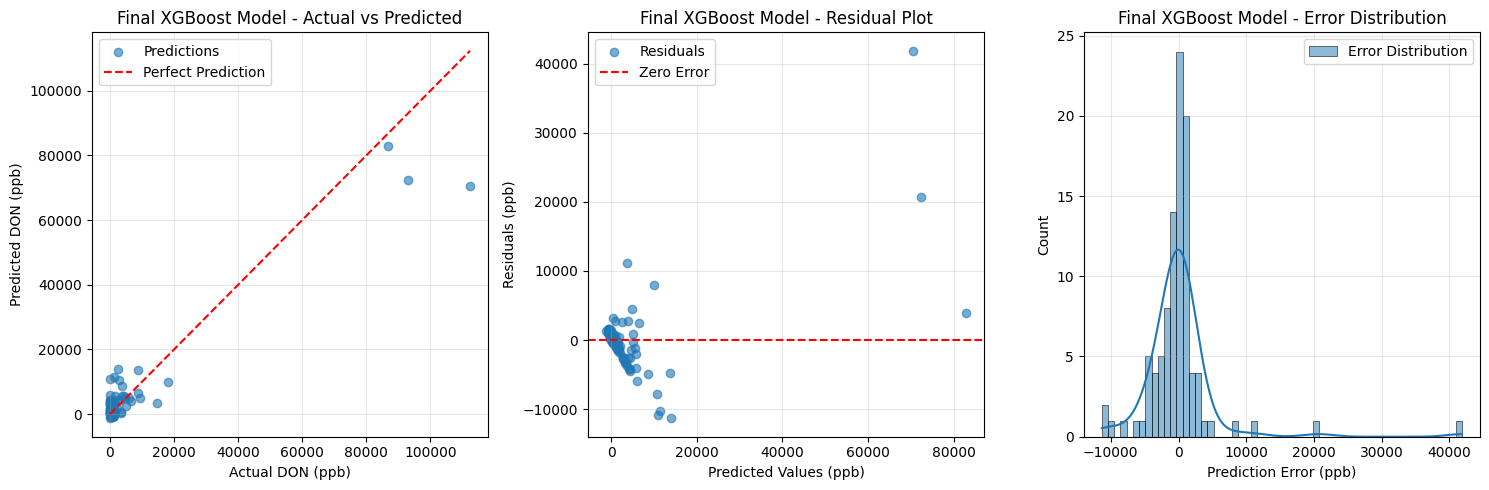

<Figure size 1000x800 with 0 Axes>

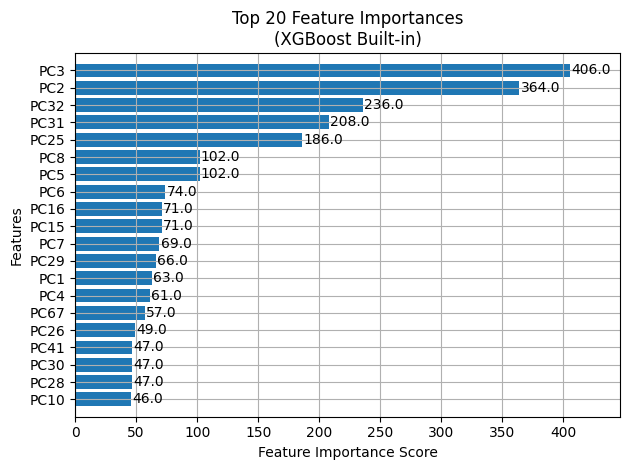

/tmp/ipykernel_2213027/580499497.py:276: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=20, show=False)


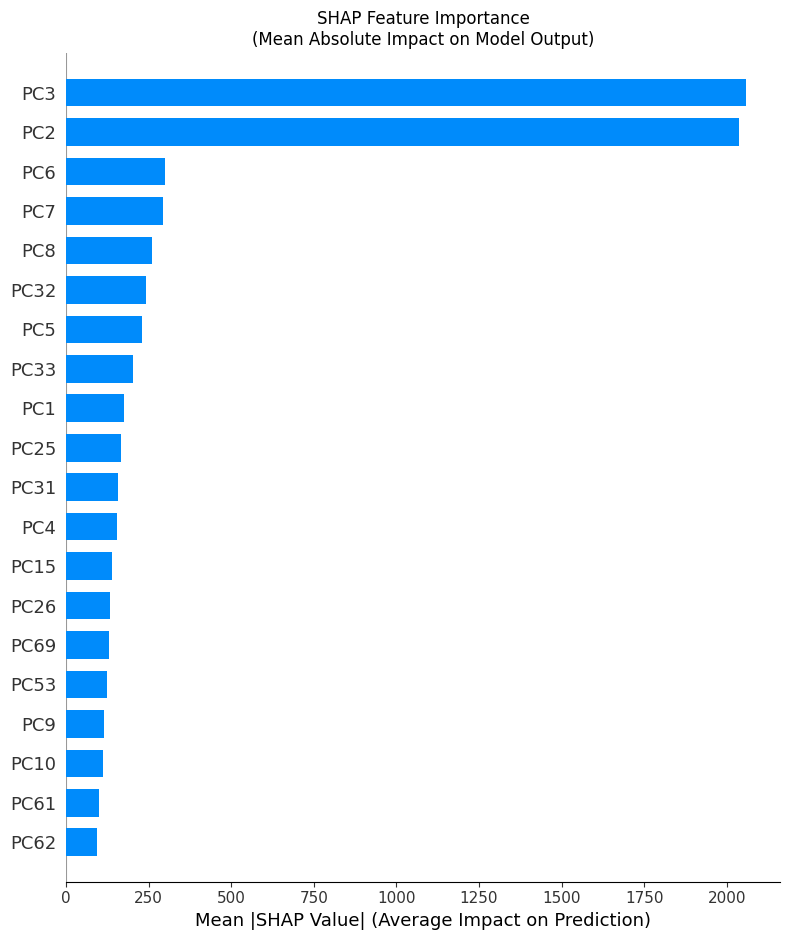

/tmp/ipykernel_2213027/580499497.py:284: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train, max_display=10, show=False)


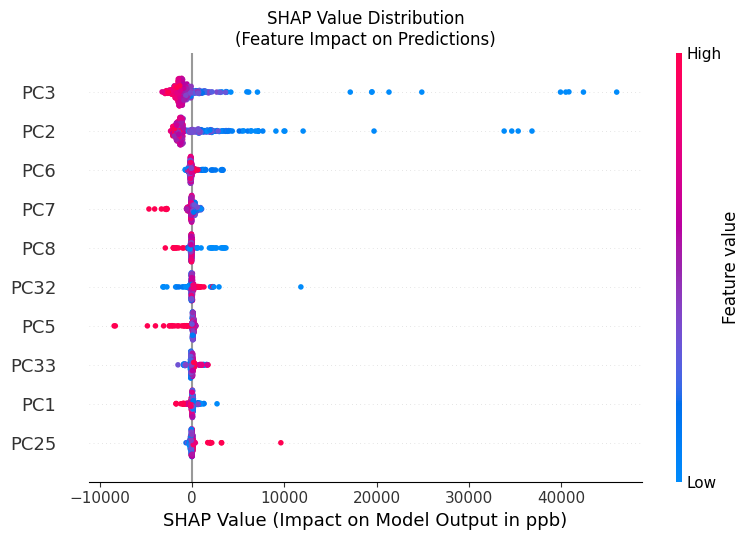

2025-03-31 04:25:22,093 - INFO - SHAP explainer saved to ../data/models/shap_explainer.pkl
2025-03-31 04:25:22,095 - INFO - Sample prediction: 736.32 ppb
2025-03-31 04:25:22,095 - INFO - Final Model Performance Summary:
2025-03-31 04:25:22,096 - INFO -               Metric       Value
Cross-Validated RMSE 6685.931601
            Test MAE 2540.090928
           Test RMSE 5602.773071
             Test R²    0.887702
2025-03-31 04:25:22,098 - INFO - Top 10 Features:
2025-03-31 04:25:22,099 - INFO - Feature  Importance
    PC3    0.189691
   PC33    0.109957
    PC2    0.060464
   PC53    0.056767
    PC6    0.055127
   PC60    0.044180
   PC22    0.041453
    PC1    0.031331
   PC59    0.030193
   PC10    0.026973


In [6]:
# xgboost_pipeline.py
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'  # Disable GPU if needed

import logging
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import shap
import joblib
import optuna
from optuna.samplers import TPESampler

# =============================================================================
# CONFIGURATION & LOGGING SETUP
# =============================================================================
# Enhanced Logging: Configure logging to file and console
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler(), logging.FileHandler("xgboost_pipeline.log")]
)
logger = logging.getLogger(__name__)

def load_config(config_path: str) -> dict:
    """Load external configuration settings."""
    try:
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)
        logger.info("Configuration loaded successfully.")
        return config
    except Exception as e:
        logger.error(f"Error loading config file {config_path}: {e}")
        raise e

# Example config file path (ensure that ../configs/config.yaml exists)
config = load_config("../configs/config.yaml")

# Set random seed from config (or fallback)
RANDOM_STATE = config.get("random_state", 42)
np.random.seed(RANDOM_STATE)

# =============================================================================
# DATA LOADING MODULE
# =============================================================================
def load_preprocessed_data(x_train_path: str, x_test_path: str,
                           y_train_path: str, y_test_path: str):
    """Load preprocessed data with error handling."""
    try:
        X_train = pd.read_csv(x_train_path)
        X_test = pd.read_csv(x_test_path)
        y_train = pd.read_csv(y_train_path)
        y_test = pd.read_csv(y_test_path)
        logger.info(f"Data loaded: X_train {X_train.shape}, X_test {X_test.shape}, "
                    f"y_train {y_train.shape}, y_test {y_test.shape}")
        return X_train, X_test, y_train, y_test
    except Exception as e:
        logger.error(f"Error loading preprocessed data: {e}")
        raise e

# File paths from config or hard-coded as needed
x_train_path = "../data/processed/x_train.csv"
x_test_path = "../data/processed/x_test.csv"
y_train_path = "../data/processed/y_train.csv"
y_test_path = "../data/processed/y_test.csv"

X_train, X_test, y_train, y_test = load_preprocessed_data(
    x_train_path, x_test_path, y_train_path, y_test_path
)

# =============================================================================
# DATA PREPARATION
# =============================================================================
try:
    # Remove identifier columns
    X_train = X_train.drop(columns=['hsi_id'])
    X_test = X_test.drop(columns=['hsi_id'])
    y_train = y_train['vomitoxin_ppb']
    y_test = y_test['vomitoxin_ppb']
    logger.info("Identifier columns removed and targets extracted.")
except Exception as e:
    logger.error(f"Error during data preparation: {e}")
    raise e

# =============================================================================
# MODEL EVALUATION FUNCTION
# =============================================================================
def evaluate_model(model, X_train, y_train, X_test, y_test) -> tuple:
    """
    Evaluate model using K-Fold cross-validation and test set performance.
    Returns a dictionary of metrics and test predictions.
    """
    try:
        cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
        cv_scores = cross_val_score(
            model, X_train, y_train, 
            cv=cv, 
            scoring='neg_mean_squared_error',
            n_jobs=4
        )
        rmse_scores = np.sqrt(-cv_scores)
        
        # Fit model on training data and predict on test set
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
        metrics = {
            'CV_RMSE_mean': rmse_scores.mean(),
            'CV_RMSE_std': rmse_scores.std(),
            'Test_MAE': mean_absolute_error(y_test, y_pred),
            'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'Test_R2': r2_score(y_test, y_pred)
        }
        logger.info("Model evaluation completed.")
        return metrics, y_pred
    except Exception as e:
        logger.error(f"Error during model evaluation: {e}")
        raise e

# =============================================================================
# BASELINE MODEL TRAINING
# =============================================================================
try:
    xgb_baseline = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        max_depth=10,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=8
    )
    baseline_metrics, baseline_pred = evaluate_model(xgb_baseline, X_train, y_train, X_test, y_test)
    logger.info("XGBoost Baseline Performance:")
    logger.info(baseline_metrics)
except Exception as e:
    logger.error(f"Error training baseline model: {e}")
    raise e

# =============================================================================
# HYPERPARAMETER TUNING WITH OPTUNA
# =============================================================================
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    
    model = xgb.XGBRegressor(
        **params,
        objective='reg:squarederror',
        random_state=RANDOM_STATE,
        n_jobs=4
    )
    
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    score = cross_val_score(
        model, X_train, y_train,
        cv=cv,
        scoring='neg_mean_squared_error',
        n_jobs=8
    ).mean()
    
    return np.sqrt(-score)

logger.info("Starting hyperparameter tuning with Optuna...")
study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=RANDOM_STATE)
)
study.optimize(objective, n_trials=50, show_progress_bar=True)

trial = study.best_trial
logger.info(f"Best trial RMSE: {trial.value:.4f}")
logger.info(f"Best parameters: {trial.params}")

# =============================================================================
# TRAIN FINAL MODEL WITH BEST PARAMETERS
# =============================================================================
try:
    best_params = trial.params
    final_model = xgb.XGBRegressor(
        **best_params,
        objective='reg:squarederror',
        random_state=RANDOM_STATE,
        n_jobs=8
    )
    
    final_metrics, final_pred = evaluate_model(final_model, X_train, y_train, X_test, y_test)
    logger.info("Final Model Performance:")
    logger.info(final_metrics)
    
    # Save final model artifact
    model_save_path = '../data/models/best_xgboost_model.pkl'
    joblib.dump(final_model, model_save_path)
    logger.info(f"Final model saved to {model_save_path}")
except Exception as e:
    logger.error(f"Error training final model: {e}")
    raise e

# =============================================================================
# ENHANCED VISUALIZATION FUNCTION
# =============================================================================
def plot_results(y_true, y_pred, model_name):
    """Create evaluation plots with detailed legends."""
    plt.figure(figsize=(15, 5))
    
    # Actual vs Predicted
    plt.subplot(1, 3, 1)
    plt.scatter(y_true, y_pred, alpha=0.6, label='Predictions')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
             'r--', label='Perfect Prediction')
    plt.xlabel('Actual DON (ppb)')
    plt.ylabel('Predicted DON (ppb)')
    plt.title(f'{model_name} - Actual vs Predicted')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Residuals
    residuals = y_true - y_pred
    plt.subplot(1, 3, 2)
    plt.scatter(y_pred, residuals, alpha=0.6, label='Residuals')
    plt.axhline(y=0, color='r', linestyle='--', label='Zero Error')
    plt.xlabel('Predicted Values (ppb)')
    plt.ylabel('Residuals (ppb)')
    plt.title(f'{model_name} - Residual Plot')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Error Distribution
    plt.subplot(1, 3, 3)
    sns.histplot(residuals, kde=True, label='Error Distribution')
    plt.xlabel('Prediction Error (ppb)')
    plt.title(f'{model_name} - Error Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot final model results
plot_results(y_test, final_pred, "Final XGBoost Model")

# =============================================================================
# FEATURE IMPORTANCE AND SHAP ANALYSIS
# =============================================================================
try:
    # Built-in feature importance plot
    plt.figure(figsize=(10, 8))
    xgb.plot_importance(final_model, max_num_features=20, height=0.8)
    plt.title('Top 20 Feature Importances\n(XGBoost Built-in)')
    plt.xlabel('Feature Importance Score')
    plt.tight_layout()
    plt.show()

    # SHAP Analysis
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer(X_train)  # Directly compute SHAP values
    
    # SHAP Summary Plot - Bar
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=20, show=False)
    plt.title('SHAP Feature Importance\n(Mean Absolute Impact on Model Output)')
    plt.xlabel('Mean |SHAP Value| (Average Impact on Prediction)')
    plt.tight_layout()
    plt.show()
    
    # SHAP Summary Plot - Detailed
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_train, max_display=10, show=False)
    plt.title('SHAP Value Distribution\n(Feature Impact on Predictions)')
    plt.xlabel('SHAP Value (Impact on Model Output in ppb)')
    plt.tight_layout()
    plt.show()
    
    # Save SHAP explainer
    shap_explainer_path = '../data/models/shap_explainer.pkl'
    joblib.dump(explainer, shap_explainer_path)
    logger.info(f"SHAP explainer saved to {shap_explainer_path}")
except Exception as e:
    logger.error(f"Error during SHAP analysis: {e}")

# =============================================================================
# PREDICTION FUNCTION FOR API INTEGRATION
# =============================================================================
def predict_don(features):
    """
    Predict DON concentration from spectral features.
    This function can be later integrated into an API endpoint.
    """
    try:
        global final_model
        if final_model is None:
            final_model = joblib.load('../data/models/best_xgboost_model.pkl')
        features = np.array(features).reshape(1, -1)
        prediction = float(final_model.predict(features)[0])
        return prediction
    except Exception as e:
        logger.error(f"Error during prediction: {e}")
        raise e

# Example prediction using first sample of X_train
sample_features = X_train.iloc[0].values
logger.info(f"Sample prediction: {predict_don(sample_features):.2f} ppb")

# =============================================================================
# FINAL PERFORMANCE REPORT
# =============================================================================
performance_df = pd.DataFrame({
    'Metric': ['Cross-Validated RMSE', 'Test MAE', 'Test RMSE', 'Test R²'],
    'Value': [
        final_metrics['CV_RMSE_mean'],
        final_metrics['Test_MAE'],
        final_metrics['Test_RMSE'],
        final_metrics['Test_R2']
    ]
})

logger.info("Final Model Performance Summary:")
logger.info(performance_df.to_string(index=False))

# Display top 10 features by importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=False)
logger.info("Top 10 Features:")
logger.info(feature_importance.head(10).to_string(index=False))


2025-03-31 04:34:36,493 - INFO - Configuration loaded successfully.
2025-03-31 04:34:36,506 - INFO - Data loaded: X_train (395, 71), X_test (100, 71), y_train (395, 2), y_test (100, 2)
2025-03-31 04:34:36,508 - INFO - Identifier columns removed and targets extracted.
2025-03-31 04:34:39,157 - INFO - Model evaluation completed.
2025-03-31 04:34:39,158 - INFO - XGBoost Baseline Performance:
2025-03-31 04:34:39,158 - INFO - {'CV_RMSE_mean': np.float64(7346.202733431108), 'CV_RMSE_std': np.float64(4569.841451961353), 'Test_MAE': 2435.782413339615, 'Test_RMSE': np.float64(7679.777381628371), 'Test_R2': 0.7890089657057169}
2025-03-31 04:34:39,159 - INFO - Starting hyperparameter tuning with Optuna...
[I 2025-03-31 04:34:39,159] A new study created in memory with name: no-name-4ed41655-1c89-45d1-9d36-6ff6e644d30b
Best trial: 0. Best value: 8638.2:   2%|▏         | 1/50 [00:01<01:33,  1.92s/it]

[I 2025-03-31 04:34:41,074] Trial 0 finished with value: 8638.195021106209 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.02904180608409973, 'reg_alpha': 0.8661761457749352, 'reg_lambda': 0.6011150117432088}. Best is trial 0 with value: 8638.195021106209.


Best trial: 1. Best value: 8472.02:   4%|▍         | 2/50 [00:02<01:02,  1.31s/it]

[I 2025-03-31 04:34:41,960] Trial 1 finished with value: 8472.01510346909 and parameters: {'n_estimators': 383, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'min_child_weight': 2, 'gamma': 0.09170225492671691, 'reg_alpha': 0.3042422429595377, 'reg_lambda': 0.5247564316322378}. Best is trial 1 with value: 8472.01510346909.


Best trial: 2. Best value: 8366.58:   6%|▌         | 3/50 [00:03<00:42,  1.10it/s]

[I 2025-03-31 04:34:42,387] Trial 2 finished with value: 8366.580089959643 and parameters: {'n_estimators': 273, 'max_depth': 5, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_bytree': 0.7168578594140873, 'min_child_weight': 4, 'gamma': 0.22803499210851796, 'reg_alpha': 0.7851759613930136, 'reg_lambda': 0.19967378215835974}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:   8%|▊         | 4/50 [00:04<00:43,  1.07it/s]

[I 2025-03-31 04:34:43,365] Trial 3 finished with value: 8562.056737865132 and parameters: {'n_estimators': 306, 'max_depth': 7, 'learning_rate': 0.011711509955524094, 'subsample': 0.8430179407605753, 'colsample_bytree': 0.6682096494749166, 'min_child_weight': 1, 'gamma': 0.4744427686266666, 'reg_alpha': 0.9656320330745594, 'reg_lambda': 0.8083973481164611}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  10%|█         | 5/50 [00:04<00:30,  1.48it/s]

[I 2025-03-31 04:34:43,584] Trial 4 finished with value: 8623.008711826451 and parameters: {'n_estimators': 222, 'max_depth': 3, 'learning_rate': 0.1024932221692416, 'subsample': 0.7760609974958406, 'colsample_bytree': 0.6488152939379115, 'min_child_weight': 5, 'gamma': 0.017194260557609198, 'reg_alpha': 0.9093204020787821, 'reg_lambda': 0.2587799816000169}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  12%|█▏        | 6/50 [00:04<00:26,  1.67it/s]

[I 2025-03-31 04:34:44,034] Trial 5 finished with value: 9054.103192813573 and parameters: {'n_estimators': 365, 'max_depth': 5, 'learning_rate': 0.05864129169696527, 'subsample': 0.8186841117373118, 'colsample_bytree': 0.6739417822102108, 'min_child_weight': 10, 'gamma': 0.3875664116805573, 'reg_alpha': 0.9394989415641891, 'reg_lambda': 0.8948273504276488}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  14%|█▍        | 7/50 [00:05<00:31,  1.35it/s]

[I 2025-03-31 04:34:45,070] Trial 6 finished with value: 8834.445348039533 and parameters: {'n_estimators': 339, 'max_depth': 10, 'learning_rate': 0.01351182947645082, 'subsample': 0.6783931449676581, 'colsample_bytree': 0.6180909155642152, 'min_child_weight': 4, 'gamma': 0.194338644844741, 'reg_alpha': 0.2713490317738959, 'reg_lambda': 0.8287375091519293}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  16%|█▌        | 8/50 [00:06<00:28,  1.46it/s]

[I 2025-03-31 04:34:45,631] Trial 7 finished with value: 9252.97775763449 and parameters: {'n_estimators': 243, 'max_depth': 5, 'learning_rate': 0.06333268775321842, 'subsample': 0.6563696899899051, 'colsample_bytree': 0.9208787923016158, 'min_child_weight': 1, 'gamma': 0.49344346830025865, 'reg_alpha': 0.7722447692966574, 'reg_lambda': 0.1987156815341724}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  18%|█▊        | 9/50 [00:07<00:26,  1.54it/s]

[I 2025-03-31 04:34:46,203] Trial 8 finished with value: 9066.121488886556 and parameters: {'n_estimators': 102, 'max_depth': 9, 'learning_rate': 0.11069143219393454, 'subsample': 0.8916028672163949, 'colsample_bytree': 0.9085081386743783, 'min_child_weight': 1, 'gamma': 0.1792328642721363, 'reg_alpha': 0.11586905952512971, 'reg_lambda': 0.8631034258755935}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  20%|██        | 10/50 [00:07<00:23,  1.67it/s]

[I 2025-03-31 04:34:46,685] Trial 9 finished with value: 9161.886163244382 and parameters: {'n_estimators': 349, 'max_depth': 5, 'learning_rate': 0.012413189635294229, 'subsample': 0.7243929286862649, 'colsample_bytree': 0.7300733288106989, 'min_child_weight': 8, 'gamma': 0.31877873567760656, 'reg_alpha': 0.8872127425763265, 'reg_lambda': 0.4722149251619493}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  22%|██▏       | 11/50 [00:08<00:26,  1.47it/s]

[I 2025-03-31 04:34:47,548] Trial 10 finished with value: 8579.73625542719 and parameters: {'n_estimators': 478, 'max_depth': 7, 'learning_rate': 0.028477486830279865, 'subsample': 0.6071847502459278, 'colsample_bytree': 0.8010124870699185, 'min_child_weight': 7, 'gamma': 0.2760977256675942, 'reg_alpha': 0.6240835271723653, 'reg_lambda': 0.039907535719484855}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  24%|██▍       | 12/50 [00:08<00:23,  1.64it/s]

[I 2025-03-31 04:34:47,998] Trial 11 finished with value: 8583.825992346703 and parameters: {'n_estimators': 462, 'max_depth': 3, 'learning_rate': 0.24950292438859506, 'subsample': 0.9687557027925864, 'colsample_bytree': 0.7737425087025644, 'min_child_weight': 3, 'gamma': 0.12003329156932674, 'reg_alpha': 0.4182682716196848, 'reg_lambda': 0.46994321499695574}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  26%|██▌       | 13/50 [00:09<00:20,  1.82it/s]

[I 2025-03-31 04:34:48,409] Trial 12 finished with value: 8546.500314147888 and parameters: {'n_estimators': 418, 'max_depth': 4, 'learning_rate': 0.27675589864710687, 'subsample': 0.9994636029283407, 'colsample_bytree': 0.8404427663008558, 'min_child_weight': 4, 'gamma': 0.09695084439740809, 'reg_alpha': 0.5245057886624165, 'reg_lambda': 0.2944068495666103}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  28%|██▊       | 14/50 [00:09<00:16,  2.22it/s]

[I 2025-03-31 04:34:48,634] Trial 13 finished with value: 8847.163199715804 and parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.02984224442314634, 'subsample': 0.9199690201206847, 'colsample_bytree': 0.7286923691999561, 'min_child_weight': 6, 'gamma': 0.21454949780832402, 'reg_alpha': 0.3091339583045281, 'reg_lambda': 0.64208794318194}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  30%|███       | 15/50 [00:10<00:19,  1.76it/s]

[I 2025-03-31 04:34:49,476] Trial 14 finished with value: 8488.006240212499 and parameters: {'n_estimators': 392, 'max_depth': 6, 'learning_rate': 0.17080659935001277, 'subsample': 0.7507711462516721, 'colsample_bytree': 0.9840998651516013, 'min_child_weight': 3, 'gamma': 0.12417011982640969, 'reg_alpha': 0.689155822984862, 'reg_lambda': 0.09086840375111387}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  32%|███▏      | 16/50 [00:10<00:16,  2.00it/s]

[I 2025-03-31 04:34:49,812] Trial 15 finished with value: 8590.865789113861 and parameters: {'n_estimators': 270, 'max_depth': 3, 'learning_rate': 0.03545757434511042, 'subsample': 0.9063978236539806, 'colsample_bytree': 0.716507181535291, 'min_child_weight': 3, 'gamma': 0.3343228607836479, 'reg_alpha': 0.010065752312506171, 'reg_lambda': 0.43451435782595793}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  34%|███▍      | 17/50 [00:11<00:18,  1.82it/s]

[I 2025-03-31 04:34:50,477] Trial 16 finished with value: 9244.905607449959 and parameters: {'n_estimators': 434, 'max_depth': 6, 'learning_rate': 0.17382062178166294, 'subsample': 0.60195639766132, 'colsample_bytree': 0.6034370752877032, 'min_child_weight': 5, 'gamma': 0.06408681310221985, 'reg_alpha': 0.47866936071859034, 'reg_lambda': 0.3583902847905417}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  36%|███▌      | 18/50 [00:11<00:15,  2.12it/s]

[I 2025-03-31 04:34:50,770] Trial 17 finished with value: 8786.508527842629 and parameters: {'n_estimators': 185, 'max_depth': 4, 'learning_rate': 0.07501028782219026, 'subsample': 0.7041942338938955, 'colsample_bytree': 0.7801614469884962, 'min_child_weight': 2, 'gamma': 0.15682482142699825, 'reg_alpha': 0.2567069389694278, 'reg_lambda': 0.6556498190600932}. Best is trial 2 with value: 8366.580089959643.


Best trial: 2. Best value: 8366.58:  38%|███▊      | 19/50 [00:12<00:18,  1.69it/s]

[I 2025-03-31 04:34:51,634] Trial 18 finished with value: 8383.238446494535 and parameters: {'n_estimators': 328, 'max_depth': 8, 'learning_rate': 0.020038260312712813, 'subsample': 0.8731407435344102, 'colsample_bytree': 0.8416634198004798, 'min_child_weight': 6, 'gamma': 0.2470634592056546, 'reg_alpha': 0.6134917963094769, 'reg_lambda': 0.1643967376099853}. Best is trial 2 with value: 8366.580089959643.


Best trial: 19. Best value: 8291.2:  40%|████      | 20/50 [00:13<00:19,  1.57it/s]

[I 2025-03-31 04:34:52,380] Trial 19 finished with value: 8291.200100427684 and parameters: {'n_estimators': 299, 'max_depth': 8, 'learning_rate': 0.019835286801746912, 'subsample': 0.870443990178826, 'colsample_bytree': 0.8511027556947152, 'min_child_weight': 8, 'gamma': 0.24910251226588562, 'reg_alpha': 0.726775165034454, 'reg_lambda': 0.11163809391005666}. Best is trial 19 with value: 8291.200100427684.


Best trial: 19. Best value: 8291.2:  42%|████▏     | 21/50 [00:13<00:19,  1.49it/s]

[I 2025-03-31 04:34:53,133] Trial 20 finished with value: 8631.789484232464 and parameters: {'n_estimators': 287, 'max_depth': 8, 'learning_rate': 0.04151929443699016, 'subsample': 0.7749267580172707, 'colsample_bytree': 0.8782980385513112, 'min_child_weight': 9, 'gamma': 0.3972276294870267, 'reg_alpha': 0.7358065279607223, 'reg_lambda': 0.016335300753528487}. Best is trial 19 with value: 8291.200100427684.


Best trial: 21. Best value: 8132.81:  44%|████▍     | 22/50 [00:14<00:19,  1.42it/s]

[I 2025-03-31 04:34:53,917] Trial 21 finished with value: 8132.806286610395 and parameters: {'n_estimators': 310, 'max_depth': 8, 'learning_rate': 0.019165284053326084, 'subsample': 0.8795510218705594, 'colsample_bytree': 0.8431986333388165, 'min_child_weight': 7, 'gamma': 0.2523571380476008, 'reg_alpha': 0.6359949606640374, 'reg_lambda': 0.15774579155681345}. Best is trial 21 with value: 8132.806286610395.


Best trial: 21. Best value: 8132.81:  46%|████▌     | 23/50 [00:15<00:18,  1.48it/s]

[I 2025-03-31 04:34:54,520] Trial 22 finished with value: 8642.802389394203 and parameters: {'n_estimators': 216, 'max_depth': 8, 'learning_rate': 0.017953064228077485, 'subsample': 0.8699627806602964, 'colsample_bytree': 0.8182044081145493, 'min_child_weight': 8, 'gamma': 0.25378466661013505, 'reg_alpha': 0.8089296207624268, 'reg_lambda': 0.13216827715702517}. Best is trial 21 with value: 8132.806286610395.


Best trial: 23. Best value: 8103.63:  48%|████▊     | 24/50 [00:16<00:17,  1.47it/s]

[I 2025-03-31 04:34:55,214] Trial 23 finished with value: 8103.634226976151 and parameters: {'n_estimators': 310, 'max_depth': 7, 'learning_rate': 0.02027693372057436, 'subsample': 0.811546408077755, 'colsample_bytree': 0.8893393991411527, 'min_child_weight': 7, 'gamma': 0.2996907034831955, 'reg_alpha': 0.6643192667362228, 'reg_lambda': 0.24351001160119423}. Best is trial 23 with value: 8103.634226976151.


Best trial: 23. Best value: 8103.63:  50%|█████     | 25/50 [00:16<00:18,  1.33it/s]

[I 2025-03-31 04:34:56,141] Trial 24 finished with value: 8143.488519181019 and parameters: {'n_estimators': 312, 'max_depth': 9, 'learning_rate': 0.01746390206593181, 'subsample': 0.7974115816012433, 'colsample_bytree': 0.9693997538611993, 'min_child_weight': 7, 'gamma': 0.2940290169007296, 'reg_alpha': 0.621885196948374, 'reg_lambda': 0.31940266864774947}. Best is trial 23 with value: 8103.634226976151.


Best trial: 23. Best value: 8103.63:  52%|█████▏    | 26/50 [00:17<00:19,  1.25it/s]

[I 2025-03-31 04:34:57,057] Trial 25 finished with value: 8322.26095996502 and parameters: {'n_estimators': 313, 'max_depth': 9, 'learning_rate': 0.015438060453532288, 'subsample': 0.7859717994686578, 'colsample_bytree': 0.9700505870963767, 'min_child_weight': 7, 'gamma': 0.30359325414134236, 'reg_alpha': 0.5403587563277911, 'reg_lambda': 0.33881764048915847}. Best is trial 23 with value: 8103.634226976151.


Best trial: 26. Best value: 7894.97:  54%|█████▍    | 27/50 [00:18<00:20,  1.13it/s]

[I 2025-03-31 04:34:58,124] Trial 26 finished with value: 7894.9704052679745 and parameters: {'n_estimators': 367, 'max_depth': 9, 'learning_rate': 0.02455539659095544, 'subsample': 0.8202905329770378, 'colsample_bytree': 0.9551693140210797, 'min_child_weight': 7, 'gamma': 0.379473387715081, 'reg_alpha': 0.6295300380602712, 'reg_lambda': 0.3648675951229743}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  56%|█████▌    | 28/50 [00:19<00:19,  1.12it/s]

[I 2025-03-31 04:34:59,038] Trial 27 finished with value: 8328.701093087313 and parameters: {'n_estimators': 410, 'max_depth': 7, 'learning_rate': 0.02344313028752466, 'subsample': 0.8433487490568512, 'colsample_bytree': 0.9340226024611946, 'min_child_weight': 9, 'gamma': 0.3630964637798527, 'reg_alpha': 0.4288084220895492, 'reg_lambda': 0.2439066039400356}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  58%|█████▊    | 29/50 [00:20<00:20,  1.05it/s]

[I 2025-03-31 04:35:00,144] Trial 28 finished with value: 8434.185291826305 and parameters: {'n_estimators': 357, 'max_depth': 9, 'learning_rate': 0.01005245985163312, 'subsample': 0.81144645662038, 'colsample_bytree': 0.8862837162443185, 'min_child_weight': 6, 'gamma': 0.4386959993167423, 'reg_alpha': 0.6713654870569534, 'reg_lambda': 0.3824329530215289}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  60%|██████    | 30/50 [00:21<00:18,  1.09it/s]

[I 2025-03-31 04:35:00,970] Trial 29 finished with value: 7937.853768698042 and parameters: {'n_estimators': 247, 'max_depth': 10, 'learning_rate': 0.043704424980366925, 'subsample': 0.9458109099507797, 'colsample_bytree': 0.9540253388646004, 'min_child_weight': 7, 'gamma': 0.3478809264812017, 'reg_alpha': 0.8398384561816131, 'reg_lambda': 0.5746972042991608}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  62%|██████▏   | 31/50 [00:22<00:16,  1.12it/s]

[I 2025-03-31 04:35:01,803] Trial 30 finished with value: 8039.75143070421 and parameters: {'n_estimators': 247, 'max_depth': 10, 'learning_rate': 0.04476063340840976, 'subsample': 0.9486874886875832, 'colsample_bytree': 0.9508318266871417, 'min_child_weight': 9, 'gamma': 0.43095381424413115, 'reg_alpha': 0.8496186588837124, 'reg_lambda': 0.7471803788285408}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  64%|██████▍   | 32/50 [00:23<00:15,  1.16it/s]

[I 2025-03-31 04:35:02,602] Trial 31 finished with value: 8451.840705469795 and parameters: {'n_estimators': 242, 'max_depth': 10, 'learning_rate': 0.04429505667620125, 'subsample': 0.9504766617230207, 'colsample_bytree': 0.942296042843562, 'min_child_weight': 10, 'gamma': 0.43486586390343845, 'reg_alpha': 0.8521482557007041, 'reg_lambda': 0.728514692891076}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  66%|██████▌   | 33/50 [00:24<00:13,  1.23it/s]

[I 2025-03-31 04:35:03,287] Trial 32 finished with value: 8078.784705294576 and parameters: {'n_estimators': 190, 'max_depth': 10, 'learning_rate': 0.04687612213972545, 'subsample': 0.9761269960169491, 'colsample_bytree': 0.9948223631776224, 'min_child_weight': 9, 'gamma': 0.359337732370985, 'reg_alpha': 0.845103444545872, 'reg_lambda': 0.995694986576965}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  68%|██████▊   | 34/50 [00:24<00:11,  1.34it/s]

[I 2025-03-31 04:35:03,890] Trial 33 finished with value: 8205.149847935309 and parameters: {'n_estimators': 177, 'max_depth': 10, 'learning_rate': 0.0472039619572555, 'subsample': 0.9803759258013781, 'colsample_bytree': 0.9528523377437574, 'min_child_weight': 9, 'gamma': 0.34865288356978535, 'reg_alpha': 0.9989345502575097, 'reg_lambda': 0.5451010570036033}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 26. Best value: 7894.97:  70%|███████   | 35/50 [00:25<00:10,  1.37it/s]

[I 2025-03-31 04:35:04,587] Trial 34 finished with value: 8269.906729784172 and parameters: {'n_estimators': 198, 'max_depth': 10, 'learning_rate': 0.03365950523517799, 'subsample': 0.944889902362251, 'colsample_bytree': 0.9875345063356818, 'min_child_weight': 9, 'gamma': 0.41729127693192486, 'reg_alpha': 0.8475239927087462, 'reg_lambda': 0.761320208044043}. Best is trial 26 with value: 7894.9704052679745.


Best trial: 35. Best value: 7847.44:  72%|███████▏  | 36/50 [00:26<00:10,  1.36it/s]

[I 2025-03-31 04:35:05,321] Trial 35 finished with value: 7847.442398954651 and parameters: {'n_estimators': 222, 'max_depth': 10, 'learning_rate': 0.052417734528796237, 'subsample': 0.9267245786655629, 'colsample_bytree': 0.9951316684720198, 'min_child_weight': 8, 'gamma': 0.36923488203789073, 'reg_alpha': 0.8220440117361256, 'reg_lambda': 0.9819228559103086}. Best is trial 35 with value: 7847.442398954651.


Best trial: 35. Best value: 7847.44:  74%|███████▍  | 37/50 [00:26<00:09,  1.35it/s]

[I 2025-03-31 04:35:06,087] Trial 36 finished with value: 7880.222289762415 and parameters: {'n_estimators': 267, 'max_depth': 9, 'learning_rate': 0.06692416219804206, 'subsample': 0.929034957333791, 'colsample_bytree': 0.9596705099258309, 'min_child_weight': 8, 'gamma': 0.46234598188704285, 'reg_alpha': 0.9399244877698414, 'reg_lambda': 0.9995651517192231}. Best is trial 35 with value: 7847.442398954651.


Best trial: 35. Best value: 7847.44:  76%|███████▌  | 38/50 [00:27<00:08,  1.35it/s]

[I 2025-03-31 04:35:06,822] Trial 37 finished with value: 7877.18808995718 and parameters: {'n_estimators': 271, 'max_depth': 9, 'learning_rate': 0.08507333186533964, 'subsample': 0.9273783023579116, 'colsample_bytree': 0.9198658228968843, 'min_child_weight': 8, 'gamma': 0.47215426393219306, 'reg_alpha': 0.9818540631463812, 'reg_lambda': 0.9042423150777893}. Best is trial 35 with value: 7847.442398954651.


Best trial: 38. Best value: 7567.79:  78%|███████▊  | 39/50 [00:28<00:08,  1.33it/s]

[I 2025-03-31 04:35:07,608] Trial 38 finished with value: 7567.7866484916085 and parameters: {'n_estimators': 272, 'max_depth': 9, 'learning_rate': 0.08721830998229096, 'subsample': 0.8445776396190179, 'colsample_bytree': 0.9129328155280088, 'min_child_weight': 8, 'gamma': 0.4751758762823277, 'reg_alpha': 0.9198429847259147, 'reg_lambda': 0.9810362483082278}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  80%|████████  | 40/50 [00:29<00:07,  1.34it/s]

[I 2025-03-31 04:35:08,343] Trial 39 finished with value: 7794.131898461793 and parameters: {'n_estimators': 278, 'max_depth': 9, 'learning_rate': 0.08874461090684191, 'subsample': 0.9152599077825478, 'colsample_bytree': 0.9170446120935413, 'min_child_weight': 8, 'gamma': 0.4683824685263483, 'reg_alpha': 0.935139443129884, 'reg_lambda': 0.9995868531183777}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  82%|████████▏ | 41/50 [00:29<00:06,  1.44it/s]

[I 2025-03-31 04:35:08,909] Trial 40 finished with value: 8600.865075516826 and parameters: {'n_estimators': 219, 'max_depth': 9, 'learning_rate': 0.08316299933963785, 'subsample': 0.8503275295705586, 'colsample_bytree': 0.9184037171978066, 'min_child_weight': 10, 'gamma': 0.49405882847356813, 'reg_alpha': 0.9886694766383121, 'reg_lambda': 0.9152777468148677}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  84%|████████▍ | 42/50 [00:30<00:05,  1.39it/s]

[I 2025-03-31 04:35:09,685] Trial 41 finished with value: 7872.381218552118 and parameters: {'n_estimators': 267, 'max_depth': 9, 'learning_rate': 0.09243048975830637, 'subsample': 0.9189966603111114, 'colsample_bytree': 0.9059453379839171, 'min_child_weight': 8, 'gamma': 0.46608004422355087, 'reg_alpha': 0.9244250194795443, 'reg_lambda': 0.9938794998450424}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  86%|████████▌ | 43/50 [00:31<00:05,  1.36it/s]

[I 2025-03-31 04:35:10,460] Trial 42 finished with value: 7870.625900581136 and parameters: {'n_estimators': 283, 'max_depth': 9, 'learning_rate': 0.09195561498299554, 'subsample': 0.9051744119181657, 'colsample_bytree': 0.8990258147943231, 'min_child_weight': 8, 'gamma': 0.462742033507158, 'reg_alpha': 0.9282865519830986, 'reg_lambda': 0.9548325487893339}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  88%|████████▊ | 44/50 [00:31<00:04,  1.44it/s]

[I 2025-03-31 04:35:11,053] Trial 43 finished with value: 7821.466740387789 and parameters: {'n_estimators': 233, 'max_depth': 8, 'learning_rate': 0.13512620686940155, 'subsample': 0.9016480815876093, 'colsample_bytree': 0.8717722813971821, 'min_child_weight': 8, 'gamma': 0.46516801790266293, 'reg_alpha': 0.9117864760777536, 'reg_lambda': 0.9434374340022391}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  90%|█████████ | 45/50 [00:32<00:03,  1.42it/s]

[I 2025-03-31 04:35:11,778] Trial 44 finished with value: 7677.667630618341 and parameters: {'n_estimators': 286, 'max_depth': 8, 'learning_rate': 0.1339718885947025, 'subsample': 0.8991493176628343, 'colsample_bytree': 0.8568744028318359, 'min_child_weight': 8, 'gamma': 0.40792217479506815, 'reg_alpha': 0.9022088127954687, 'reg_lambda': 0.9391254156410259}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  92%|█████████▏| 46/50 [00:33<00:02,  1.62it/s]

[I 2025-03-31 04:35:12,201] Trial 45 finished with value: 8592.112164293065 and parameters: {'n_estimators': 166, 'max_depth': 8, 'learning_rate': 0.1395890384378099, 'subsample': 0.8955476349130974, 'colsample_bytree': 0.8674756823068144, 'min_child_weight': 10, 'gamma': 0.4162252440092521, 'reg_alpha': 0.8887616560967914, 'reg_lambda': 0.8302952539048541}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  94%|█████████▍| 47/50 [00:33<00:01,  1.81it/s]

[I 2025-03-31 04:35:12,599] Trial 46 finished with value: 8093.370213981029 and parameters: {'n_estimators': 148, 'max_depth': 8, 'learning_rate': 0.12412693607355021, 'subsample': 0.8303731805695322, 'colsample_bytree': 0.8650037239808243, 'min_child_weight': 6, 'gamma': 0.3986627191181256, 'reg_alpha': 0.7447412632984255, 'reg_lambda': 0.9385298345333704}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  96%|█████████▌| 48/50 [00:34<00:01,  1.79it/s]

[I 2025-03-31 04:35:13,175] Trial 47 finished with value: 7948.394798382668 and parameters: {'n_estimators': 232, 'max_depth': 7, 'learning_rate': 0.14723290295091088, 'subsample': 0.8638600927521128, 'colsample_bytree': 0.8283143404468539, 'min_child_weight': 8, 'gamma': 0.4885642516506967, 'reg_alpha': 0.8020990442443177, 'reg_lambda': 0.8607865434732835}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79:  98%|█████████▊| 49/50 [00:34<00:00,  1.84it/s]

[I 2025-03-31 04:35:13,679] Trial 48 finished with value: 8535.424186917573 and parameters: {'n_estimators': 210, 'max_depth': 8, 'learning_rate': 0.1943505342856819, 'subsample': 0.8861079170146087, 'colsample_bytree': 0.7974251183637835, 'min_child_weight': 5, 'gamma': 0.4477596743740228, 'reg_alpha': 0.8932992029485292, 'reg_lambda': 0.8822269978191468}. Best is trial 38 with value: 7567.7866484916085.


Best trial: 38. Best value: 7567.79: 100%|██████████| 50/50 [00:35<00:00,  1.43it/s]
2025-03-31 04:35:14,246 - INFO - Best trial RMSE: 7567.7866
2025-03-31 04:35:14,247 - INFO - Best parameters: {'n_estimators': 272, 'max_depth': 9, 'learning_rate': 0.08721830998229096, 'subsample': 0.8445776396190179, 'colsample_bytree': 0.9129328155280088, 'min_child_weight': 8, 'gamma': 0.4751758762823277, 'reg_alpha': 0.9198429847259147, 'reg_lambda': 0.9810362483082278}


[I 2025-03-31 04:35:14,243] Trial 49 finished with value: 7952.656484450488 and parameters: {'n_estimators': 338, 'max_depth': 6, 'learning_rate': 0.10732149127397309, 'subsample': 0.9028617359685179, 'colsample_bytree': 0.9284959909506965, 'min_child_weight': 9, 'gamma': 0.41237401844317295, 'reg_alpha': 0.9510589400102264, 'reg_lambda': 0.9523201787651652}. Best is trial 38 with value: 7567.7866484916085.


2025-03-31 04:35:16,775 - INFO - Model evaluation completed.
2025-03-31 04:35:16,776 - INFO - Final Model Performance:
2025-03-31 04:35:16,777 - INFO - {'CV_RMSE_mean': np.float64(6685.931600547963), 'CV_RMSE_std': np.float64(3545.3791602425267), 'Test_MAE': 2540.090928249359, 'Test_RMSE': np.float64(5602.773071231816), 'Test_R2': 0.8877017976481363}
2025-03-31 04:35:16,780 - INFO - Final model saved to ../data/models/best_xgboost_model.pkl


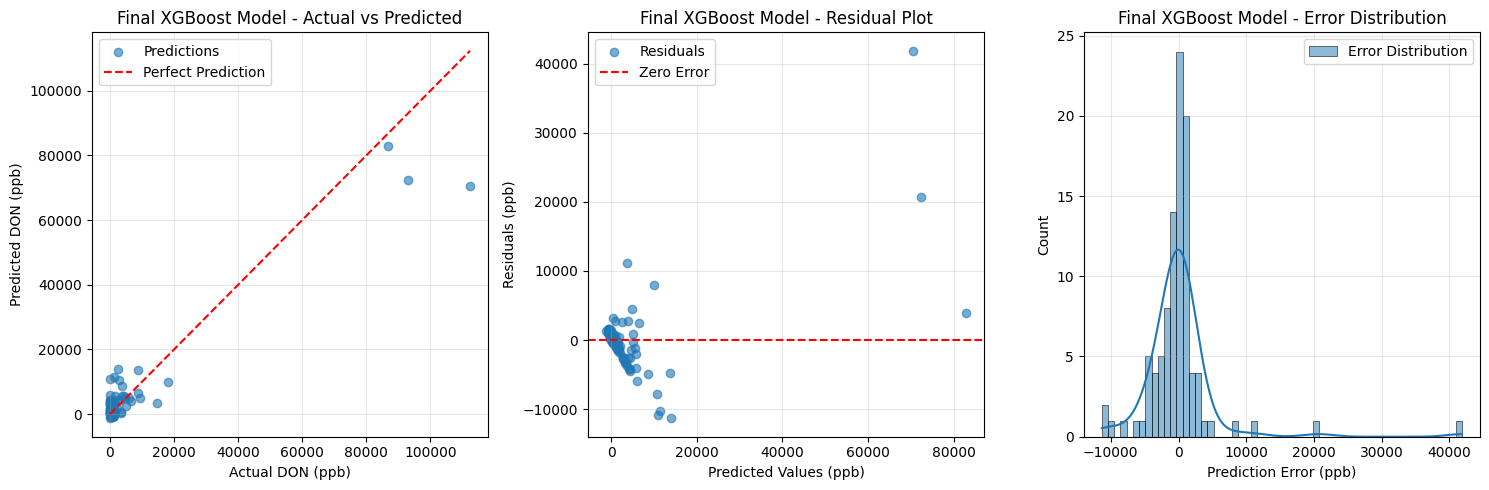

<Figure size 1000x800 with 0 Axes>

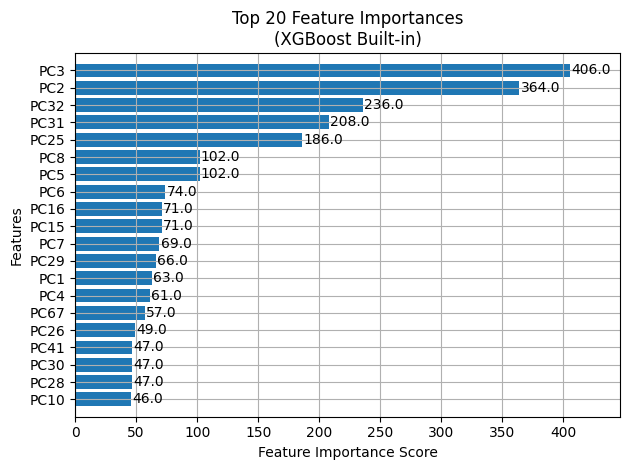

/tmp/ipykernel_2213027/1530039692.py:273: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=20, show=False)


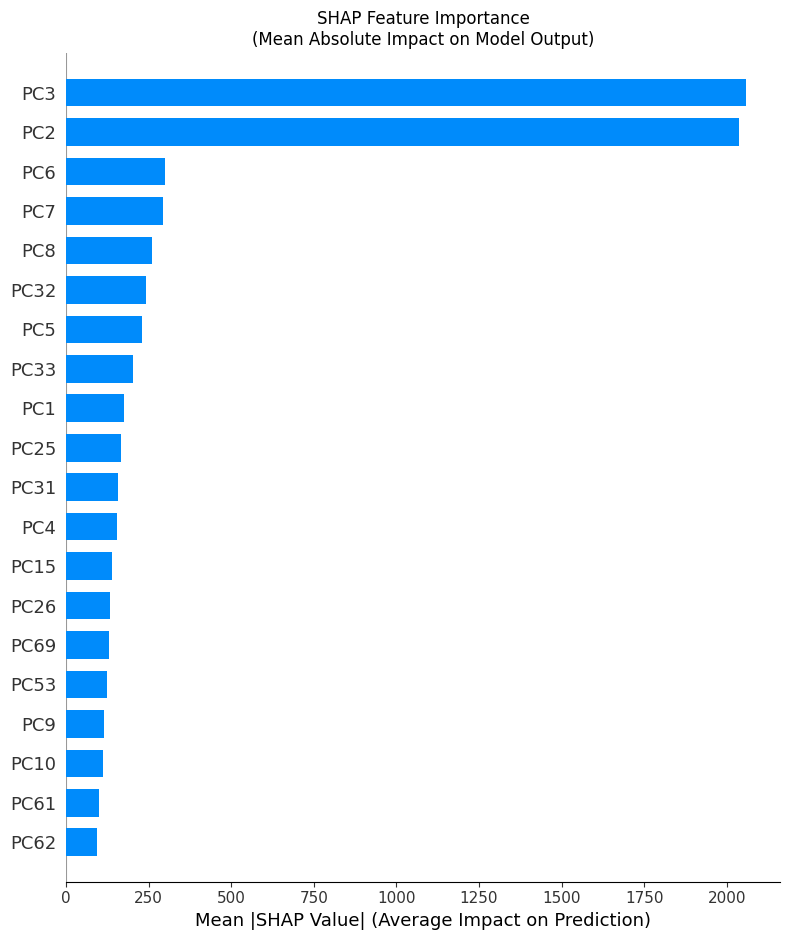

/tmp/ipykernel_2213027/1530039692.py:281: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train, max_display=10, show=False)


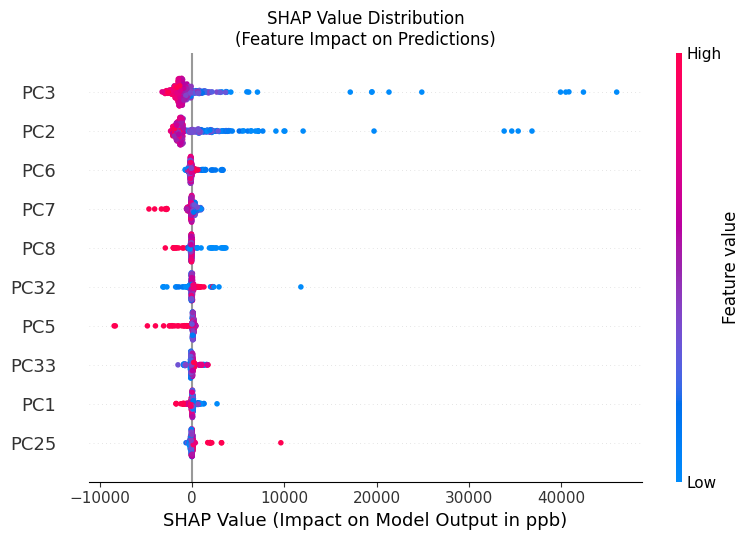

2025-03-31 04:35:17,939 - INFO - SHAP explainer saved to ../data/models/shap_explainer.pkl
2025-03-31 04:35:17,941 - INFO - Sample prediction: 736.32 ppb
2025-03-31 04:35:17,942 - INFO - Final Model Performance Summary:
2025-03-31 04:35:17,943 - INFO -               Metric       Value
Cross-Validated RMSE 6685.931601
            Test MAE 2540.090928
           Test RMSE 5602.773071
             Test R²    0.887702
2025-03-31 04:35:17,944 - INFO - Top 10 Features:
2025-03-31 04:35:17,945 - INFO - Feature  Importance
    PC3    0.189691
   PC33    0.109957
    PC2    0.060464
   PC53    0.056767
    PC6    0.055127
   PC60    0.044180
   PC22    0.041453
    PC1    0.031331
   PC59    0.030193
   PC10    0.026973


In [7]:
# xgboost_pipeline.py
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'  # Disable GPU if needed

import logging
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import shap
import joblib
import optuna
from optuna.samplers import TPESampler

# =============================================================================
# CONFIGURATION & LOGGING SETUP
# =============================================================================
# Set up logging: both console and file logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler(), logging.FileHandler("xgboost_pipeline.log")]
)
logger = logging.getLogger(__name__)

def load_config(config_path: str) -> dict:
    """Load external configuration settings from a YAML file."""
    try:
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)
        logger.info("Configuration loaded successfully.")
        return config
    except Exception as e:
        logger.error(f"Error loading config file {config_path}: {e}")
        raise e

# Load configuration (ensure ../configs/config.yaml exists with appropriate entries)
config = load_config("../configs/config.yaml")
RANDOM_STATE = config.get("random_state", 42)
np.random.seed(RANDOM_STATE)

# =============================================================================
# DATA LOADING MODULE
# =============================================================================
def load_preprocessed_data(x_train_path: str, x_test_path: str,
                           y_train_path: str, y_test_path: str):
    """Load preprocessed data with error handling."""
    try:
        X_train = pd.read_csv(x_train_path)
        X_test = pd.read_csv(x_test_path)
        y_train = pd.read_csv(y_train_path)
        y_test = pd.read_csv(y_test_path)
        logger.info(f"Data loaded: X_train {X_train.shape}, X_test {X_test.shape}, "
                    f"y_train {y_train.shape}, y_test {y_test.shape}")
        return X_train, X_test, y_train, y_test
    except Exception as e:
        logger.error(f"Error loading preprocessed data: {e}")
        raise e

# File paths (can also be managed via config)
x_train_path = "../data/processed/x_train.csv"
x_test_path = "../data/processed/x_test.csv"
y_train_path = "../data/processed/y_train.csv"
y_test_path = "../data/processed/y_test.csv"

X_train, X_test, y_train, y_test = load_preprocessed_data(
    x_train_path, x_test_path, y_train_path, y_test_path
)

# =============================================================================
# DATA PREPARATION
# =============================================================================
try:
    # Remove identifier column and extract target
    X_train = X_train.drop(columns=['hsi_id'])
    X_test = X_test.drop(columns=['hsi_id'])
    y_train = y_train['vomitoxin_ppb']
    y_test = y_test['vomitoxin_ppb']
    logger.info("Identifier columns removed and targets extracted.")
except Exception as e:
    logger.error(f"Error during data preparation: {e}")
    raise e

# =============================================================================
# MODEL EVALUATION FUNCTION
# =============================================================================
def evaluate_model(model, X_train, y_train, X_test, y_test) -> tuple:
    """
    Evaluate model using K-Fold cross-validation and test set performance.
    Returns a dictionary of metrics and test predictions.
    """
    try:
        cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
        cv_scores = cross_val_score(
            model, X_train, y_train, 
            cv=cv, 
            scoring='neg_mean_squared_error',
            n_jobs=4
        )
        rmse_scores = np.sqrt(-cv_scores)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
        metrics = {
            'CV_RMSE_mean': rmse_scores.mean(),
            'CV_RMSE_std': rmse_scores.std(),
            'Test_MAE': mean_absolute_error(y_test, y_pred),
            'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'Test_R2': r2_score(y_test, y_pred)
        }
        logger.info("Model evaluation completed.")
        return metrics, y_pred
    except Exception as e:
        logger.error(f"Error during model evaluation: {e}")
        raise e

# =============================================================================
# BASELINE MODEL TRAINING
# =============================================================================
try:
    xgb_baseline = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        max_depth=10,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=8
    )
    baseline_metrics, baseline_pred = evaluate_model(xgb_baseline, X_train, y_train, X_test, y_test)
    logger.info("XGBoost Baseline Performance:")
    logger.info(baseline_metrics)
except Exception as e:
    logger.error(f"Error training baseline model: {e}")
    raise e

# =============================================================================
# HYPERPARAMETER TUNING WITH OPTUNA
# =============================================================================
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    
    model = xgb.XGBRegressor(
        **params,
        objective='reg:squarederror',
        random_state=RANDOM_STATE,
        n_jobs=4
    )
    
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    score = cross_val_score(
        model, X_train, y_train,
        cv=cv,
        scoring='neg_mean_squared_error',
        n_jobs=8
    ).mean()
    
    return np.sqrt(-score)

logger.info("Starting hyperparameter tuning with Optuna...")
study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=RANDOM_STATE)
)
study.optimize(objective, n_trials=50, show_progress_bar=True)

trial = study.best_trial
logger.info(f"Best trial RMSE: {trial.value:.4f}")
logger.info(f"Best parameters: {trial.params}")

# =============================================================================
# TRAIN FINAL MODEL WITH BEST PARAMETERS
# =============================================================================
try:
    best_params = trial.params
    final_model = xgb.XGBRegressor(
        **best_params,
        objective='reg:squarederror',
        random_state=RANDOM_STATE,
        n_jobs=8
    )
    
    final_metrics, final_pred = evaluate_model(final_model, X_train, y_train, X_test, y_test)
    logger.info("Final Model Performance:")
    logger.info(final_metrics)
    
    # Save final model artifact
    model_save_path = '../data/models/best_xgboost_model.pkl'
    joblib.dump(final_model, model_save_path)
    logger.info(f"Final model saved to {model_save_path}")
except Exception as e:
    logger.error(f"Error training final model: {e}")
    raise e

# =============================================================================
# ENHANCED VISUALIZATION FUNCTION
# =============================================================================
def plot_results(y_true, y_pred, model_name):
    """Create evaluation plots with detailed legends."""
    plt.figure(figsize=(15, 5))
    
    # Actual vs Predicted
    plt.subplot(1, 3, 1)
    plt.scatter(y_true, y_pred, alpha=0.6, label='Predictions')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
             'r--', label='Perfect Prediction')
    plt.xlabel('Actual DON (ppb)')
    plt.ylabel('Predicted DON (ppb)')
    plt.title(f'{model_name} - Actual vs Predicted')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Residuals
    residuals = y_true - y_pred
    plt.subplot(1, 3, 2)
    plt.scatter(y_pred, residuals, alpha=0.6, label='Residuals')
    plt.axhline(y=0, color='r', linestyle='--', label='Zero Error')
    plt.xlabel('Predicted Values (ppb)')
    plt.ylabel('Residuals (ppb)')
    plt.title(f'{model_name} - Residual Plot')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Error Distribution
    plt.subplot(1, 3, 3)
    sns.histplot(residuals, kde=True, label='Error Distribution')
    plt.xlabel('Prediction Error (ppb)')
    plt.title(f'{model_name} - Error Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot final model results
plot_results(y_test, final_pred, "Final XGBoost Model")

# =============================================================================
# FEATURE IMPORTANCE AND SHAP ANALYSIS
# =============================================================================
try:
    # Built-in feature importance plot
    plt.figure(figsize=(10, 8))
    xgb.plot_importance(final_model, max_num_features=20, height=0.8)
    plt.title('Top 20 Feature Importances\n(XGBoost Built-in)')
    plt.xlabel('Feature Importance Score')
    plt.tight_layout()
    plt.show()

    # SHAP Analysis
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer(X_train)  # Directly compute SHAP values
    
    # SHAP Summary Plot - Bar
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=20, show=False)
    plt.title('SHAP Feature Importance\n(Mean Absolute Impact on Model Output)')
    plt.xlabel('Mean |SHAP Value| (Average Impact on Prediction)')
    plt.tight_layout()
    plt.show()
    
    # SHAP Summary Plot - Detailed
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_train, max_display=10, show=False)
    plt.title('SHAP Value Distribution\n(Feature Impact on Predictions)')
    plt.xlabel('SHAP Value (Impact on Model Output in ppb)')
    plt.tight_layout()
    plt.show()
    
    # Save SHAP explainer artifact
    shap_explainer_path = '../data/models/shap_explainer.pkl'
    joblib.dump(explainer, shap_explainer_path)
    logger.info(f"SHAP explainer saved to {shap_explainer_path}")
except Exception as e:
    logger.error(f"Error during SHAP analysis: {e}")

# =============================================================================
# PREDICTION FUNCTION FOR API INTEGRATION
# =============================================================================
def predict_don(features):
    """
    Predict DON concentration from spectral features.
    This function can later be integrated into a RESTful API endpoint.
    """
    try:
        global final_model
        if final_model is None:
            final_model = joblib.load('../data/models/best_xgboost_model.pkl')
        features = np.array(features).reshape(1, -1)
        prediction = float(final_model.predict(features)[0])
        return prediction
    except Exception as e:
        logger.error(f"Error during prediction: {e}")
        raise e

# Example prediction using first sample of X_train
sample_features = X_train.iloc[0].values
logger.info(f"Sample prediction: {predict_don(sample_features):.2f} ppb")

# =============================================================================
# FINAL PERFORMANCE REPORT
# =============================================================================
performance_df = pd.DataFrame({
    'Metric': ['Cross-Validated RMSE', 'Test MAE', 'Test RMSE', 'Test R²'],
    'Value': [
        final_metrics['CV_RMSE_mean'],
        final_metrics['Test_MAE'],
        final_metrics['Test_RMSE'],
        final_metrics['Test_R2']
    ]
})

logger.info("Final Model Performance Summary:")
logger.info(performance_df.to_string(index=False))

# Display top 10 features by importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=False)
logger.info("Top 10 Features:")
logger.info(feature_importance.head(10).to_string(index=False))


In [9]:
! pip install pytest  # Recommended for easy and flexible testing
! pip install nose    # Alternative testing framework


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.6/343.6 kB 3.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 2.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [12]:
# tests/test_xgboost_pipeline.py
import os
import tempfile
import unittest
import numpy as np
import pandas as pd
import joblib
import xgboost as xgb

# Import functions from your pipeline module
# from xgboost_pipeline import (
#     load_config,
#     load_preprocessed_data,
#     evaluate_model,
#     predict_don
# )

class TestXGBoostPipeline(unittest.TestCase):
    def setUp(self):
        # Create a temporary directory for dummy CSV files and config
        self.temp_dir = tempfile.TemporaryDirectory()
        
        # Simulate data with 70 features + 'hsi_id'
        n_train, n_test, n_features = 50, 20, 70
        feature_columns = ['hsi_id'] + [f'feature_{i}' for i in range(1, n_features + 1)]
        
        # Create dummy training data
        train_data = np.random.rand(n_train, n_features)  # 70 features
        train_df = pd.DataFrame(train_data, columns=[f'feature_{i}' for i in range(1, n_features + 1)])
        train_df.insert(0, 'hsi_id', np.arange(1, n_train + 1))
        # Create dummy test data
        test_data = np.random.rand(n_test, n_features)
        test_df = pd.DataFrame(test_data, columns=[f'feature_{i}' for i in range(1, n_features + 1)])
        test_df.insert(0, 'hsi_id', np.arange(n_train + 1, n_train + n_test + 1))
        
        # Dummy targets
        y_train = pd.DataFrame({'vomitoxin_ppb': np.random.randint(100, 1000, size=n_train)})
        y_test = pd.DataFrame({'vomitoxin_ppb': np.random.randint(100, 1000, size=n_test)})
        
        # File paths for temporary CSV files
        self.x_train_path = os.path.join(self.temp_dir.name, "x_train.csv")
        self.x_test_path = os.path.join(self.temp_dir.name, "x_test.csv")
        self.y_train_path = os.path.join(self.temp_dir.name, "y_train.csv")
        self.y_test_path = os.path.join(self.temp_dir.name, "y_test.csv")
        
        # Write CSV files
        train_df.to_csv(self.x_train_path, index=False)
        test_df.to_csv(self.x_test_path, index=False)
        y_train.to_csv(self.y_train_path, index=False)
        y_test.to_csv(self.y_test_path, index=False)
        
        # Create a dummy config YAML file
        self.config_path = os.path.join(self.temp_dir.name, "config.yaml")
        with open(self.config_path, 'w') as f:
            f.write("random_state: 42\n")
        
    def tearDown(self):
        # Clean up temporary directory
        self.temp_dir.cleanup()
        
    def test_load_config(self):
        # Verify configuration loading
        from xgboost_pipeline import load_config
        config = load_config(self.config_path)
        self.assertIn("random_state", config)
        self.assertEqual(config["random_state"], 42)
        
    def test_load_preprocessed_data(self):
        # Verify data loading
        X_train, X_test, y_train, y_test = load_preprocessed_data(
            self.x_train_path, self.x_test_path,
            self.y_train_path, self.y_test_path
        )
        # Expect 50 and 20 rows respectively
        self.assertEqual(X_train.shape[0], 50)
        self.assertEqual(X_test.shape[0], 20)
        self.assertEqual(y_train.shape[0], 50)
        self.assertEqual(y_test.shape[0], 20)
        
    def test_evaluate_model(self):
        # Load dummy data and simulate expected processing:
        X_train, X_test, y_train, y_test = load_preprocessed_data(
            self.x_train_path, self.x_test_path,
            self.y_train_path, self.y_test_path
        )
        # Drop 'hsi_id' column and extract target
        X_train = X_train.drop(columns=['hsi_id'])
        X_test = X_test.drop(columns=['hsi_id'])
        y_train = y_train['vomitoxin_ppb']
        y_test = y_test['vomitoxin_ppb']
        
        # Create a simple XGBoost model
        model = xgb.XGBRegressor(
            objective='reg:squarederror', n_estimators=10, max_depth=2, random_state=42
        )
        metrics, predictions = evaluate_model(model, X_train, y_train, X_test, y_test)
        self.assertIn('Test_R2', metrics)
        self.assertTrue(isinstance(predictions, np.ndarray))
        
    def test_predict_don(self):
        # Load dummy data and simulate expected processing:
        X_train, X_test, y_train, y_test = load_preprocessed_data(
            self.x_train_path, self.x_test_path,
            self.y_train_path, self.y_test_path
        )
        X_train = X_train.drop(columns=['hsi_id'])
        X_test = X_test.drop(columns=['hsi_id'])
        y_train = y_train['vomitoxin_ppb']
        y_test = y_test['vomitoxin_ppb']
        
        # Train a simple model
        model = xgb.XGBRegressor(
            objective='reg:squarederror', n_estimators=10, max_depth=2, random_state=42
        )
        model.fit(X_train, y_train)
        
        # Set the global final_model for prediction function
        import xgboost_pipeline
        xgboost_pipeline.final_model = model
        
        # Test predict_don returns a float value
        sample_features = X_train.iloc[0].values
        prediction = predict_don(sample_features)
        self.assertTrue(isinstance(prediction, float))
        
if __name__ == "__main__":
    unittest.main()


usage: ipykernel_launcher.py [-h] [-v] [-q] [--locals] [-f] [-c] [-b]
                             [-k TESTNAMEPATTERNS]
                             [tests ...]
ipykernel_launcher.py: error: argument -f/--failfast: ignored explicit argument '/run/user/1005/jupyter/runtime/kernel-v38da2f70880fe5cf4c7e8c60522e3dc024ed89778.json'


SystemExit: 2

In [13]:
# This code should be placed in a notebook cell

import os
import tempfile
import unittest
import numpy as np
import pandas as pd
import joblib
import xgboost as xgb

# For this example, we'll simulate the minimal functions from your pipeline.
# In your actual notebook, you should import these from your pipeline module.
# For instance:
# from xgboost_pipeline import load_config, load_preprocessed_data, evaluate_model, predict_don

def load_config(config_path: str) -> dict:
    """Dummy implementation for testing purposes."""
    import yaml
    try:
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)
        return config
    except Exception as e:
        raise e

def load_preprocessed_data(x_train_path: str, x_test_path: str, y_train_path: str, y_test_path: str):
    try:
        X_train = pd.read_csv(x_train_path)
        X_test = pd.read_csv(x_test_path)
        y_train = pd.read_csv(y_train_path)
        y_test = pd.read_csv(y_test_path)
        return X_train, X_test, y_train, y_test
    except Exception as e:
        raise e

def evaluate_model(model, X_train, y_train, X_test, y_test) -> tuple:
    from sklearn.model_selection import KFold, cross_val_score
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    try:
        RANDOM_STATE = 42
        cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=1)
        rmse_scores = np.sqrt(-cv_scores)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        metrics = {
            'CV_RMSE_mean': rmse_scores.mean(),
            'CV_RMSE_std': rmse_scores.std(),
            'Test_MAE': mean_absolute_error(y_test, y_pred),
            'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'Test_R2': r2_score(y_test, y_pred)
        }
        return metrics, y_pred
    except Exception as e:
        raise e

def predict_don(features):
    """
    Dummy predict_don function for testing.
    In production, this would load the final model if needed and return a prediction.
    """
    try:
        global final_model
        if final_model is None:
            final_model = joblib.load('best_xgboost_model.pkl')
        features = np.array(features).reshape(1, -1)
        prediction = float(final_model.predict(features)[0])
        return prediction
    except Exception as e:
        raise e

# For testing purposes, we'll simulate a global variable for the final model.
final_model = None

# Unit test class
class TestXGBoostPipeline(unittest.TestCase):
    def setUp(self):
        # Create a temporary directory for dummy CSV files and config
        self.temp_dir = tempfile.TemporaryDirectory()
        
        # Simulate data with 70 features plus an 'hsi_id' column
        n_train, n_test, n_features = 50, 20, 70
        feature_columns = ['hsi_id'] + [f'feature_{i}' for i in range(1, n_features + 1)]
        
        # Create dummy training data
        train_data = np.random.rand(n_train, n_features)
        train_df = pd.DataFrame(train_data, columns=[f'feature_{i}' for i in range(1, n_features + 1)])
        train_df.insert(0, 'hsi_id', np.arange(1, n_train + 1))
        
        # Create dummy test data
        test_data = np.random.rand(n_test, n_features)
        test_df = pd.DataFrame(test_data, columns=[f'feature_{i}' for i in range(1, n_features + 1)])
        test_df.insert(0, 'hsi_id', np.arange(n_train + 1, n_train + n_test + 1))
        
        # Dummy targets
        y_train = pd.DataFrame({'vomitoxin_ppb': np.random.randint(100, 1000, size=n_train)})
        y_test = pd.DataFrame({'vomitoxin_ppb': np.random.randint(100, 1000, size=n_test)})
        
        # File paths for temporary CSV files
        self.x_train_path = os.path.join(self.temp_dir.name, "x_train.csv")
        self.x_test_path = os.path.join(self.temp_dir.name, "x_test.csv")
        self.y_train_path = os.path.join(self.temp_dir.name, "y_train.csv")
        self.y_test_path = os.path.join(self.temp_dir.name, "y_test.csv")
        
        # Write CSV files
        train_df.to_csv(self.x_train_path, index=False)
        test_df.to_csv(self.x_test_path, index=False)
        y_train.to_csv(self.y_train_path, index=False)
        y_test.to_csv(self.y_test_path, index=False)
        
        # Create a dummy config YAML file
        self.config_path = os.path.join(self.temp_dir.name, "config.yaml")
        with open(self.config_path, 'w') as f:
            f.write("random_state: 42\n")
        
    def tearDown(self):
        # Clean up temporary directory
        self.temp_dir.cleanup()
        
    def test_load_config(self):
        config = load_config(self.config_path)
        self.assertIn("random_state", config)
        self.assertEqual(config["random_state"], 42)
        
    def test_load_preprocessed_data(self):
        X_train, X_test, y_train, y_test = load_preprocessed_data(
            self.x_train_path, self.x_test_path,
            self.y_train_path, self.y_test_path
        )
        self.assertEqual(X_train.shape[0], 50)
        self.assertEqual(X_test.shape[0], 20)
        self.assertEqual(y_train.shape[0], 50)
        self.assertEqual(y_test.shape[0], 20)
        
    def test_evaluate_model(self):
        X_train, X_test, y_train, y_test = load_preprocessed_data(
            self.x_train_path, self.x_test_path,
            self.y_train_path, self.y_test_path
        )
        # Remove 'hsi_id'
        X_train = X_train.drop(columns=['hsi_id'])
        X_test = X_test.drop(columns=['hsi_id'])
        y_train = y_train['vomitoxin_ppb']
        y_test = y_test['vomitoxin_ppb']
        
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10, max_depth=2, random_state=42)
        metrics, predictions = evaluate_model(model, X_train, y_train, X_test, y_test)
        self.assertIn('Test_R2', metrics)
        self.assertTrue(isinstance(predictions, np.ndarray))
        
    def test_predict_don(self):
        X_train, X_test, y_train, y_test = load_preprocessed_data(
            self.x_train_path, self.x_test_path,
            self.y_train_path, self.y_test_path
        )
        X_train = X_train.drop(columns=['hsi_id'])
        X_test = X_test.drop(columns=['hsi_id'])
        y_train = y_train['vomitoxin_ppb']
        y_test = y_test['vomitoxin_ppb']
        
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10, max_depth=2, random_state=42)
        model.fit(X_train, y_train)
        
        # Set the global final_model for predict_don
        global final_model
        final_model = model
        
        sample_features = X_train.iloc[0].values
        prediction = predict_don(sample_features)
        self.assertTrue(isinstance(prediction, float))
        
# Run the tests in the notebook
unittest.main(argv=[''], exit=False)


....
----------------------------------------------------------------------
Ran 4 tests in 10.759s

OK


In [14]:
# app.py
import os
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel, conlist
from typing import List
import joblib
import numpy as np
import logging

# Set up basic logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Initialize FastAPI app
app = FastAPI(
    title="DON Prediction API",
    description="API for predicting DON concentration in corn samples using hyperspectral data.",
    version="1.0.0"
)

# Define input model: list of features (assumed to be 70 features)
class PredictionRequest(BaseModel):
    # The features must be a list of exactly 70 float values.
    features: conlist(float, min_items=70, max_items=70)

class PredictionResponse(BaseModel):
    prediction: float

# Load the final model and related artifacts on startup
MODEL_PATH = os.path.join("..", "data", "models", "best_xgboost_model.pkl")
SHAP_EXPLAINER_PATH = os.path.join("..", "data", "models", "shap_explainer.pkl")

# Global variables to hold the loaded model and explainer
final_model = None

def load_model():
    global final_model
    try:
        final_model = joblib.load(MODEL_PATH)
        logger.info(f"Model loaded successfully from {MODEL_PATH}")
    except Exception as e:
        logger.error(f"Failed to load model: {e}")
        raise e

@app.on_event("startup")
async def startup_event():
    load_model()

def predict_don(features: List[float]) -> float:
    """
    Predict DON concentration from spectral features.
    Assumes that the final_model is loaded.
    """
    global final_model
    if final_model is None:
        logger.error("Model is not loaded.")
        raise HTTPException(status_code=500, detail="Model is not available.")
    try:
        # Convert features into a numpy array with shape (1, -1)
        features_arr = np.array(features).reshape(1, -1)
        prediction = float(final_model.predict(features_arr)[0])
        logger.info(f"Prediction computed: {prediction:.2f} ppb")
        return prediction
    except Exception as e:
        logger.error(f"Error during prediction: {e}")
        raise HTTPException(status_code=500, detail="Error during prediction.")

@app.post("/predict", response_model=PredictionResponse)
async def get_prediction(request: PredictionRequest):
    """
    Endpoint to get DON prediction.
    Expects JSON payload with a 'features' list containing 70 spectral features.
    """
    try:
        prediction = predict_don(request.features)
        return PredictionResponse(prediction=prediction)
    except Exception as e:
        logger.error(f"Prediction endpoint error: {e}")
        raise HTTPException(status_code=500, detail="Prediction failed.")

# A simple health check endpoint
@app.get("/health")
async def health_check():
    return {"status": "UP"}


TypeError: conlist() got an unexpected keyword argument 'min_items'